In [1]:
import pandas as pd
import numpy as np
import json
from gseapy.plot import gseaplot, heatmap
import gseapy as gp
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy.stats import pearsonr
from collections import Counter

import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy.stats import mannwhitneyu,pearsonr
from statannot import add_stat_annotation



In [2]:
%matplotlib inline

### gloable variables

In [2]:
subtype_rename = {'Atypical':'A','Basal':'B','Classical':'C','Mesenchymal':'M'}

## update avatar HPV annotation

149 samples were checked HPV status based on p16 expression status.

In [17]:
path = 'AVATAR/AVATAR_SurvData_N149_20211220.txt'
data = pd.read_csv(path)

In [18]:
data

RNA survcens survtime p16
0       SL243659 0 2 Negative
1       SL243660 0 3 Negative
2      SL243661 1 40 Negative
3      SL243662 1 12 Negative
4           SL243671 0 121 NA
..                        ...
144    SL258030 1 25 Negative
145    SL258032 0 40 Negative
146    SL258034 0 37 Negative
147          SL381603 0 61 NA
148         SL381621 1 129 NA

[149 rows x 1 columns]

In [19]:
data[['RNA', 'survcens','survtime','p16','else']] = data['RNA survcens survtime p16'].str.split(' ', expand=True)

In [20]:
data['p16'].unique()

array(['Negative', 'NA', 'Not', 'Positive'], dtype=object)

In [7]:
remove = data[data['p16'].isin(['NA', 'Not'])]

In [8]:
hpv_pos = remove['RNA'].to_list()

In [9]:
path = 'AVATAR/HN_v0.4.3_RNAseq_counts_library_size_normalized_log2.txt'
rna_data = pd.read_csv(path,sep='\t',index_col=0)

In [10]:
rna_data.columns

Index(['SL257959', 'SL243676', 'SL243737', 'SL243718', 'SL243681', 'SL243693',
       'SL243719', 'SL243694', 'SL243670', 'SL257939',
       ...
       'SL252531', 'SL252530', 'SL252532', 'SL252533', 'SL252534', 'SL252535',
       'SL252536', 'SL251091', 'SL251092', 'SL257960'],
      dtype='object', length=238)

In [11]:
hpv_neg = []
for i in rna_data.columns:
    if i not in hpv_pos:
        hpv_neg.append(i)

In [12]:
len(hpv_neg)

224

In [34]:
with open('AVATAR/HPV_neg_list.txt', 'w') as f:
    for item in hpv_neg:
        f.write("%s\n" % item)

### Combining survival data from two batches (TMA + new 149)

In [23]:
hpv_neg = pd.read_csv('AVATAR/HPV_neg_list.txt',sep='\t',header=None)[0].to_list()
data_neg_surv = data[data['RNA'].isin(hpv_neg)][['RNA','survcens','survtime']]

In [25]:
data_neg_surv.columns = ['SLID.RNA','SURVCENS','SURVTIME']

In [26]:
data_neg_surv

SLID.RNA SURVCENS SURVTIME
0    SL243659        0        2
1    SL243660        0        3
2    SL243661        1       40
3    SL243662        1       12
5    SL243674        1       13
..        ...      ...      ...
142  SL258030        1       25
143  SL258030        1       25
144  SL258030        1       25
145  SL258032        0       40
146  SL258034        0       37

[135 rows x 3 columns]

In [27]:
# class assignment for moffitt cohort
with open('paper_results/helpers/avatar_class_by_correlation.json', 'r') as fp:
    res_correlation = json.load(fp)

df_clinical = pd.ExcelFile('background/HNSCC_TMA1_CLINICAL_INFO.xlsx',engine='openpyxl')
df_clinical = pd.read_excel(df_clinical, 'Sheet1',index_col=None, header=0)
df_clinical = df_clinical.dropna(subset=['SLID.RNA'])

df_clinical['class'] = df_clinical['SLID.RNA'].map(res_correlation)

df_clinical

SLID.WES  SLID.RNA CORE      SOURCE   ID  GENDER   RACE ETHNICITY  AGE  \
0    SL244158  SL250016   A1     Primary  292    Male  White  Non-Hisp   66   
2    SL244161  SL250031  A11     Primary  272    Male  White  Non-Hisp   64   
3    SL248609  SL243661  A12     Primary  291    Male  White  Non-Hisp   57   
4    SL244156  SL250191  A13     Primary    8    Male  White  Non-Hisp   46   
5    SL250157  SL250157  A14     Primary  308    Male  White  Non-Hisp   47   
..        ...       ...  ...         ...  ...     ...    ...       ...  ...   
116  SL243008  SL249995   J5     Primary  213  Female  White  Non-Hisp   77   
117  SL242970  SL243717   J6     Primary   19  Female  White  Non-Hisp   56   
118  SL257939  SL257939   J7  Recurrence   59    Male  White  Non-Hisp   64   
119  SL248668  SL243712   J8     Primary  166    Male  White  Non-Hisp   64   
120  SL248666  SL243736   J9  Recurrence   43  Female  White  Hispanic   53   

    ECOG  ...    T    N   M STAGE RECCENS RECTIME SURVCENS SURVTIME  BLOCK  \
0      1  ...   T2    .  M0   2.0       0     NaN        1        3     HP   
2      1  ...   T2   N0  M0   4.0       1     8.0        0       61     OC   
3      2  ...   T4   N2  M0   4.0       1    37.0        0       39     LX   
4      1  ...   T3    .  M0   3.0       1    16.0        1      170     OC   
5      0  ...   T2   N1  M0   3.0       1     7.0        0       37     OC   
..   ...  ...  ...  ...  ..   ...     ...     ...      ...      ...    ...   
116    1  ...   T2    .  M0   4.0       1    20.0        1       39     OC   
117    0  ...   T4   N2  M0   4.0       0     NaN        1       63     LX   
118    0  ...  rT1  rN1   .   NaN       0     NaN        0      141     OC   
119    1  ...   T3   N2  M0   4.0       1     9.0        1       13     LX   
120    1  ...  rT4  rN2   .   NaN       1    10.0        1       15     LX   

           class  
0      Classical  
2          Basal  
3    Mesenchymal  
4    Mesenchymal  
5    Mesenchymal  
..           ...  
116  Mesenchymal  
117    Classical  
118        Basal  
119    Classical  
120     Atypical  

[90 rows x 25 columns]

In [28]:
df_clinical_surv = df_clinical[['SLID.RNA','SURVCENS','SURVTIME']]

In [32]:
# save only the hpv_neg samples
df_clinical_surv = df_clinical_surv[~df_clinical_surv['SLID.RNA'].isin(hpv_pos)]

In [33]:
result = df_clinical_surv.append(data_neg_surv, sort=False)

In [36]:
result = result.drop_duplicates(subset='SLID.RNA')

In [37]:
result[]

SLID.RNA SURVCENS SURVTIME
0    SL250016        1        3
2    SL250031        0       61
3    SL243661        0       39
4    SL250191        1      170
5    SL250157        0       37
..        ...      ...      ...
139  SL258019        0       41
140  SL258020        1       25
141  SL258030        1       25
145  SL258032        0       40
146  SL258034        0       37

[153 rows x 3 columns]

In [38]:
result.to_csv('paper_results/helpers/avatar_survival_data_2021.csv',index=False)

Note: save result data seperately, and read in that data for visualization, this is more reproducible. 

# Figure 1

# Figure 1a Heatmaps of subtype classification

Using most correlated method to assign classes, but do not set calssification threshold(no "undecided")

Count the number of each subtype and save to the `count_df` while going through each dataset.

In [35]:
count_df = pd.DataFrame(columns=['Atypical','Basal','Classical','Mesenchymal'])

## Moffitt cohort

In [42]:
with open('paper_results/helpers/avatar_class_by_correlation.json', 'r') as fp:
    res_correlation = json.load(fp)
    
hpv_neg = pd.read_csv('AVATAR/HPV_neg_list.txt',sep='\t',header=None)[0].to_list()
    
path = './AVATAR/AVATAR_z_score.csv'
df = pd.read_csv(path,index_col=0)
df = df.drop(['Basal','Mesenchymal','Atypical','Classical'],axis=1)
df = df[hpv_neg]
df.columns = df.columns.map(res_correlation)
df = df.sort_index(axis=1)

In [43]:
df.head()

Atypical  Atypical  Atypical  Atypical  Atypical  Atypical  Atypical  \
GENE                                                                           
ARMCX3  0.324137  0.363000  0.980000  0.026094 -0.778192  0.752979  0.613796   
AKAP7   0.080575  1.053514  1.312616 -0.118914 -1.730643  1.438414  0.752029   
GSPT2  -0.514211  0.281369  1.450365 -2.307652 -1.119472  1.225894 -0.058167   
DNMT3A  0.619156 -0.135771 -0.285432  0.917351  0.898249 -0.278389 -0.669531   
LTBP3   1.550444 -0.998719 -0.368270  0.274855 -0.120637  0.175595  0.213460   

        Atypical  Atypical  Atypical  ...  Mesenchymal  Mesenchymal  \
GENE                                  ...                             
ARMCX3  0.670142  0.922381 -0.294480  ...    -0.164207    -0.180536   
AKAP7   0.739805 -0.053899  0.084622  ...     0.112361     0.745778   
GSPT2   0.388600  1.096003 -0.229487  ...    -0.484774     0.603869   
DNMT3A  0.900545 -0.119537  0.498359  ...    -0.721695     0.062884   
LTBP3   0.775466  1.483581  0.692148  ...    -0.712496     0.185447   

        Mesenchymal  Mesenchymal  Mesenchymal  Mesenchymal  Mesenchymal  \
GENE                                                                      
ARMCX3     0.916418     0.286035     0.108815    -0.202486     1.428084   
AKAP7     -0.002629     0.807034     0.894010     0.387018     0.317302   
GSPT2      0.814266    -0.169580    -0.729186     0.051033     1.078832   
DNMT3A     0.595155    -1.538793    -1.165797    -0.017309     0.993571   
LTBP3      2.453441     0.486417    -0.861338     1.148251     1.655482   

        Mesenchymal  Mesenchymal  Mesenchymal  
GENE                                           
ARMCX3    -0.003353     0.802748     0.682678  
AKAP7      0.714145    -0.103566    -0.291959  
GSPT2     -0.797765     0.427686     0.436587  
DNMT3A    -1.812041     0.671052     0.993481  
LTBP3     -0.510581     1.543387     0.266891  

[5 rows x 224 columns]

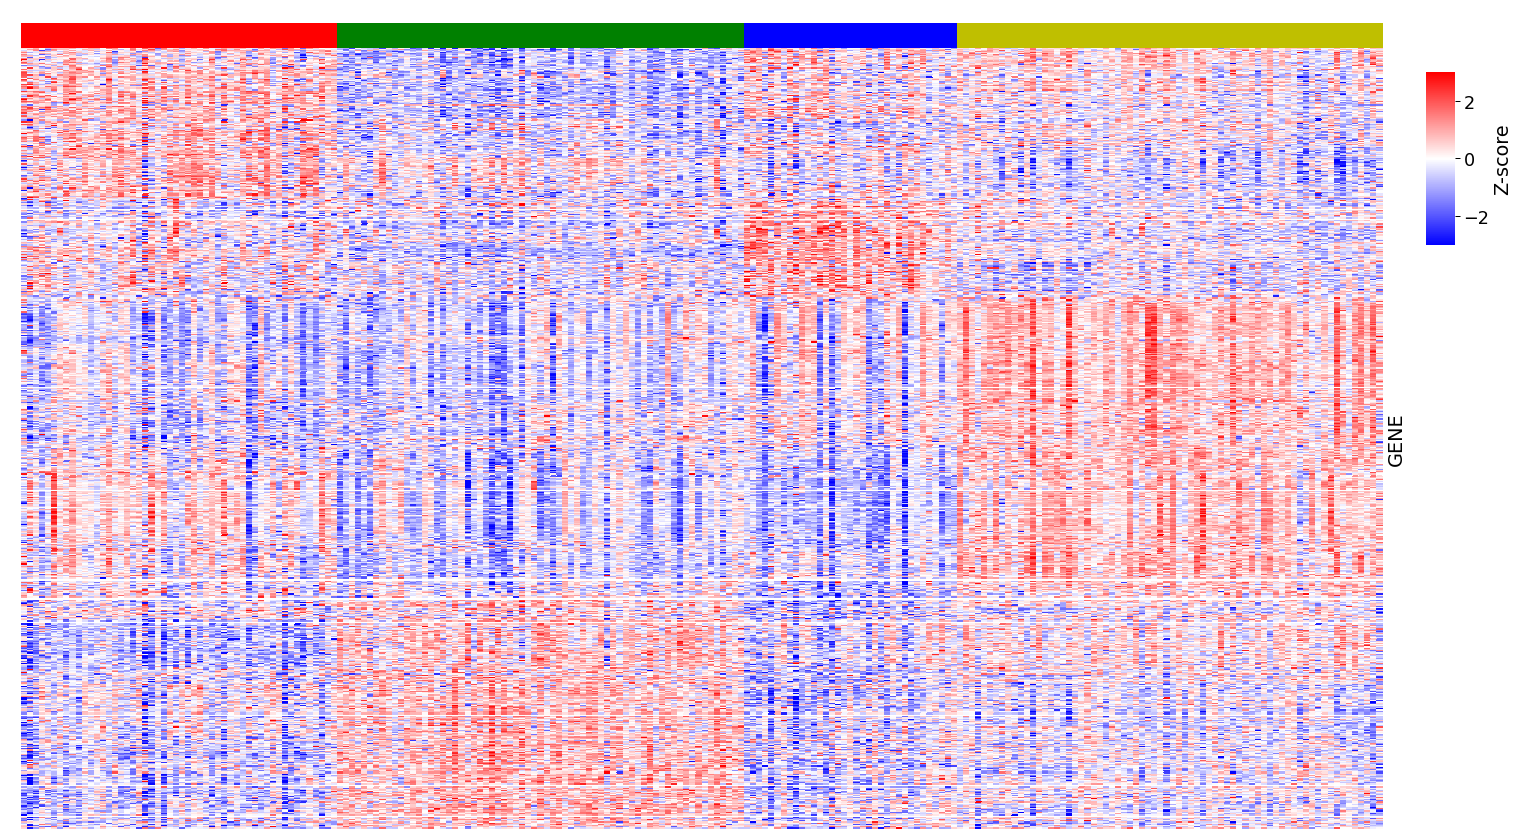

<Figure size 432x288 with 0 Axes>

In [48]:
subtype_color={'Atypical':'r','Basal':'g','Classical':'b','Mesenchymal':'y'}
#sns.set(font_scale=2)
sns.set_context("paper", font_scale=2)
sns.clustermap(df,col_cluster=False,row_cluster=False,cmap='bwr',
               vmin=-3, vmax=3, yticklabels='',xticklabels='',col_colors=df.columns.map(subtype_color),
               dendrogram_ratio=(.01, .02),
               figsize=(20, 12),
               cbar_pos=(1,0.7,0.02,0.2),
               cbar_kws={'label': 'Z-score'})
plt.savefig('paper_results/1_subtype_heatmaps/avatar_classes.png',dpi=150,format="png",bbox_inches = 'tight')
plt.show()
plt.clf()

In [49]:
# append the result to count_df
count_df = count_df.append(Counter(df.columns),ignore_index=True)

## TCGA

use full data to classify, and then subset only the HPV negative samples.

In [50]:
path = './TCGA_HNSC/HNSC_full_sub.csv'
df = pd.read_csv(path,index_col=0)
with open('paper_results/helpers/tcga_class_by_correlation.json', 'r') as fp:
    res_correlation = json.load(fp)

In [51]:
# HPV status annotation
path = 'hnsc_tcga_pan_can_atlas_2018_clinical_data.tsv'
anno = pd.read_csv(path,sep='\t')
hpv_neg = anno[anno['Subtype']=='HNSC_HPV-']['Sample ID'].to_list()

# subset to only hpv negative
df = df[hpv_neg] 

In [52]:
df.columns = df.columns.map(res_correlation)
df = df.sort_index(axis=1)

In [53]:
# append the result to count_df
count_df = count_df.append(Counter(df.columns),ignore_index=True)

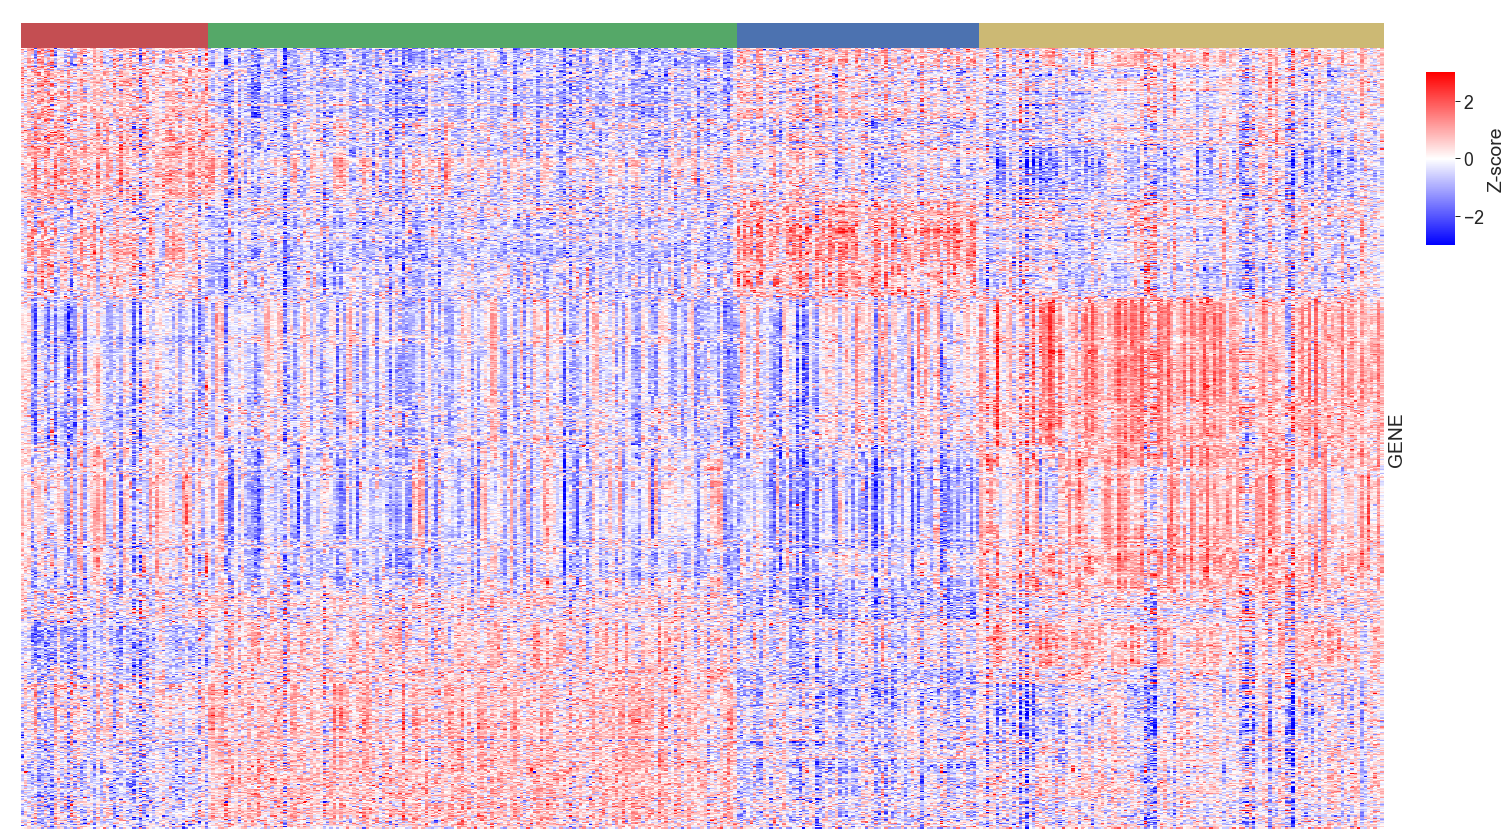

<Figure size 432x288 with 0 Axes>

In [177]:
subtype_color={'Atypical':'r','Basal':'g','Classical':'b','Mesenchymal':'y'}
#sns.set(font_scale=2)
sns.set_context("paper", font_scale=2)
sns.clustermap(df,col_cluster=False,row_cluster=False,cmap='bwr',
               vmin=-3, vmax=3, yticklabels='',xticklabels='',col_colors=df.columns.map(subtype_color),
               dendrogram_ratio=(.01, .02),
               figsize=(20, 12),
               cbar_pos=(1,0.7,0.02,0.2),
               cbar_kws={'label': 'Z-score'})
ax.set_ylabel('')    
ax.set_xlabel('')
plt.savefig('paper_results/1_subtype_heatmaps/tcga_classes.png',dpi=150,format="png",bbox_inches = 'tight')
plt.show()
plt.clf()

## CPTAC

In [54]:
path = './cptac_hnsc_processed/cptac_hnsc_fpkm_norm_symbols_tumor_sub.csv'
df = pd.read_csv(path,index_col=0)
with open('paper_results/helpers/cptac_class_by_correlation.json', 'r') as fp:
    res_correlation = json.load(fp)

In [55]:
# replace col names of df to class labels and reorder it by class for heatmap plotting
df = df.drop(['Basal','Mesenchymal','Atypical','Classical'],axis=1)
df.columns = df.columns.map(res_correlation)
df = df.sort_index(axis=1)

In [56]:
# append the result to count_df
count_df = count_df.append(Counter(df.columns),ignore_index=True)

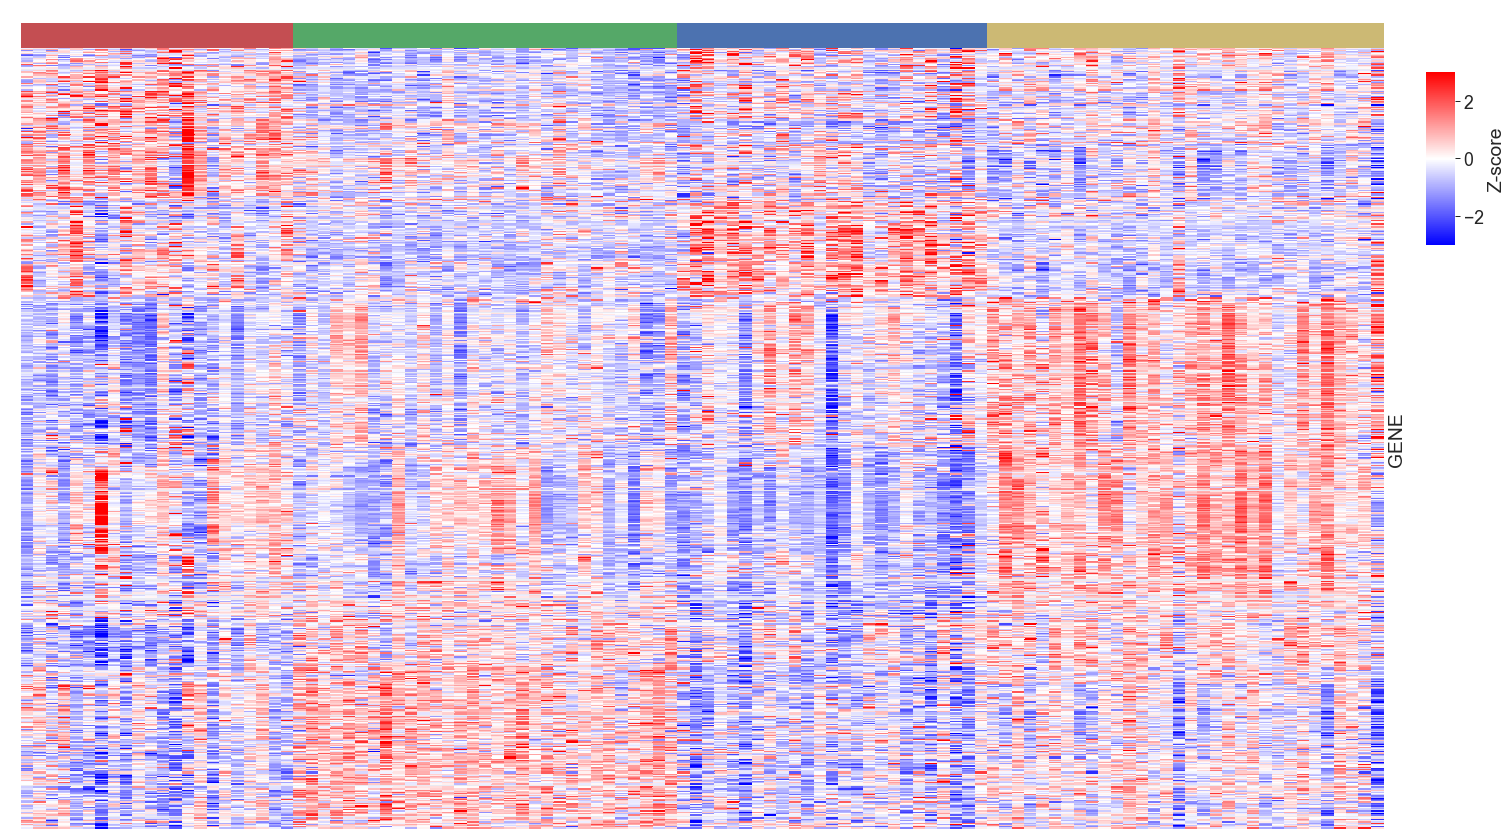

<Figure size 432x288 with 0 Axes>

In [186]:
subtype_color={'Atypical':'r','Basal':'g','Classical':'b','Mesenchymal':'y'}
#sns.set(font_scale=2)
sns.set_context("paper", font_scale=2)
sns.clustermap(df,col_cluster=False,row_cluster=False,cmap='bwr',
               vmin=-3, vmax=3, yticklabels='',xticklabels='',col_colors=df.columns.map(subtype_color),
               dendrogram_ratio=(.01, .02),
               figsize=(20, 12),
               cbar_pos=(1,0.7,0.02,0.2),
               cbar_kws={'label': 'Z-score'})
ax.set_ylabel('')    
ax.set_xlabel('')
plt.savefig('paper_results/1_subtype_heatmaps/cptac_classes.png',dpi=150,format="png",bbox_inches = 'tight')
plt.show()
plt.clf()

# Figure 1b datasets description (stacked bar graphs)

1. subtype composition of 3 datasets


resource: 

* [Stacked Percentage Bar Plot In MatPlotLib](https://www.geeksforgeeks.org/stacked-percentage-bar-plot-in-matplotlib/)
* [Percent stacked barplot](https://www.python-graph-gallery.com/13-percent-stacked-barplot)

In [57]:
count_df.rename(index={0:'Moffitt',1:'TCGA',2:'CPTAC'},inplace=True)

In [58]:
count_df

Atypical Basal Classical Mesenchymal
Moffitt       52    67        35          70
TCGA          57   161        74         123
CPTAC         22    31        25          32

In [63]:
count_df.to_csv('paper_results/helpers/sample_class_count_table.csv',index=True)

In [59]:
percent_df = count_df.apply(lambda x: x/x.sum(),axis=1).round(4)

In [60]:
percent_df

Atypical   Basal  Classical  Mesenchymal
Moffitt    0.2321  0.2991     0.1562       0.3125
TCGA       0.1373  0.3880     0.1783       0.2964
CPTAC      0.2000  0.2818     0.2273       0.2909

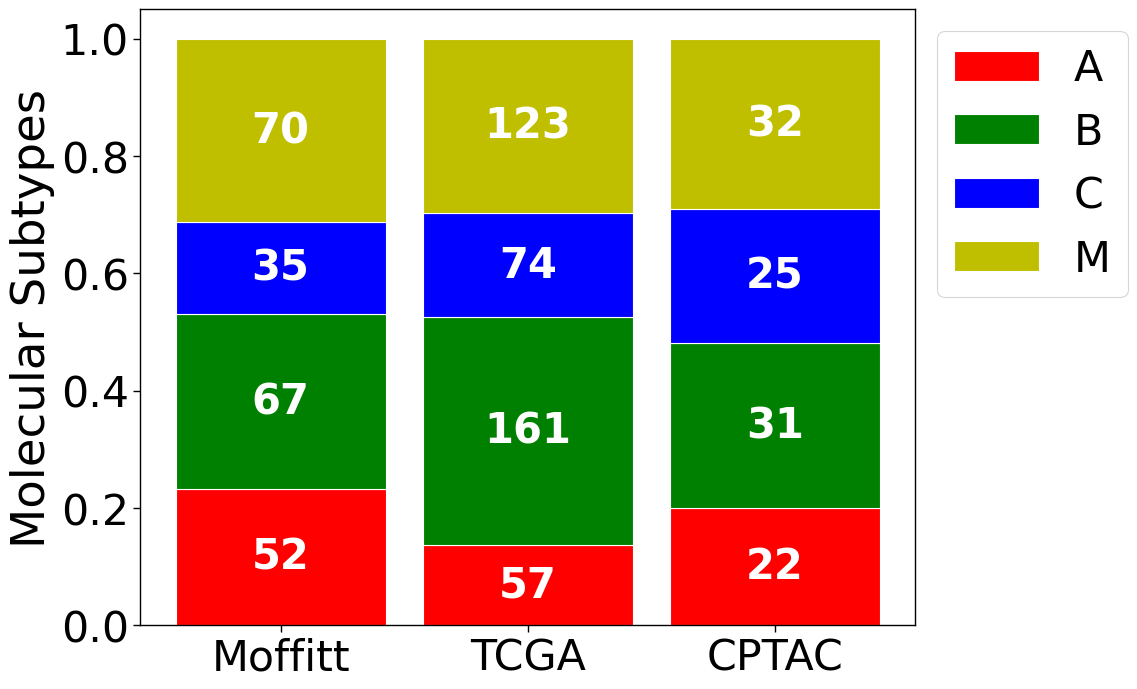

<Figure size 640x480 with 0 Axes>

In [62]:
types = ['Atypical','Basal','Classical','Mesenchymal']
atypical = percent_df['Atypical']
basal = percent_df['Basal']
classical = percent_df['Classical']
mesenchymal = percent_df['Mesenchymal']

sns.reset_defaults()
sns.set_context("paper", font_scale=3.5)

plt.figure(figsize=(10,8))
barWidth = 0.85
names = ('Moffitt','TCGA','CPTAC')
# Create green Bars
ax1 = plt.bar(names, atypical, color='r', edgecolor='white', width=barWidth, label='A')
# Create orange Bars
ax2 = plt.bar(names, basal, bottom=atypical, color='g', edgecolor='white', width=barWidth, label='B')
# Create blue Bars
ax3 = plt.bar(names, classical, bottom=[i+j for i,j in zip(atypical, basal)], 
        color='b', edgecolor='white', width=barWidth, label='C')
ax4 = plt.bar(names, mesenchymal, bottom=[i+j+k for i,j,k in zip(atypical, basal,classical)], 
        color='y', edgecolor='white', width=barWidth,label='M')

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Molecular Subtypes")
# add text
for idx, (r1, r2, r3, r4) in enumerate(zip(ax1, ax2, ax3,ax4)):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    h4 = r4.get_height()
    h1_v = count_df['Atypical'][idx]
    h2_v = count_df['Basal'][idx]
    h3_v = count_df['Classical'][idx]
    h4_v = count_df['Mesenchymal'][idx]
    
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 + h3 / 2., "%d" % h3_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r4.get_x() + r4.get_width() / 2., h1 + h2 + h3 + h4 / 2., "%d" % h4_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")

plt.savefig('paper_results/1_data_stats/overall_classes_count.png',dpi=150,format="png",bbox_inches = 'tight')
plt.show()
plt.clf()

2. composition of Moffitt cohort. The TMA only contains part of all the RNA seq samples, the figure shows in this context. 
    * subtype
    * gender
    * tumor site
    * smoking
    * stage: for the stage, need to use a different file `HNSCC_TMA1_CLINICAL_INFO`, make a dict of `SLID.RNA : STAGE` and map back to the `TMA1_fulltable_4AC_20210126_RC` table
    
    
recource: 

* [create value count table or crosstable](https://stackoverflow.com/questions/33271098/python-get-a-frequency-count-based-on-two-columns-variables-in-pandas-datafra/43814116)

In [67]:
# class assignment for moffitt cohort
with open('paper_results/helpers/avatar_class_by_correlation.json', 'r') as fp:
    res_correlation = json.load(fp)
    
hpv_neg = pd.read_csv('AVATAR/HPV_neg_list.txt',sep='\t',header=None)[0].to_list()

In [65]:
df = pd.ExcelFile('background/TMA1_fulltable_4AC_20210126_RC.xlsx',engine='openpyxl')
df = pd.read_excel(df, 'TMA1_fulltable_20210126',index_col=None, header=0)
df = df.dropna(subset=['SLID.RNA'])
df['CLASS'] = df['SLID.RNA'].map(res_correlation)

In [70]:
df = df[df['SLID.RNA'].isin(hpv_neg)]

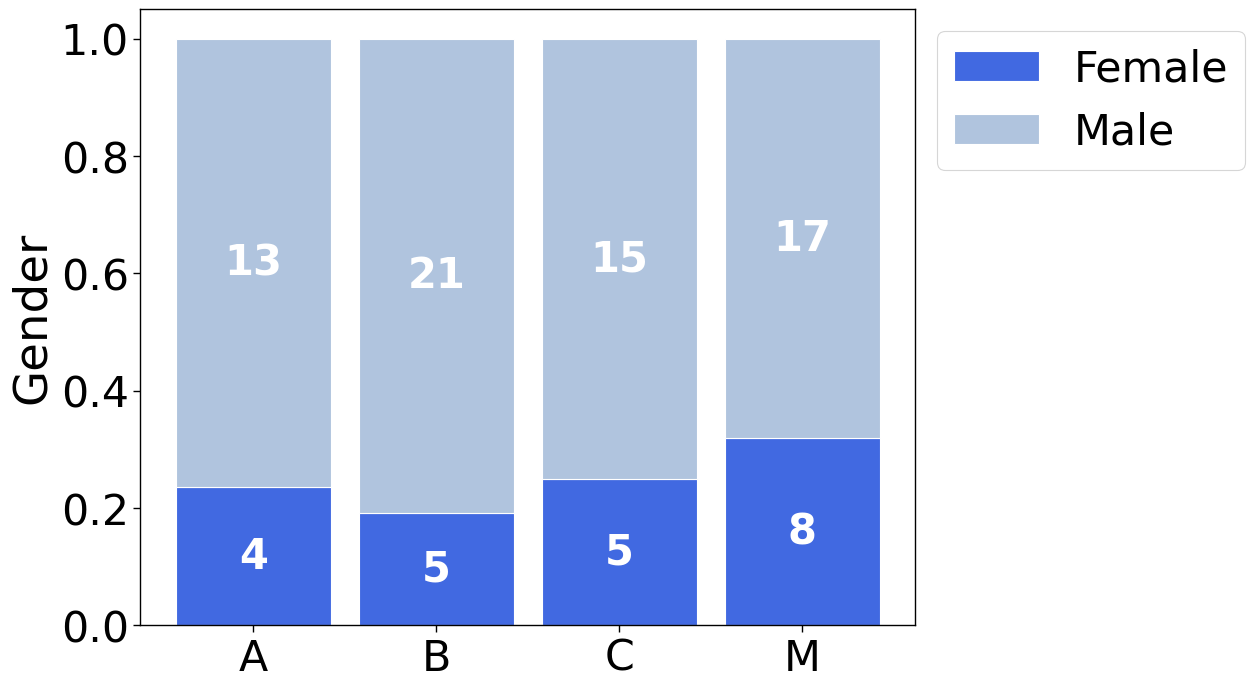

In [72]:
# gender
count_df = pd.crosstab(df['CLASS'],df['GENDER'])
percent_df = count_df.apply(lambda x: x/x.sum(),axis=1).round(4)


types = ['Female','Male']
a = percent_df['Female']
b = percent_df['Male']

sns.reset_defaults()
sns.set_context("paper", font_scale=3.5)

plt.figure(figsize=(10,8))
barWidth = 0.85
names = ('A','B','C','M')
ax1 = plt.bar(names, a, color='royalblue', edgecolor='white', width=barWidth, label='Female')
ax2 = plt.bar(names, b, bottom=a, color='lightsteelblue', edgecolor='white', width=barWidth, label='Male')

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Gender")
# add text
for idx, (r1, r2) in enumerate(zip(ax1, ax2)):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h1_v = count_df['Female'][idx]
    h2_v = count_df['Male'][idx]
    
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")


plt.savefig('paper_results/1_data_stats/moffitt_gender.png',dpi=150,format="png",bbox_inches = 'tight')
plt.show()

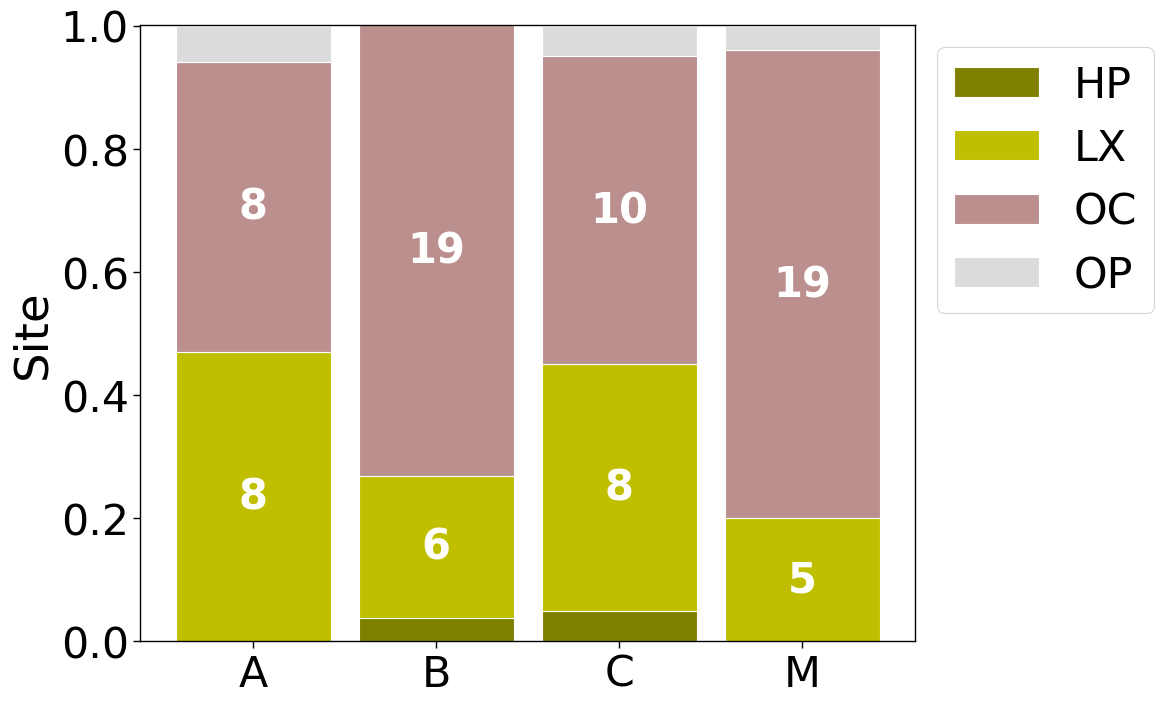

In [74]:
# site
count_df = pd.crosstab(df['CLASS'],df['SITE'])
percent_df = count_df.apply(lambda x: x/x.sum(),axis=1).round(4)

types = ['HP','LX','OC','OP']
a = percent_df['HP']
b = percent_df['LX']
c = percent_df['OC']
d = percent_df['OP']

sns.reset_defaults()
sns.set_context("paper", font_scale=3.5)

plt.figure(figsize=(10,8))
barWidth = 0.85
names = ('A','B','C','M')
ax1 = plt.bar(names, a, color='olive', edgecolor='white', width=barWidth, label='HP')
ax2 = plt.bar(names, b, bottom=a, color='y', edgecolor='white', width=barWidth, label='LX')
ax3 = plt.bar(names, c, bottom=[i+j for i,j in zip(a, b)], 
        color='rosybrown', edgecolor='white', width=barWidth, label='OC')
ax4 = plt.bar(names, d, bottom=[i+j+k for i,j,k in zip(a, b, c)], 
        color='gainsboro', edgecolor='white', width=barWidth,label='OP')


plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Site")
# add text
for idx, (r1, r2, r3, r4) in enumerate(zip(ax1, ax2, ax3,ax4)):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    h4 = r4.get_height()
    h1_v = count_df['HP'][idx]
    h2_v = count_df['LX'][idx]
    h3_v = count_df['OC'][idx]
    h4_v = count_df['OP'][idx]
    
#     plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1_v, 
#              ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 + h3 / 2., "%d" % h3_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
#     plt.text(r4.get_x() + r4.get_width() / 2., h1 + h2 + h3 + h4 / 2., "%d" % h4_v, 
#              ha="center", va="center", color="white", fontsize=30, fontweight="bold")


plt.savefig('paper_results/1_data_stats/moffitt_site.png',dpi=150,format="png",bbox_inches = 'tight')
plt.show()

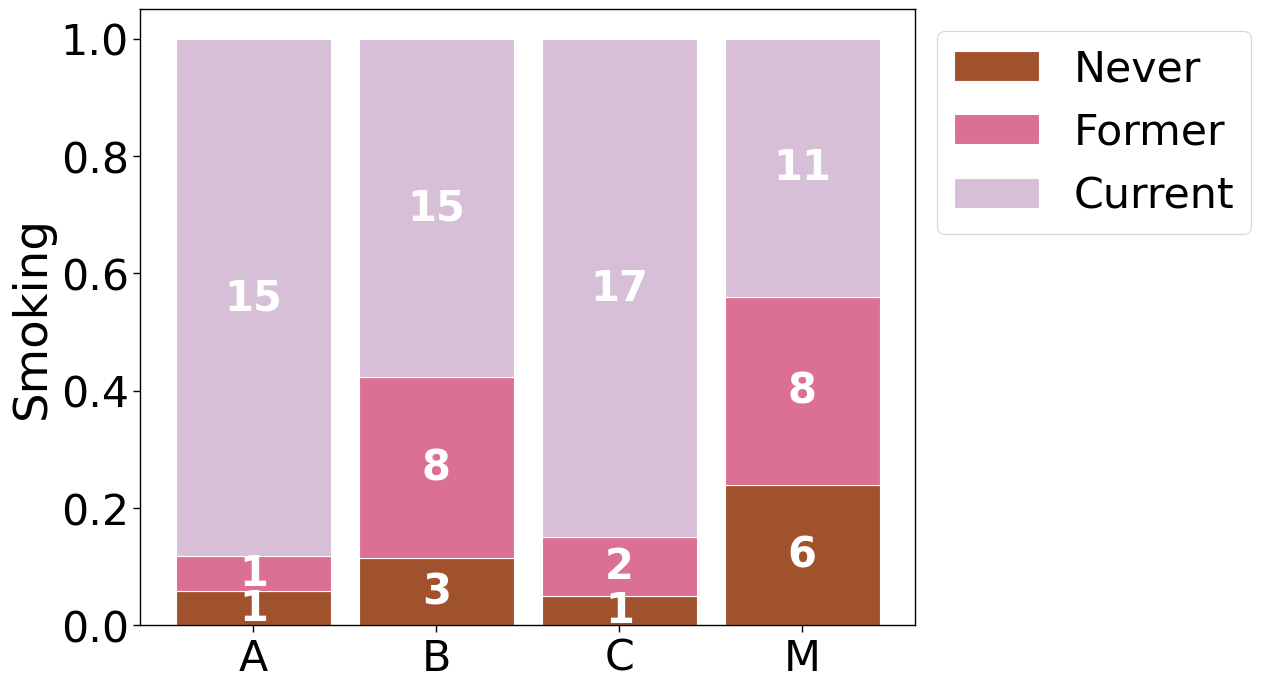

In [76]:
# smoking

count_df = pd.crosstab(df['CLASS'],df['SMOKING'])
percent_df = count_df.apply(lambda x: x/x.sum(),axis=1).round(4)

types = ['Never','Former','Current']
a = percent_df['Never']
b = percent_df['Former']
c = percent_df['Current']

sns.reset_defaults()
sns.set_context("paper", font_scale=3.5)

plt.figure(figsize=(10,8))
barWidth = 0.85
names = ('A','B','C','M')
ax1 = plt.bar(names, a, color='sienna', edgecolor='white', width=barWidth, label='Never')
ax2 = plt.bar(names, b, bottom=a, color='palevioletred', edgecolor='white', width=barWidth, label='Former')
ax3 = plt.bar(names, c, bottom=[i+j for i,j in zip(a, b)], 
        color='thistle', edgecolor='white', width=barWidth, label='Current')

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Smoking")
# add text
for idx, (r1, r2, r3) in enumerate(zip(ax1, ax2, ax3)):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    h1_v = count_df['Never'][idx]
    h2_v = count_df['Former'][idx]
    h3_v = count_df['Current'][idx]

    
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 + h3 / 2., "%d" % h3_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")


plt.savefig('paper_results/1_data_stats/moffitt_smoking.png',dpi=150,format="png",bbox_inches = 'tight')
plt.show()

In [78]:
# stage
df_clinical = pd.ExcelFile('background/HNSCC_TMA1_CLINICAL_INFO.xlsx',engine='openpyxl')
df_clinical = pd.read_excel(df_clinical, 'Sheet1',index_col=None, header=0)
df_clinical = df_clinical.dropna(subset=['SLID.RNA'])
stage_map = dict(zip(df_clinical['SLID.RNA'],df_clinical['STAGE']))

In [79]:
df['STAGE'] = df['SLID.RNA'].map(stage_map)
df = df[df['SLID.RNA'].isin(hpv_neg)]

<ipython-input-79-7cf24e3801dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['STAGE'] = df['SLID.RNA'].map(stage_map)


In [80]:
count_df = pd.crosstab(df['CLASS'],df['STAGE'])
percent_df = count_df.apply(lambda x: x/x.sum(),axis=1).round(4)

In [81]:
count_df

STAGE        1.0  2.0  3.0  4.0
CLASS                          
Atypical       0    2    1    8
Basal          1    2    1   15
Classical      1    2    2    8
Mesenchymal    1    1    6   11

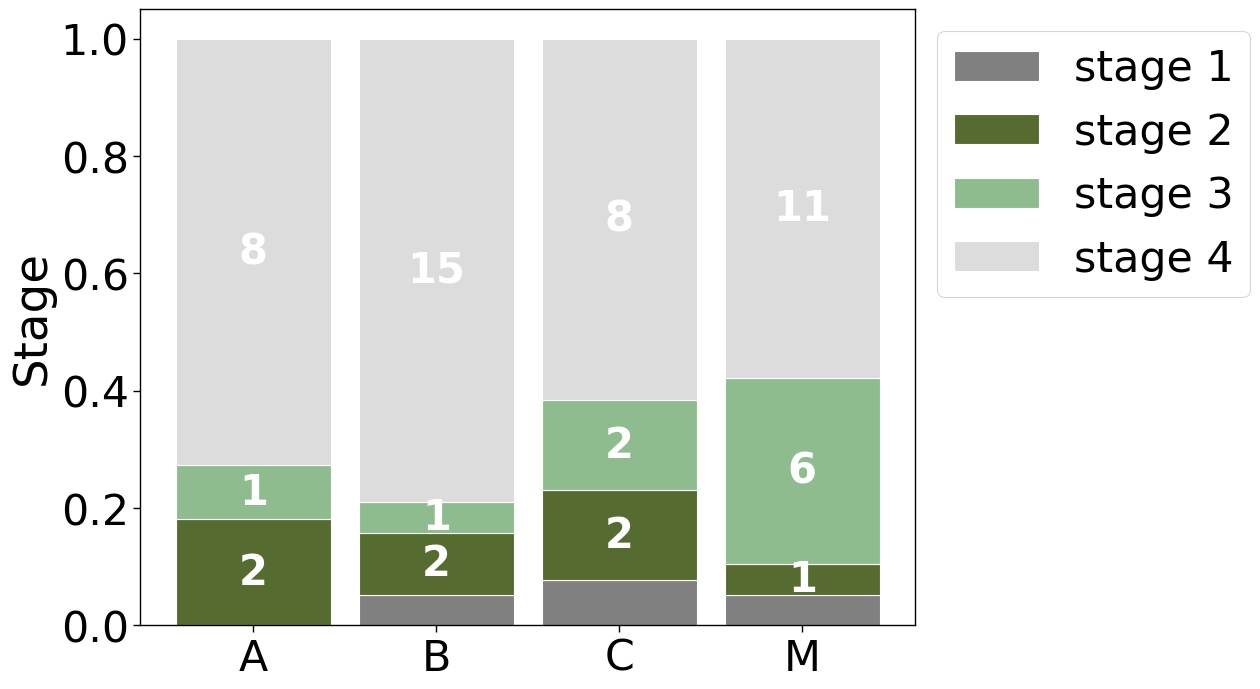

In [83]:
types = [1,2,3,4]
a = percent_df[1]
b = percent_df[2]
c = percent_df[3]
d = percent_df[4]

sns.reset_defaults()
sns.set_context("paper", font_scale=3.5)

plt.figure(figsize=(10,8))
barWidth = 0.85
names = ('A','B','C','M')
ax1 = plt.bar(names, a, color='grey', edgecolor='white', width=barWidth, label='stage 1')
ax2 = plt.bar(names, b, bottom=a, color='darkolivegreen', edgecolor='white', width=barWidth, label='stage 2')
ax3 = plt.bar(names, c, bottom=[i+j for i,j in zip(a, b)], 
        color='darkseagreen', edgecolor='white', width=barWidth, label='stage 3')
ax4 = plt.bar(names, d, bottom=[i+j+k for i,j,k in zip(a, b, c)], 
        color='gainsboro', edgecolor='white', width=barWidth,label='stage 4')


plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Stage")
# add text
for idx, (r1, r2, r3, r4) in enumerate(zip(ax1, ax2, ax3,ax4)):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    h4 = r4.get_height()
    h1_v = count_df[1][idx]
    h2_v = count_df[2][idx]
    h3_v = count_df[3][idx]
    h4_v = count_df[4][idx]
    
#     plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1_v, 
#              ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 + h3 / 2., "%d" % h3_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r4.get_x() + r4.get_width() / 2., h1 + h2 + h3 + h4 / 2., "%d" % h4_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")


plt.savefig('paper_results/1_data_stats/moffitt_stage.png',dpi=150,format="png",bbox_inches = 'tight')
plt.show()

3. composition of TCGA cohort. Need to clean up the format and some of the values.
    * subtype
    * gender
    * tumor site: make a dict to change the name
    * smoking
    * stage(change to grade): for the stage, need to use a different file `HNSCC_TMA1_CLINICAL_INFO`, make a dict of `SLID.RNA : STAGE` and map back to the `TMA1_fulltable_4AC_20210126_RC` table
    
    

In [21]:
# class assignment for TCGA cohort
with open('paper_results/helpers/tcga_class_by_correlation.json', 'r') as fp:
    res_correlation = json.load(fp)
    
# HPV status annotation
path = 'hnsc_tcga_pan_can_atlas_2018_clinical_data.tsv'
anno = pd.read_csv(path,sep='\t')
hpv_neg = anno[anno['Subtype']=='HNSC_HPV-']['Sample ID'].to_list()

In [56]:
df = pd.read_csv('TCGA_HNSC/TCGA-HNSC_corale_clinical.txt',sep='\t',index_col=0).T
df.index = df.index + '-01'
# clean up values of some fields
df = df.replace('na', np.nan)
df = df.replace('female', 'Female')
df = df.replace('male', 'Male')
df = df.replace('oral cavity', 'OC')
df = df.replace('larynx', 'LX')
df = df.replace('oropharynx', 'OP')
df = df.replace('hypopharynx', 'HP')
df = df.replace('hypopharynx', 'HP')
df['smoker'] = df['smoker'].replace({'yes':'Current','no':'Never','former':'Former'})
df['grade'] = df['grade'].replace({'1':1,'2':2,'3':3,'4':4})
df = df[['grade','sex','tumor_site','smoker']]
df = df[df.index.isin(hpv_neg)]
df.columns = ['STAGE','GENDER','SITE','SMOKING']
# df = pd.read_excel(df, 'TMA1_fulltable_20210126',index_col=None, header=0)
# df = df.dropna(subset=['SLID.RNA'])
df['CLASS'] = df.index.map(res_correlation)

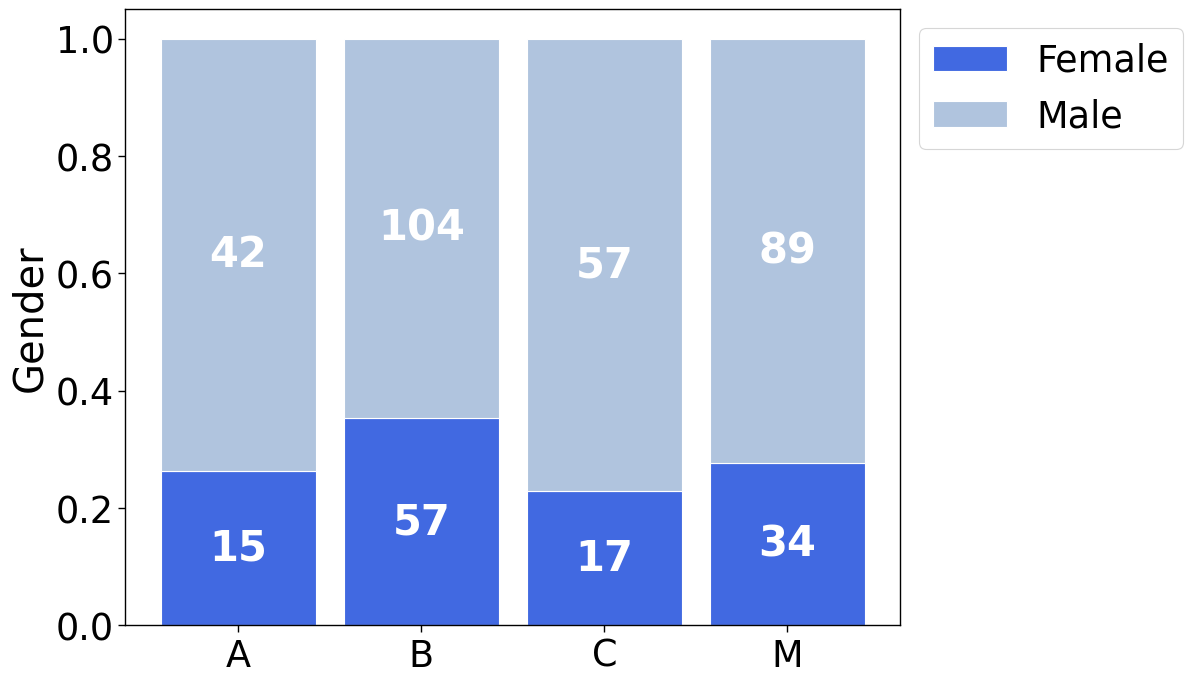

In [38]:
# gender
count_df = pd.crosstab(df['CLASS'],df['GENDER'])
percent_df = count_df.apply(lambda x: x/x.sum(),axis=1).round(4)


types = ['Female','Male']
a = percent_df['Female']
b = percent_df['Male']

sns.reset_defaults()
sns.set_context("paper", font_scale=3)

plt.figure(figsize=(10,8))
barWidth = 0.85
names = ('A','B','C','M')
ax1 = plt.bar(names, a, color='royalblue', edgecolor='white', width=barWidth, label='Female')
ax2 = plt.bar(names, b, bottom=a, color='lightsteelblue', edgecolor='white', width=barWidth, label='Male')

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Gender")
# add text
for idx, (r1, r2) in enumerate(zip(ax1, ax2)):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h1_v = count_df['Female'][idx]
    h2_v = count_df['Male'][idx]
    
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")


plt.savefig('paper_results/1_data_stats/TCGA_gender.png',dpi=150,format="png",bbox_inches = 'tight')
plt.show()

In [44]:
count_df = pd.crosstab(df['CLASS'],df['SITE'])
percent_df = count_df.apply(lambda x: x/x.sum(),axis=1).round(4)

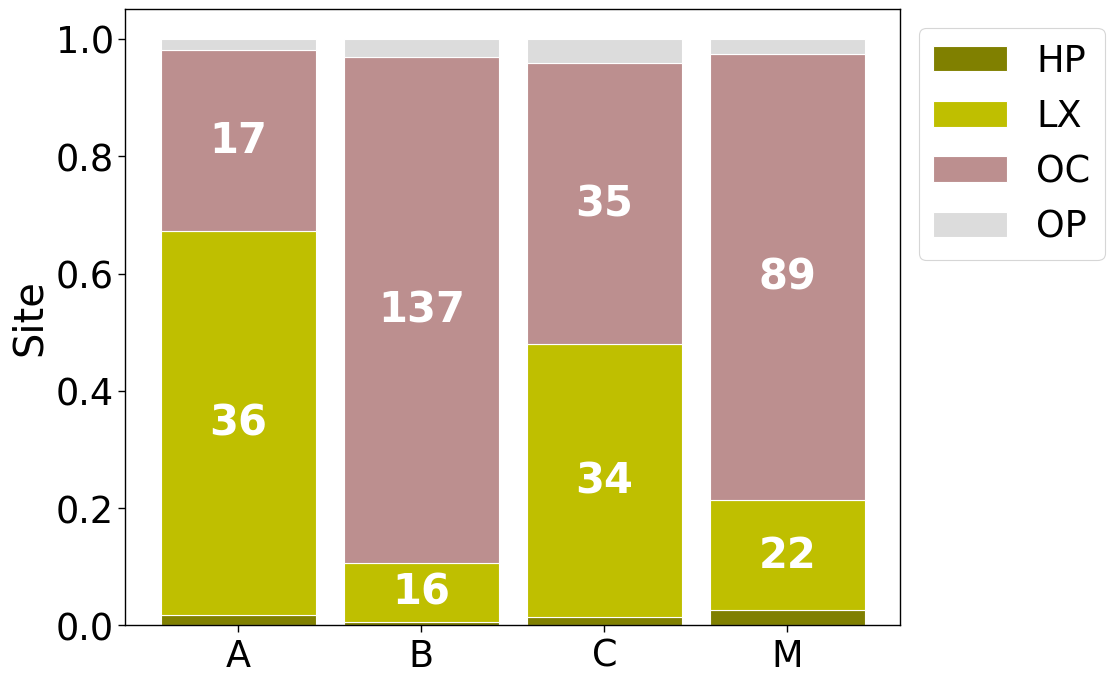

In [46]:
# site
types = ['HP','LX','OC','OP']
a = percent_df['HP']
b = percent_df['LX']
c = percent_df['OC']
d = percent_df['OP']

sns.reset_defaults()
sns.set_context("paper", font_scale=3)

plt.figure(figsize=(10,8))
barWidth = 0.85
names = ('A','B','C','M')
ax1 = plt.bar(names, a, color='olive', edgecolor='white', width=barWidth, label='HP')
ax2 = plt.bar(names, b, bottom=a, color='y', edgecolor='white', width=barWidth, label='LX')
ax3 = plt.bar(names, c, bottom=[i+j for i,j in zip(a, b)], 
        color='rosybrown', edgecolor='white', width=barWidth, label='OC')
ax4 = plt.bar(names, d, bottom=[i+j+k for i,j,k in zip(a, b, c)], 
        color='gainsboro', edgecolor='white', width=barWidth,label='OP')


plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Site")
# add text
for idx, (r1, r2, r3, r4) in enumerate(zip(ax1, ax2, ax3,ax4)):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    h4 = r4.get_height()
    h1_v = count_df['HP'][idx]
    h2_v = count_df['LX'][idx]
    h3_v = count_df['OC'][idx]
    h4_v = count_df['OP'][idx]
    
#     plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1_v, 
#              ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 + h3 / 2., "%d" % h3_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
#     plt.text(r4.get_x() + r4.get_width() / 2., h1 + h2 + h3 + h4 / 2., "%d" % h4_v, 
#              ha="center", va="center", color="white", fontsize=30, fontweight="bold")


plt.savefig('paper_results/1_data_stats/TCGA_site.png',dpi=150,format="png",bbox_inches = 'tight')
plt.show()

In [50]:
count_df = pd.crosstab(df['CLASS'],df['SMOKING'])
percent_df = count_df.apply(lambda x: x/x.sum(),axis=1).round(4)

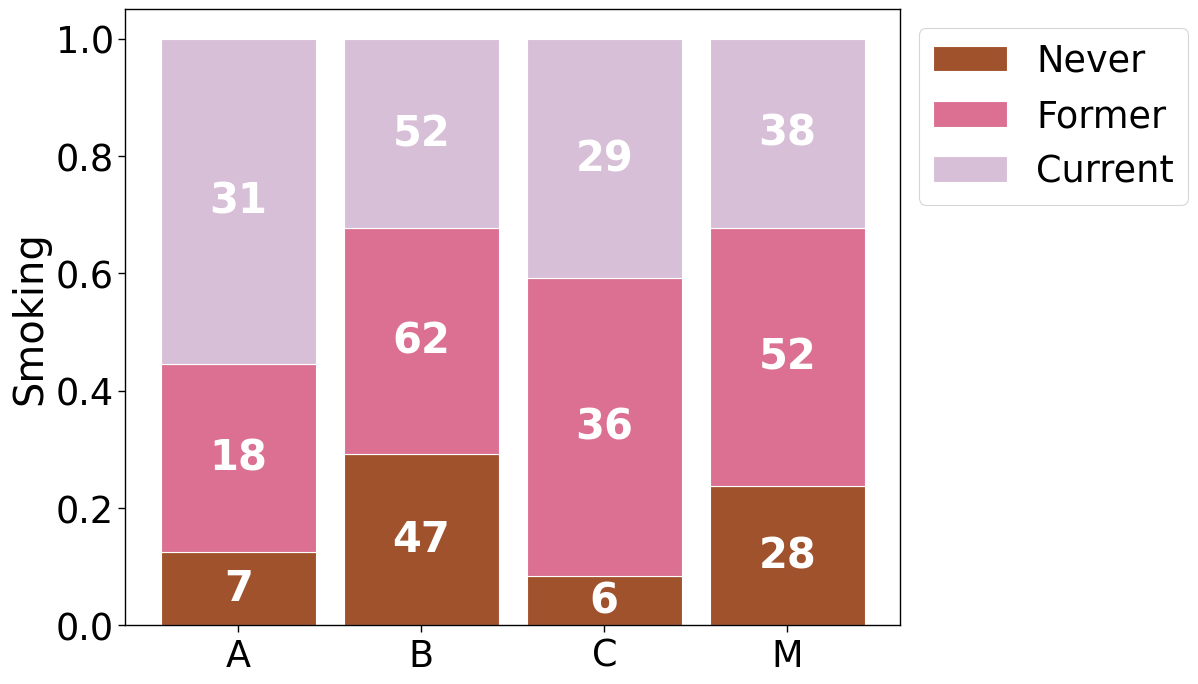

In [52]:
# smoking
types = ['Never','Former','Current']
a = percent_df['Never']
b = percent_df['Former']
c = percent_df['Current']

sns.reset_defaults()
sns.set_context("paper", font_scale=3)

plt.figure(figsize=(10,8))
barWidth = 0.85
names = ('A','B','C','M')
ax1 = plt.bar(names, a, color='sienna', edgecolor='white', width=barWidth, label='Never')
ax2 = plt.bar(names, b, bottom=a, color='palevioletred', edgecolor='white', width=barWidth, label='Former')
ax3 = plt.bar(names, c, bottom=[i+j for i,j in zip(a, b)], 
        color='thistle', edgecolor='white', width=barWidth, label='Current')

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Smoking")
# add text
for idx, (r1, r2, r3) in enumerate(zip(ax1, ax2, ax3)):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    h1_v = count_df['Never'][idx]
    h2_v = count_df['Former'][idx]
    h3_v = count_df['Current'][idx]

    
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 + h3 / 2., "%d" % h3_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
#     plt.text(r4.get_x() + r4.get_width() / 2., h1 + h2 + h3 + h4 / 2., "%d" % h4_v, 
#              ha="center", va="center", color="white", fontsize=30, fontweight="bold")


plt.savefig('paper_results/1_data_stats/TCGA_smoking.png',dpi=150,format="png",bbox_inches = 'tight')
plt.show()

In [57]:
count_df = pd.crosstab(df['CLASS'],df['STAGE'])
percent_df = count_df.apply(lambda x: x/x.sum(),axis=1).round(4)

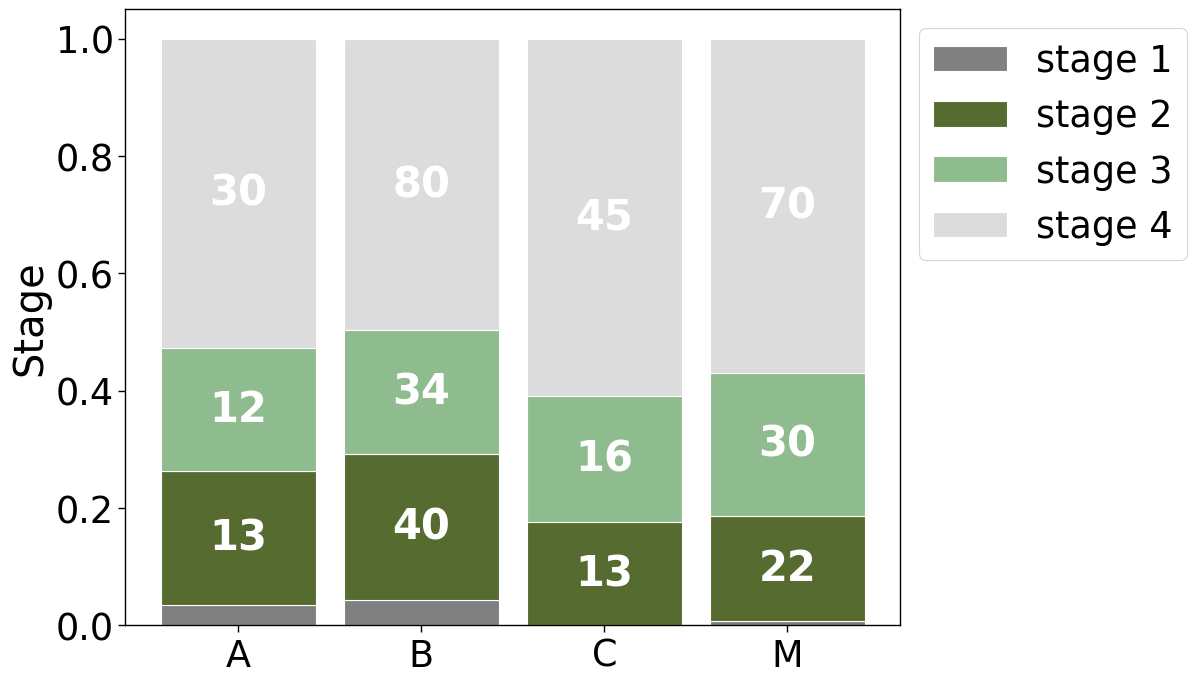

In [59]:
types = [1,2,3,4]
a = percent_df[1]
b = percent_df[2]
c = percent_df[3]
d = percent_df[4]

sns.reset_defaults()
sns.set_context("paper", font_scale=3)

plt.figure(figsize=(10,8))
barWidth = 0.85
names = ('A','B','C','M')
ax1 = plt.bar(names, a, color='grey', edgecolor='white', width=barWidth, label='stage 1')
ax2 = plt.bar(names, b, bottom=a, color='darkolivegreen', edgecolor='white', width=barWidth, label='stage 2')
ax3 = plt.bar(names, c, bottom=[i+j for i,j in zip(a, b)], 
        color='darkseagreen', edgecolor='white', width=barWidth, label='stage 3')
ax4 = plt.bar(names, d, bottom=[i+j+k for i,j,k in zip(a, b, c)], 
        color='gainsboro', edgecolor='white', width=barWidth,label='stage 4')


plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Stage")
# add text
for idx, (r1, r2, r3, r4) in enumerate(zip(ax1, ax2, ax3,ax4)):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    h4 = r4.get_height()
    h1_v = count_df[1][idx]
    h2_v = count_df[2][idx]
    h3_v = count_df[3][idx]
    h4_v = count_df[4][idx]
    
#     plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1_v, 
#              ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 + h3 / 2., "%d" % h3_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r4.get_x() + r4.get_width() / 2., h1 + h2 + h3 + h4 / 2., "%d" % h4_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")


plt.savefig('paper_results/1_data_stats/TCGA_stage.png',dpi=150,format="png",bbox_inches = 'tight')
plt.show()

4. composition of CPTAC cohort. Use CORALE clinical data
    * subtype
    * gender
    * tumor site: make a dict to change the name
    * smoking
    * stage(change to grade)
    


In [60]:
# class assignment for TCGA cohort
with open('paper_results/helpers/cptac_class_by_correlation.json', 'r') as fp:
    res_correlation = json.load(fp)

In [80]:
df = pd.read_csv('cptac_hnsc_processed/CPTAC_corale_clinical.txt',sep='\t',index_col=0).T
# clean up values of some fields
df = df.replace('na', np.nan)
df = df.replace('female', 'Female')
df = df.replace('male', 'Male')
df = df.replace('oral cavity', 'OC')
df = df.replace('larynx', 'LX')
df = df.replace('oropharynx', 'OP')
df = df.replace('hypopharynx', 'HP')
df['smoker'] = df['smoker'].replace({'yes':'Current','no':'Never','former':'Former'})
df['grade'] = df['grade'].replace({'1':1,'2':2,'3':3,'4':4})
df = df[['grade','sex','site','smoker']]
df.columns = ['STAGE','GENDER','SITE','SMOKING']
# df = pd.read_excel(df, 'TMA1_fulltable_20210126',index_col=None, header=0)
# df = df.dropna(subset=['SLID.RNA'])
df['CLASS'] = df.index.map(res_correlation)

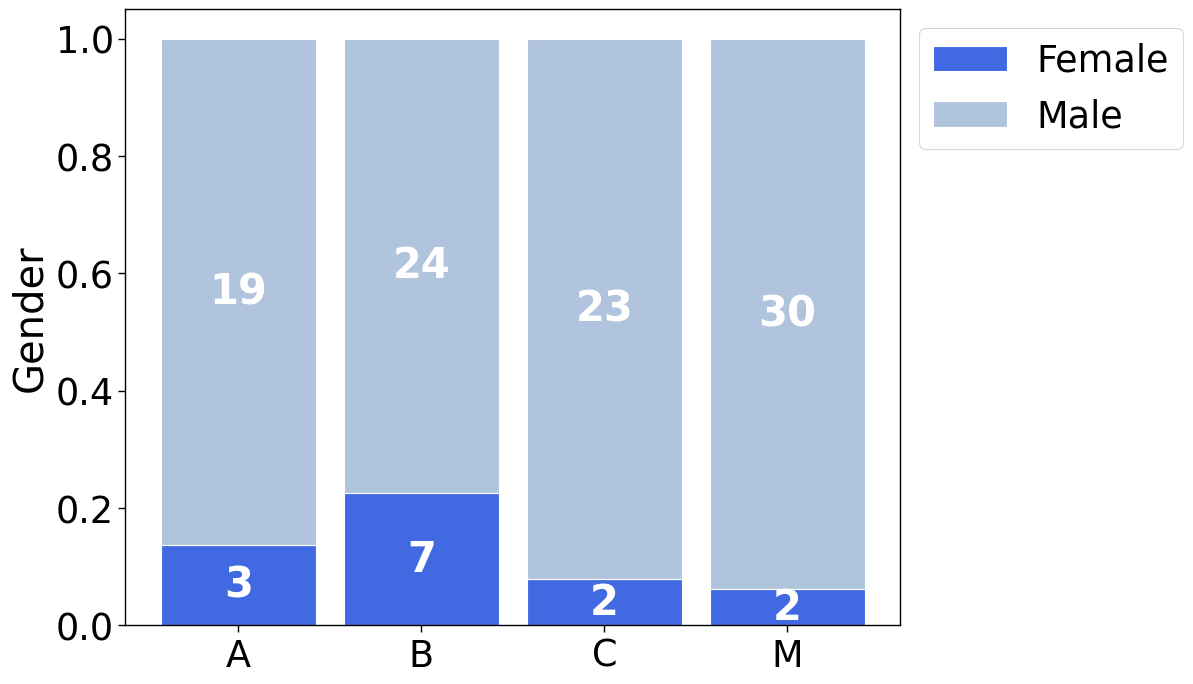

In [77]:
# gender
count_df = pd.crosstab(df['CLASS'],df['GENDER'])
percent_df = count_df.apply(lambda x: x/x.sum(),axis=1).round(4)


types = ['Female','Male']
a = percent_df['Female']
b = percent_df['Male']

sns.reset_defaults()
sns.set_context("paper", font_scale=3)

plt.figure(figsize=(10,8))
barWidth = 0.85
names = ('A','B','C','M')
ax1 = plt.bar(names, a, color='royalblue', edgecolor='white', width=barWidth, label='Female')
ax2 = plt.bar(names, b, bottom=a, color='lightsteelblue', edgecolor='white', width=barWidth, label='Male')

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Gender")
# add text
for idx, (r1, r2) in enumerate(zip(ax1, ax2)):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h1_v = count_df['Female'][idx]
    h2_v = count_df['Male'][idx]
    
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")


plt.savefig('paper_results/1_data_stats/CPTAC_gender.png',dpi=150,format="png",bbox_inches = 'tight')
plt.show()

In [78]:
count_df = pd.crosstab(df['CLASS'],df['SITE'])
percent_df = count_df.apply(lambda x: x/x.sum(),axis=1).round(4)

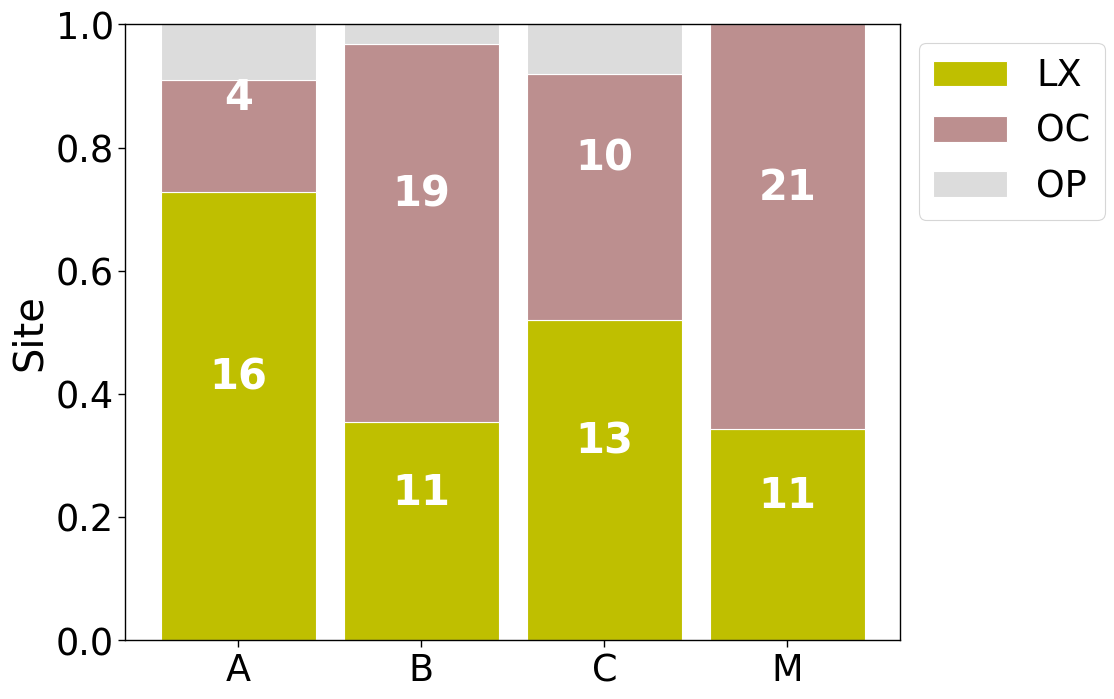

In [83]:
# site
types = ['HP','LX','OC','OP']
# a = percent_df['HP']
b = percent_df['LX']
c = percent_df['OC']
d = percent_df['OP']

sns.reset_defaults()
sns.set_context("paper", font_scale=3)

plt.figure(figsize=(10,8))
barWidth = 0.85
names = ('A','B','C','M')
# ax1 = plt.bar(names, a, color='olive', edgecolor='white', width=barWidth, label='HP')
ax2 = plt.bar(names, b, color='y', edgecolor='white', width=barWidth, label='LX')
ax3 = plt.bar(names, c, bottom=b, 
        color='rosybrown', edgecolor='white', width=barWidth, label='OC')
ax4 = plt.bar(names, d, bottom=[j+k for j,k in zip(b, c)], 
        color='gainsboro', edgecolor='white', width=barWidth,label='OP')


plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Site")
# add text
for idx, (r2, r3, r4) in enumerate(zip(ax2, ax3,ax4)):
#     h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    h4 = r4.get_height()
#     h1_v = count_df['HP'][idx]
    h2_v = count_df['LX'][idx]
    h3_v = count_df['OC'][idx]
    h4_v = count_df['OP'][idx]
    
#     plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1_v, 
#              ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 + h3 / 2., "%d" % h3_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
#     plt.text(r4.get_x() + r4.get_width() / 2., h1 + h2 + h3 + h4 / 2., "%d" % h4_v, 
#              ha="center", va="center", color="white", fontsize=30, fontweight="bold")


plt.savefig('paper_results/1_data_stats/CPTAC_site.png',dpi=150,format="png",bbox_inches = 'tight')
plt.show()

In [84]:
count_df = pd.crosstab(df['CLASS'],df['SMOKING'])
percent_df = count_df.apply(lambda x: x/x.sum(),axis=1).round(4)

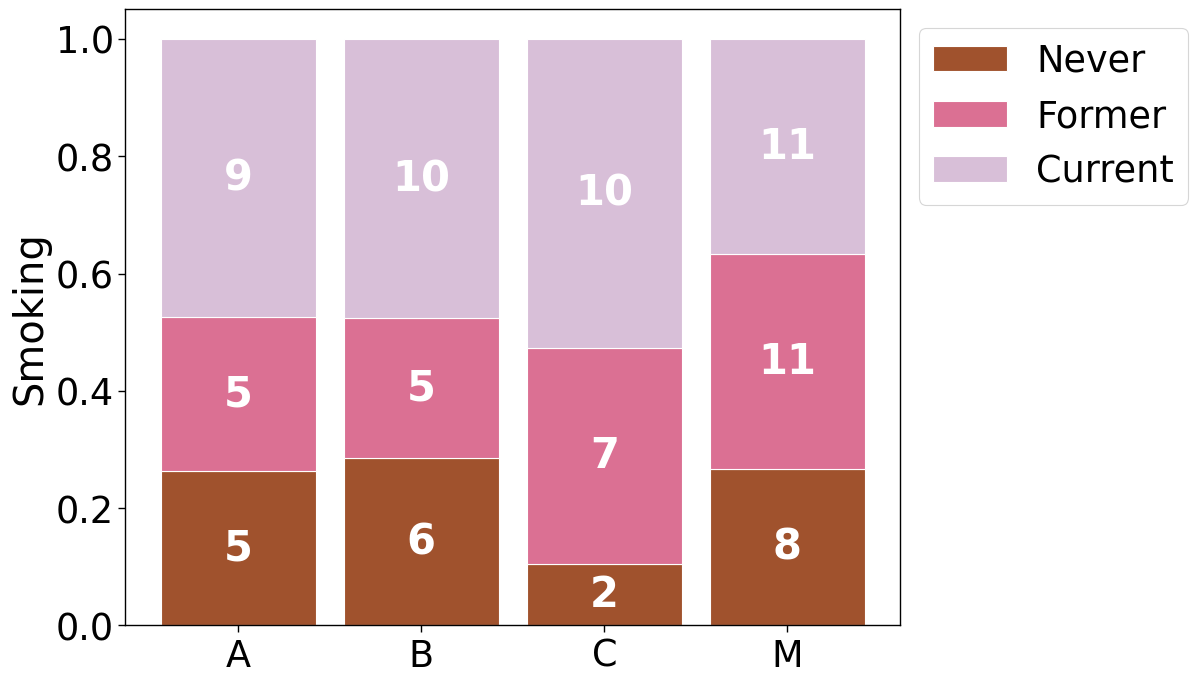

In [85]:
# smoking
types = ['Never','Former','Current']
a = percent_df['Never']
b = percent_df['Former']
c = percent_df['Current']

sns.reset_defaults()
sns.set_context("paper", font_scale=3)

plt.figure(figsize=(10,8))
barWidth = 0.85
names = ('A','B','C','M')
ax1 = plt.bar(names, a, color='sienna', edgecolor='white', width=barWidth, label='Never')
ax2 = plt.bar(names, b, bottom=a, color='palevioletred', edgecolor='white', width=barWidth, label='Former')
ax3 = plt.bar(names, c, bottom=[i+j for i,j in zip(a, b)], 
        color='thistle', edgecolor='white', width=barWidth, label='Current')

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Smoking")
# add text
for idx, (r1, r2, r3) in enumerate(zip(ax1, ax2, ax3)):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    h1_v = count_df['Never'][idx]
    h2_v = count_df['Former'][idx]
    h3_v = count_df['Current'][idx]

    
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 + h3 / 2., "%d" % h3_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
#     plt.text(r4.get_x() + r4.get_width() / 2., h1 + h2 + h3 + h4 / 2., "%d" % h4_v, 
#              ha="center", va="center", color="white", fontsize=30, fontweight="bold")


plt.savefig('paper_results/1_data_stats/CPTAC_smoking.png',dpi=150,format="png",bbox_inches = 'tight')
plt.show()

In [86]:
count_df = pd.crosstab(df['CLASS'],df['STAGE'])
percent_df = count_df.apply(lambda x: x/x.sum(),axis=1).round(4)

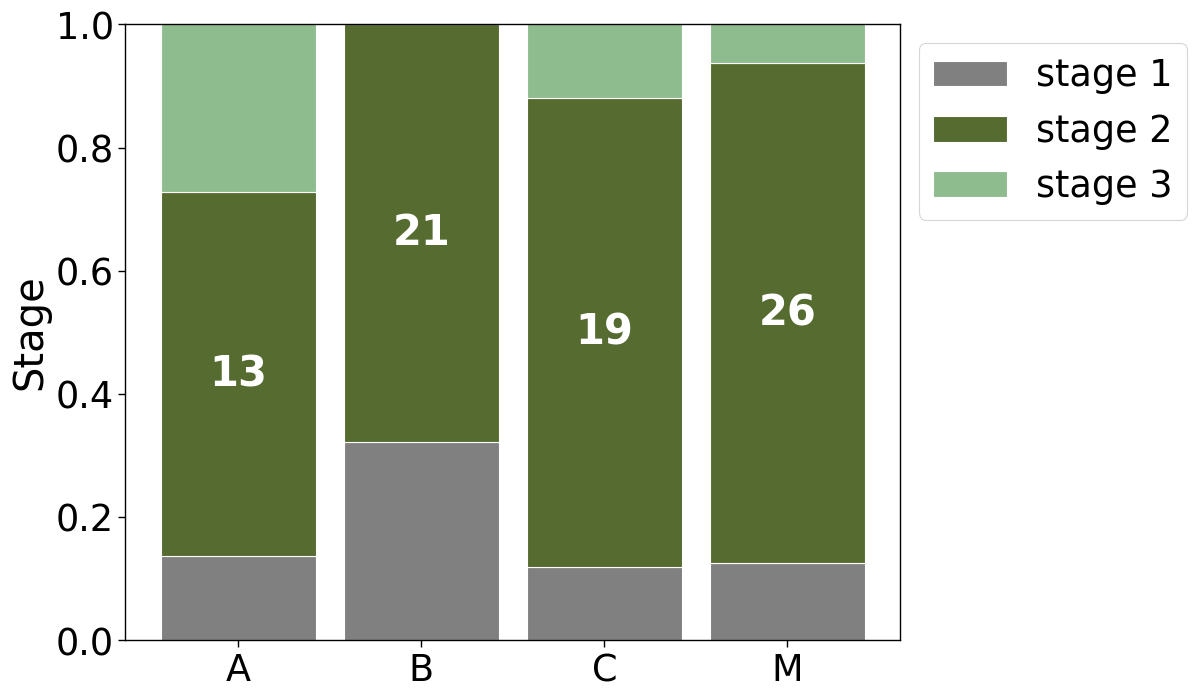

In [90]:
types = [1,2,3,4]
a = percent_df[1]
b = percent_df[2]
c = percent_df[3]
# d = percent_df[4]

sns.reset_defaults()
sns.set_context("paper", font_scale=3)

plt.figure(figsize=(10,8))
barWidth = 0.85
names = ('A','B','C','M')
ax1 = plt.bar(names, a, color='grey', edgecolor='white', width=barWidth, label='stage 1')
ax2 = plt.bar(names, b, bottom=a, color='darkolivegreen', edgecolor='white', width=barWidth, label='stage 2')
ax3 = plt.bar(names, c, bottom=[i+j for i,j in zip(a, b)], 
        color='darkseagreen', edgecolor='white', width=barWidth, label='stage 3')
# ax4 = plt.bar(names, d, bottom=[i+j+k for i,j,k in zip(a, b, c)], 
#         color='gainsboro', edgecolor='white', width=barWidth,label='stage 4')


plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Stage")
# add text
for idx, (r1, r2, r3, r4) in enumerate(zip(ax1, ax2, ax3,ax4)):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
#     h4 = r4.get_height()
    h1_v = count_df[1][idx]
    h2_v = count_df[2][idx]
    h3_v = count_df[3][idx]
#     h4_v = count_df[4][idx]
    
#     plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1_v, 
#              ha="center", va="center", color="white", fontsize=30, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2_v, 
             ha="center", va="center", color="white", fontsize=30, fontweight="bold")
#     plt.text(r3.get_x() + r3.get_width() / 2., h1 + h2 + h3 / 2., "%d" % h3_v, 
#              ha="center", va="center", color="white", fontsize=30, fontweight="bold")
#     plt.text(r4.get_x() + r4.get_width() / 2., h1 + h2 + h3 + h4 / 2., "%d" % h4_v, 
#              ha="center", va="center", color="white", fontsize=30, fontweight="bold")


plt.savefig('paper_results/1_data_stats/CPTAC_stage.png',dpi=150,format="png",bbox_inches = 'tight')
plt.show()

# Figure 1c Immune and Tumor purity score from ESTIMATE

To show different subtypes have different immune score, which is negatively associated with tumor purity.
* Moffitt
* TCGA
* cptac

steps:
1. read in expression data and perform deduplication, drop nan, etc.
2. using rpy2 to perform estimation, save score table to folder.
3. parse .gct file(score table) and extract score.
4. mapping the subtypes
5. plotting.

resource:

* [anova tests in python](https://www.reneshbedre.com/blog/anova.html)
* [pandas replace string](https://stackoverflow.com/questions/28986489/how-to-replace-text-in-a-column-of-a-pandas-dataframe) happens in TCGA cohort sample name, after R processing, `-` turned into `.`, need to change back

In [419]:
%%bash
pip install statsmodels

In [84]:
from cmapPy.pandasGEXpress.parse_gct import parse

In [112]:
def plotting(data,x,y,data_name,order=['A','B','C','M'],sufix=None):
    """
    data: pandas df with subtype name column and selected indicator score
    x: name of subtype name column name
    y: selected indicator score column name
    cluster_method: string, "clustered", "nearest","known"
    order: order of x axis
    """
    fig = plt.gcf()
    fig.set_size_inches(5, 5)
    #sns.set(rc={'figure.figsize':(11.7/1.5,8.27/1.5)})
    #sns.set_context("paper", font_scale=1.5) 
    sns.reset_defaults()
    sns.set_context("paper", font_scale=2)
    order = order
    ax = sns.swarmplot(x=x, y=y, data=data, zorder=0.5, color='blue',
                      order = order)    
    sns.boxplot(x=x, y=y, data=data,order=order,
                 showcaps=False,boxprops={'facecolor':'None'},
                 showfliers=False,whiskerprops={'linewidth':0}, ax=ax)

    ax.set(xlabel='subtypes', ylabel='{0} score'.format(y))
#    ax.set_title(cluster_method)
#    plt.xticks(rotation=90)
    
#     add_stat_annotation(ax, x="clustered", y='hypoxia', data=data,
#                     box_pairs=[('Non-Responder','Responder')],
#                     test='Mann-Whitney', comparisons_correction=None, 
#                     text_format='star', loc='inside', verbose=2)
    if sufix is None:
        save_path = "paper_results/1_estimate_score/{0}_{1}.png".format(y,data_name)
        
    plt.savefig(save_path, format="png",bbox_inches = 'tight')
    plt.show()
    plt.clf()
    
    # adding stats
    model = ols('{0} ~ C({1})'.format(y,x), data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    return anova_table

In [104]:
# plotting scatter plot color coded by subtype
def plotting_scatter(data,data_name,sufix=None):
    
    color_dict = dict({'Atypical':'r',
                  'Basal': 'g',
                  'Classical': 'b',
                   'Mesenchymal': 'y'})
    
    fig = plt.gcf()
    fig.set_size_inches(5, 5)
    sns.reset_defaults()
    sns.set_context("paper", font_scale=2)
    ax = sns.scatterplot(data=score, x="ImmuneScore", y="TumorPurity", hue="class",palette=color_dict, s=40)
    plt.legend(bbox_to_anchor=(1, 1))
    r, p = pearsonr(score['ImmuneScore'], score['TumorPurity'])
    ax.text(.05, .1, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    if sufix is None:
        save_path = "paper_results/1_estimate_score/{0}_correlation.png".format(data_name)
        
    plt.savefig(save_path, format="png",bbox_inches = 'tight')
    plt.show()
    plt.clf()    

### Moffitt cohort

0. produce class assignment tables
1. box plot
2. scatter plot

In [87]:
# produce class assignment tables

def class_table(res_correlation, dataset):
    hpv_neg = pd.read_csv('AVATAR/HPV_neg_list.txt',sep='\t',header=None)[0].to_list()
    res = {'Atypical':[],'Basal':[],'Classical':[],'Mesenchymal':[]}
    for k,v in res_correlation.items():
        if k in hpv_neg:
            res[v].append(k)
    df = pd.DataFrame.from_dict(res,
            orient='index')
    df.to_csv('paper_results/0_tables/{0}_class_assignment.csv'.format(dataset),
                                   index=True,header=None)
    return df

class_table(res_correlation, 'moffitt')

0         1         2         3         4         5   \
Atypical     SL243669  SL250079  SL257986  SL250121  SL257988  SL243736   
Basal        SL243737  SL243718  SL243719  SL257939  SL243720  SL243705   
Classical    SL257959  SL243693  SL243694  SL243729  SL243682  SL243717   
Mesenchymal  SL243681  SL243670  SL243695  SL243657  SL258007  SL243683   

                   6         7         8         9   ...        60        61  \
Atypical     SL243688  SL258003  SL243697  SL243700  ...      None      None   
Basal        SL243672  SL243674  SL243734  SL243724  ...  SL381538  SL381602   
Classical    SL250166  SL243699  SL243711  SL243712  ...      None      None   
Mesenchymal  SL243673  SL250004  SL257989  SL243690  ...  SL365893  SL251067   

                   62        63        64        65        66        67  \
Atypical         None      None      None      None      None      None   
Basal        SL381624  SL381467  SL365888  SL252531  SL252535      None   
Classical        None      None      None      None      None      None   
Mesenchymal  SL252519  SL252528  SL252529  SL252530  SL252536  SL251091   

                   68        69  
Atypical         None      None  
Basal            None      None  
Classical        None      None  
Mesenchymal  SL251092  SL257960  

[4 rows x 70 columns]

In [47]:
# class assignment for moffitt cohort
with open('paper_results/helpers/avatar_class_by_correlation.json', 'r') as fp:
    res_correlation = json.load(fp)

In [95]:
score = pd.read_csv('paper_results/1_estimate_score/Moffitt_estimate_score.csv',index_col=0)
score['class'] = score.index.map(res_correlation)
score['class_short'] = score['class'].map(subtype_rename)
score = score[score.index.isin(hpv_neg)]

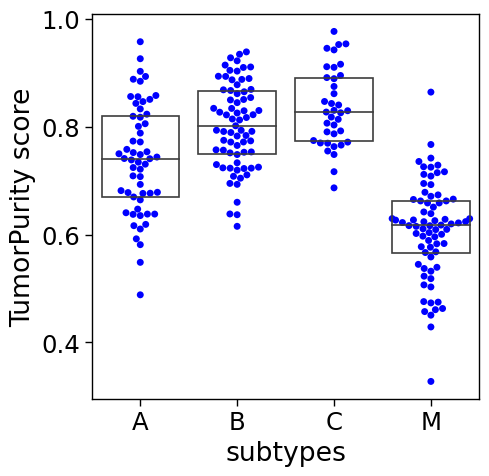

<Figure size 640x480 with 0 Axes>

In [477]:
table = plotting(score,'class_short','TumorPurity','Moffitt')

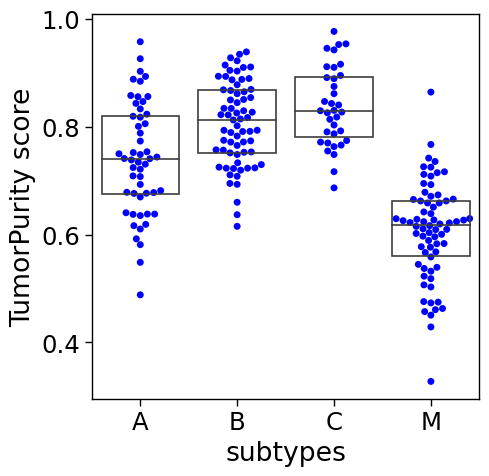

<Figure size 640x480 with 0 Axes>

In [98]:
table = plotting(score,'class_short','TumorPurity','Moffitt')

In [100]:
table

sum_sq     df         F        PR(>F)
C(class_short)  1.851193    3.0  80.24005  4.205758e-35
Residual        1.691850  220.0       NaN           NaN

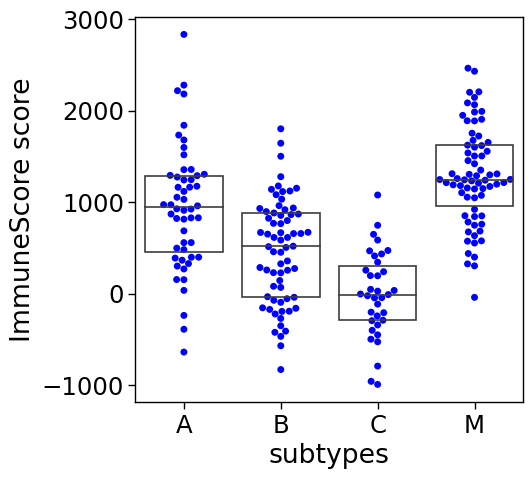

<Figure size 640x480 with 0 Axes>

In [101]:
table = plotting(score,'class_short','ImmuneScore','Moffitt')

In [102]:
table

sum_sq     df          F        PR(>F)
C(class_short)  4.761080e+07    3.0  48.307584  5.028365e-24
Residual        7.227558e+07  220.0        NaN           NaN

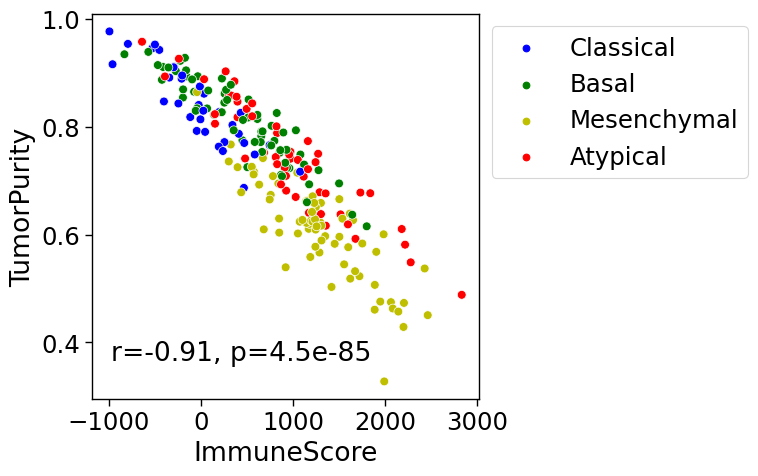

<Figure size 640x480 with 0 Axes>

In [105]:
plotting_scatter(score,'Moffitt',sufix=None)

### TCGA cohort

In [46]:
# produce class assignment tables
def class_table_TCGA(res_correlation, dataset):
    res = {'Atypical':[],'Basal':[],'Classical':[],'Mesenchymal':[]}
    for k,v in res_correlation.items():
        if k in hpv_neg:
            res[v].append(k)
    pd.DataFrame.from_dict(res,
            orient='index').to_csv('paper_results/0_tables/{0}_class_assignment.csv'.format(dataset),
                                   index=True,header=None)
    return

class_table(res_correlation, 'TCGA')

In [106]:
# HPV status annotation
path = 'hnsc_tcga_pan_can_atlas_2018_clinical_data.tsv'
anno = pd.read_csv(path,sep='\t')
hpv_neg = anno[anno['Subtype']=='HNSC_HPV-']['Sample ID'].to_list()

with open('paper_results/helpers/tcga_class_by_correlation.json', 'r') as fp:
    res_correlation = json.load(fp)

In [107]:
score = pd.read_csv('paper_results/1_estimate_score/TCGA_estimate_score.csv',index_col=0)
score['class'] = score.index.map(res_correlation)
score['class_short'] = score['class'].map(subtype_rename)
score = score[score.index.isin(hpv_neg)]

/opt/anaconda3/envs/deconvolution/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


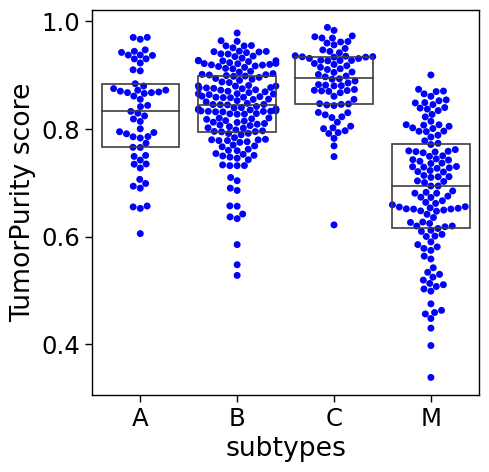

<Figure size 640x480 with 0 Axes>

In [469]:
table = plotting(score,'class_short','TumorPurity','TCGA')

In [470]:
table

sum_sq     df          F        PR(>F)
C(class_short)  2.420542    3.0  92.195679  1.222122e-45
Residual        3.596852  411.0        NaN           NaN

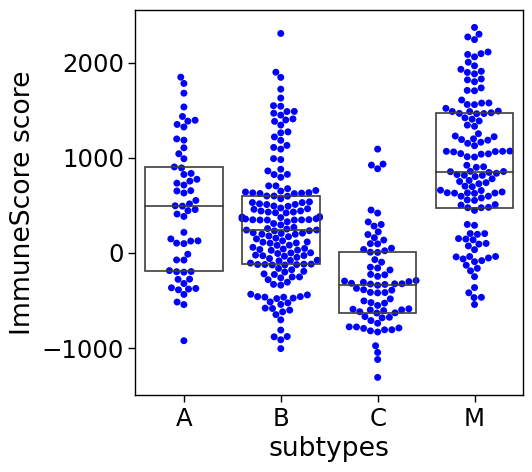

<Figure size 640x480 with 0 Axes>

In [471]:
table = plotting(score,'class_short','ImmuneScore','TCGA')

In [472]:
table

sum_sq     df          F        PR(>F)
C(class_short)  7.045811e+07    3.0  57.911865  3.040145e-31
Residual        1.666802e+08  411.0        NaN           NaN

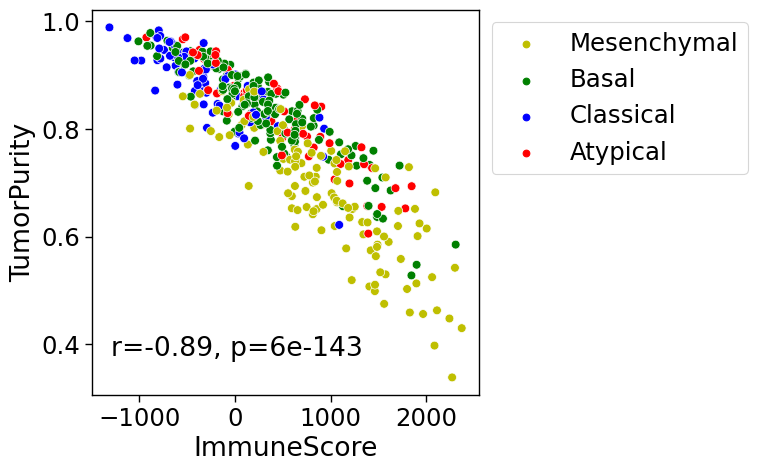

<Figure size 640x480 with 0 Axes>

In [62]:
plotting_scatter(score,'TCGA',sufix=None)

### CPTAC cohort

In [50]:
class_table(res_correlation, 'CPTAC')

In [108]:
with open('paper_results/helpers/cptac_class_by_correlation.json', 'r') as fp:
    res_correlation = json.load(fp)

score = pd.read_csv('paper_results/1_estimate_score/CPTAC_estimate_score.csv',index_col=0)
score['class'] = score.index.map(res_correlation)
score['class_short'] = score['class'].map(subtype_rename)
score = score[score.index.isin(hpv_neg)]

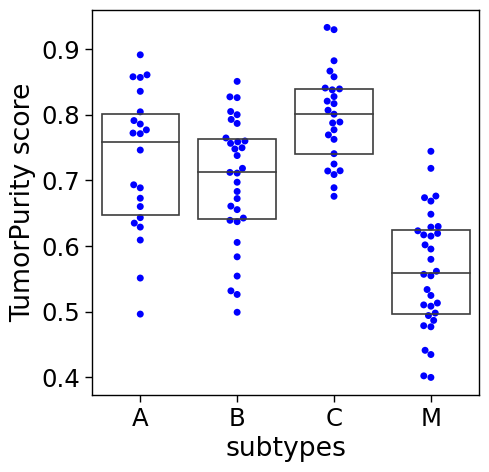

<Figure size 640x480 with 0 Axes>

In [484]:
table = plotting(score,'class_short','TumorPurity','CPTAC')

In [485]:
table

sum_sq     df          F        PR(>F)
C(class_short)  0.836043    3.0  33.471368  2.663076e-15
Residual        0.882551  106.0        NaN           NaN

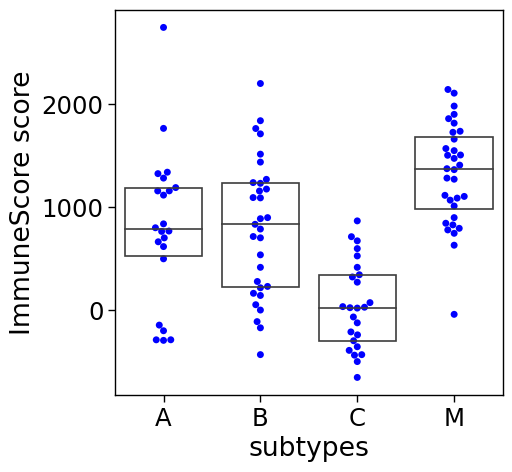

<Figure size 640x480 with 0 Axes>

In [486]:
table = plotting(score,'class_short','ImmuneScore','CPTAC')

In [487]:
table

sum_sq     df          F        PR(>F)
C(class_short)  2.257713e+07    3.0  21.763451  4.655438e-11
Residual        3.665435e+07  106.0        NaN           NaN

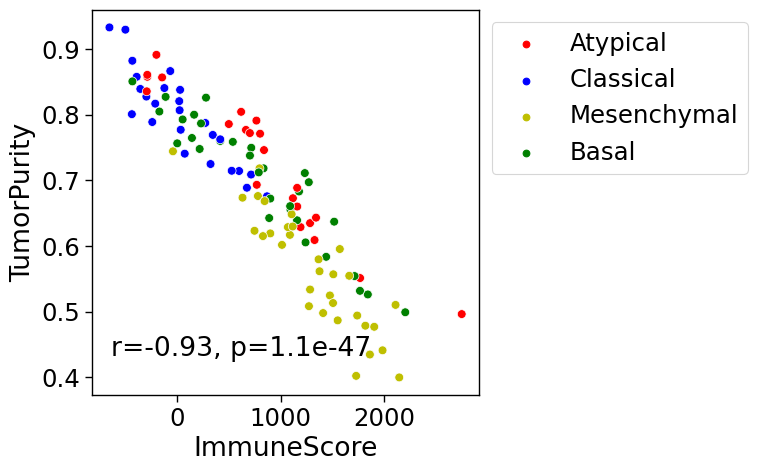

<Figure size 640x480 with 0 Axes>

In [70]:
plotting_scatter(score,'CPTAC',sufix=None)

# Figure 1d Survival plot of different subtypes

* Moffitt: using `HNSCC_TMA1_CLINICAL_INFO` table to map to the subtypes and plot for survival infomation
* TCGA: using `data_clinical_patient`, filter out HPV+ samples, then assign subtypes. clean up the OS status annotations. 
* CPTAC: Using `clinical_combined` table, `vital_status` for status, `days_to_last_follow_up` for time(remove rows that contains negative value and divided by 30). mapping for the subtype and plot KM.

resource: 

* [lifelines documentation: KM stats](https://lifelines.readthedocs.io/en/latest/fitters/univariate/KaplanMeierFitter.html#lifelines.fitters.kaplan_meier_fitter.KaplanMeierFitter)
* [lifelines documentation: plot](https://lifelines.readthedocs.io/en/latest/fitters/univariate/KaplanMeierFitter.html#lifelines.fitters.kaplan_meier_fitter.KaplanMeierFitter.plot)
* [a nice survival analysis(KM, Logrank, CoxPH) blog with python code example](https://www.kdnuggets.com/2020/07/guide-survival-analysis-python-part-3.html)

In [39]:
from lifelines import KaplanMeierFitter
from lifelines import statistics

def survival_plot(df_clinical, status,time, ci_show,loc,data_name,bbox_to_anchor=(0.6, 1),plot_p=False):
    sns.set_context("paper", font_scale=2)
    kmf = KaplanMeierFitter() 


    T = df_clinical[time].values     ## time to event
    E = df_clinical[status].values   ## event occurred or censored


    groups = df_clinical['class']  ## Create the cohorts from the 'Contract' column
    ix1 = (groups == 'Atypical')   ## Cohort 1
    ix2 = (groups == 'Basal')      ## Cohort 2 
    ix3 = (groups == 'Classical')   
    ix4 = (groups == 'Mesenchymal')

    kmf.fit(T[ix1], E[ix1], label='A')    ## fit the cohort 1 data
    ax = kmf.plot(ci_show=ci_show,loc=loc,color='r')


    kmf.fit(T[ix2], E[ix2], label='B')         ## fit the cohort 2 data
    ax1 = kmf.plot(ax=ax,ci_show=ci_show,loc=loc,color='g')


    kmf.fit(T[ix3], E[ix3], label='C')   
    ax2 = kmf.plot(ax=ax1,ci_show=ci_show,loc=loc,color='b')    ## fit the cohort 3 data

    kmf.fit(T[ix4], E[ix4], label='M')
    #ax3 = kmf.plot(ax=ax2)

    kmf.plot(ax=ax2,ci_show=ci_show,loc=loc,color='y',figsize=(5,5)).legend(bbox_to_anchor=bbox_to_anchor)
    ax.set_title(data_name)

    # multivariant logrank test
    # set t_0 = 60 to only using the 5 year for the test
    stat = statistics.multivariate_logrank_test(df_clinical[time], df_clinical['class'], df_clinical[status],t_0=60.)
    if plot_p:
        plt.text(20, 0.15, "p value: {0}".format(round(stat.p_value,4)), 
             ha="center", va="center", color="black", fontsize=10, fontweight="bold")
    
    save_path = "paper_results/1_survival/{0}.png".format(data_name)
    plt.savefig(save_path, format="png",bbox_inches = 'tight')
    plt.show()
    plt.clf()
    
    return round(stat.p_value,4)

### Moffitt cohort

In [43]:
# class assignment for moffitt cohort
with open('paper_results/helpers/avatar_class_by_correlation.json', 'r') as fp:
    res_correlation = json.load(fp)

In [44]:
df_clinical = pd.read_csv('paper_results/helpers/avatar_survival_data_2021.csv')

In [45]:
df_clinical['class'] = df_clinical['SLID.RNA'].map(res_correlation)

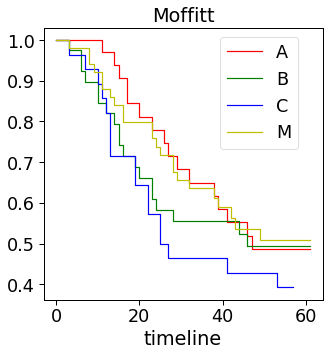

<Figure size 432x288 with 0 Axes>

In [46]:
ci_show=False
#loc=slice(0.,120.)
#use only 5-year survival
loc=slice(0.,61.)
p = survival_plot(df_clinical, status='SURVCENS',time='SURVTIME',
                  ci_show=False,loc=loc,data_name='Moffitt',plot_p=False)

In [47]:
p

0.112

### TCGA 

In [127]:
# clinical data
with open('paper_results/helpers/tcga_class_by_correlation.json', 'r') as fp:
    res_correlation = json.load(fp)

path = 'hnsc_tcga_pan_can_atlas_2018_clinical_data.tsv'
df_clinical = pd.read_csv(path,sep='\t')
df_clinical = df_clinical[df_clinical['Subtype']=='HNSC_HPV-']
df_clinical['class'] = df_clinical['Sample ID'].map(res_correlation)
df_clinical['Overall Survival Status'] = df_clinical['Overall Survival Status'].map({'0:LIVING':0,'1:DECEASED':1})

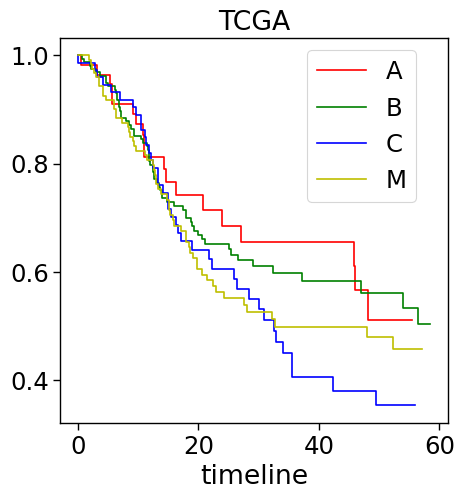

<Figure size 640x480 with 0 Axes>

In [97]:
ci_show=False
loc=slice(0.,60.)
bbox_to_anchor=(0.95, 1)
p= survival_plot(df_clinical, status='Overall Survival Status',time='Overall Survival (Months)', 
              ci_show=False,loc=loc,data_name='TCGA',bbox_to_anchor=bbox_to_anchor,plot_p=False)

In [98]:
p

0.3868

### CPTAC

In [99]:
with open('paper_results/helpers/cptac_class_by_correlation.json', 'r') as fp:
    res_correlation = json.load(fp)

path = 'cptac_hnsc_processed/clinical_combined.txt'
df_clinical = pd.read_csv(path,sep='\t')
df_clinical = df_clinical[df_clinical['days_to_last_follow_up'] != "'--"] 
df_clinical = df_clinical[df_clinical['days_to_last_follow_up'].astype(float) >0 ]
df_clinical['months_to_last_follow_up'] = df_clinical['days_to_last_follow_up'].astype(float)/30
df_clinical['months_to_last_follow_up'] = df_clinical['months_to_last_follow_up'].astype(int)
df_clinical['class'] = df_clinical['case_submitter_id'].map(res_correlation)
df_clinical['vital_status'] = df_clinical['vital_status'].map({'Alive':0,'Dead':1})

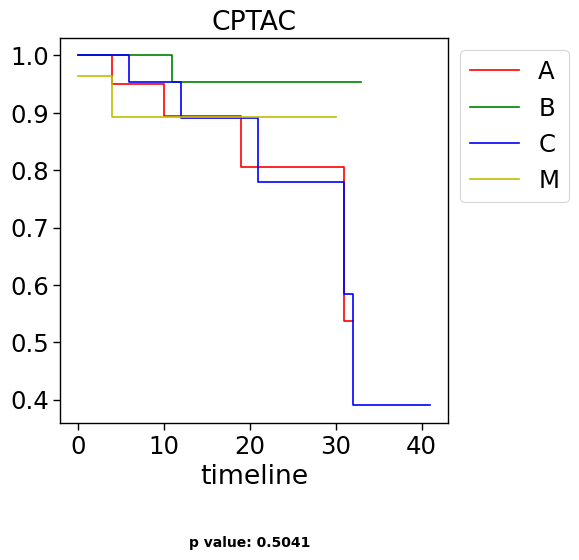

0.5041

<Figure size 640x480 with 0 Axes>

In [100]:
ci_show=False
loc=slice(0.,120.)
bbox_to_anchor=(1, 1)
survival_plot(df_clinical, status='vital_status',time='months_to_last_follow_up', 
              ci_show=False,loc=slice(0.,120.),data_name='CPTAC',bbox_to_anchor=bbox_to_anchor,plot_p=True)

# Figure 2

# Figure 2a Flowchart of anaylsis

Using PPT

# FIgure 2b Heatmaps of TIMEx results in three datasets

Using previously generated mean ssGSEA score files to directly plot into sub-plots for 3 datasets. 

resource:

* [matplotlib color names](https://matplotlib.org/stable/gallery/color/named_colors.html)

### prepare AVATAR data for heatmap

using 224 samples

In [64]:
folder = 'AVATAR'
file = ['AVATAR_filtered_TIMEX.csv',
        'AVATAR_hallmark.csv',
        'AVATAR_kegg.csv']

score_df = {'timex':None,'hallmark':None,'kegg':None}

# class assignment
with open('helpers/avatar_class_by_correlation.json', 'r') as fp:
    res_correlation = json.load(fp)

hpv_neg = pd.read_csv('AVATAR/HPV_neg_list.txt',sep='\t',header=None)[0].to_list()
    
total = pd.DataFrame()
#total = individual
count = 0
score_df_keys = list(score_df.keys())
for i in file:
    path = os.path.join(folder,i)
    df = pd.read_csv(path,index_col=0)
    df['class'] = df.index.map(res_correlation)
    df = df[df.index.isin(hpv_neg)]
    score_df[score_df_keys[count]] = df
    count += 1


In [68]:
# zscore first mean second
def produce_mean_score(df,keep=None,dataset='AVATAR',method='timex'):
    if keep is not None:
        df_sig = df[keep]
    else:
        df_sig = df.copy()
    df_sig.index = df['class']
    df_sig.drop('class',axis=1,inplace=True)
    # calculate the mean value for each cell type/pathway
    normalized_df = df_sig.apply(lambda x: zscore(x,nan_policy='omit'),axis=0).apply(pd.Series)
#     normalized_df.columns = df['class']
    normalized_df = normalized_df.reset_index().groupby('class').mean().T
    normalized_df.to_csv('plots/{0}_subtypes/mean_score_{1}_new.csv'.format(dataset,method),index=True)
    return normalized_df

for i in score_df.keys():
    temp = produce_mean_score(score_df[i],dataset='AVATAR',method=i)

### make heatmaps

In [72]:
# import annotation for clustering maps(kegg and hallmark)
# import annotation for TIMEx
# for future change color coding scheme to modify or add more annotations
from paper_results.helpers import ColorCoding

with open('paper_results/helpers/pathway_selection.json', 'r') as fp:
    pathway_selected = json.load(fp)

In [73]:
## read the ssGSEA mean value files
file_dir = 'plots'
folders = ['AVATAR_subtypes','TCGA_subtypes','cptac_RSEM_subtypes']
files = ['mean_score_hallmark_new.csv','mean_score_kegg_new.csv','mean_score_timex_new.csv']

# method_dict = {'mean_score_hallmark.csv':ColorCoding.color_map['hallmark_selected'],
#                'mean_score_kegg.csv':ColorCoding.color_map['kegg_selected'],
#                'mean_score_timex.csv':pathway_selected['timex_selected']}

method_dict = {'mean_score_hallmark_new.csv':ColorCoding.color_map['hallmark_selected'],
               'mean_score_kegg_new.csv':ColorCoding.color_map['kegg_selected'],
               'mean_score_timex_new.csv':pathway_selected['timex_selected']}


## Timex heatmap (main figure)

<ipython-input-75-1d9700ee5461>:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


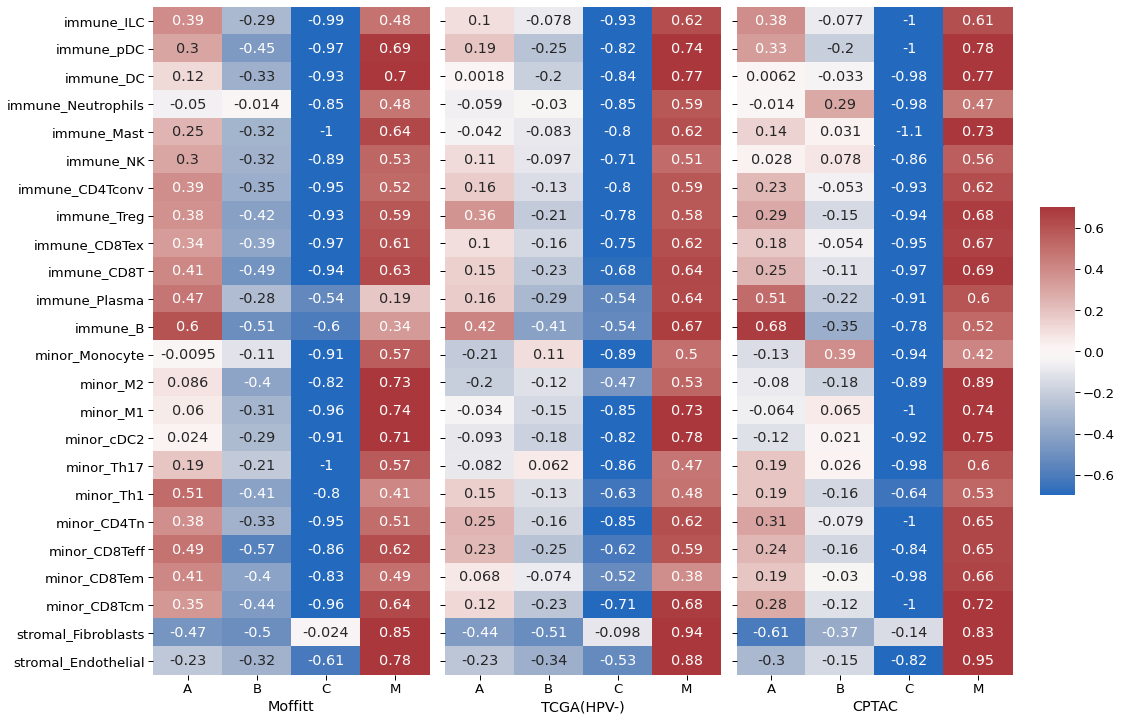

<Figure size 432x288 with 0 Axes>

In [75]:
fig, axn = plt.subplots(1, 3, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
fig.set_size_inches(16, 10)
sns.set_context("paper", font_scale=1.5)
for i, ax in enumerate(axn.flat):
    path = os.path.join(file_dir,folders[i]+'/'+'mean_score_timex_new.csv')
    df = pd.read_csv(path,index_col=0)
    df = df[df.index.isin(pathway_selected['timex_selected'])]
    sns.heatmap(df, ax=ax,cmap="vlag",annot=True,xticklabels=['A','B','C','M'],
                cbar=i == 0,
                vmin=-0.7, vmax=0.7,
                cbar_ax=None if i else cbar_ax)

fig.tight_layout(rect=[0, 0, .9, 1])

axn[0].set(xlabel="Moffitt")
axn[1].set(xlabel="TCGA(HPV-)")
axn[2].set(xlabel="CPTAC")

fig_out_path = 'paper_results/2_heatmaps/TIMEx_alldatasets_new.png'
plt.savefig(fig_out_path, format="png",bbox_inches = 'tight')
plt.show()
plt.clf()

## TCGA comparisons with HPV+

In [510]:
with open('paper_results/helpers/tcga_class_by_correlation.json', 'r') as fp:
    res_correlation = json.load(fp)

# HPV status annotation
path = 'hnsc_tcga_pan_can_atlas_2018_clinical_data.tsv'
anno = pd.read_csv(path,sep='\t')
hpv_neg = anno[anno['Subtype']=='HNSC_HPV-']['Sample ID'].to_list()


path = "TCGA_HNSC/HNSC/HNSC_filtered_TIMEX.csv"
df = pd.read_csv(path,index_col=0).T
df = df[df.index.isin(pathway_selected['timex_selected'])]
z_score_df = df.apply(lambda x: zscore(x,nan_policy='omit'),axis=1).apply(pd.Series)
z_score_df.columns=df.columns
z_score_df_hpv_pos = z_score_df[hpv_pos]
z_score_df_hpv_neg = z_score_df[hpv_neg]
z_score_df_hpv_pos.columns = ['HPV+']*len(z_score_df_hpv_pos.columns)    
z_score_df_hpv_neg.columns = z_score_df_hpv_neg.columns.map(res_correlation)
z_score_df = pd.concat([z_score_df_hpv_neg, z_score_df_hpv_pos], axis=1)    
df = z_score_df.T.reset_index().groupby('index').mean().T
df = df[['HPV+','Atypical','Basal','Classical','Mesenchymal']]

<ipython-input-344-6bc15f8ba474>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax = fig.add_axes([.91, .3, .03, .4])
<ipython-input-344-6bc15f8ba474>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  vmin=-0.7, vmax=0.7,cbar_ax=fig.add_axes([.91, .3, .03, .4]))


<AxesSubplot:xlabel='index'>

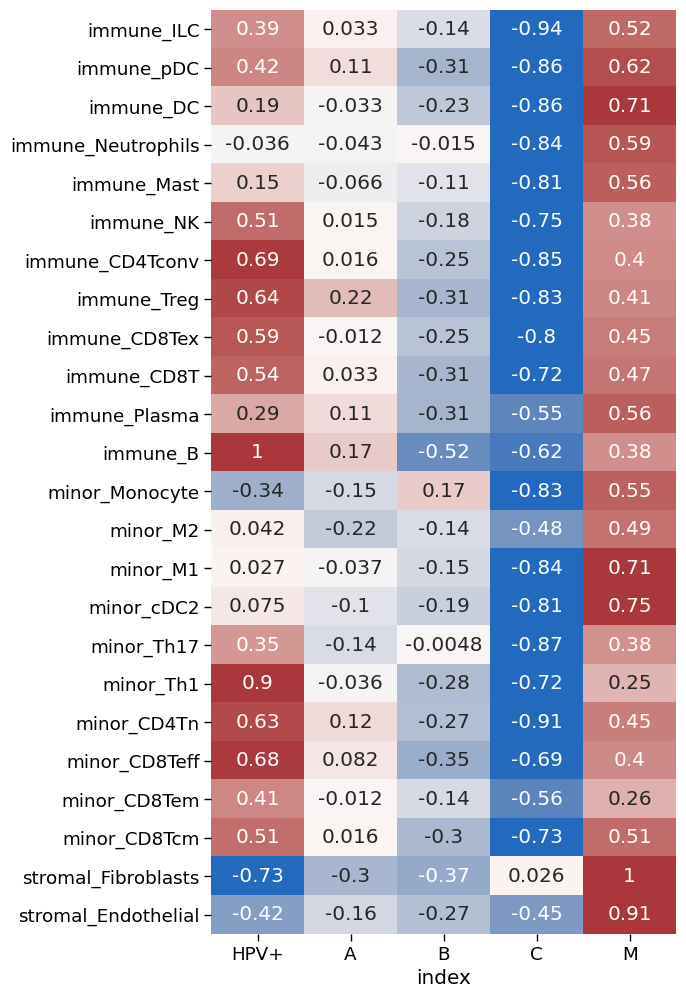

In [344]:
sns.reset_defaults()
sns.set_context("paper", font_scale=1.5)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
plt.figure(figsize=(6,12))
sns.heatmap(df, cmap="vlag",annot=True,xticklabels=['HPV+','A','B','C','M'],cbar=True,                
                vmin=-0.7, vmax=0.7,cbar_ax=fig.add_axes([.91, .3, .03, .4]))

In [335]:
# correlation patterns
df.corr()

index            HPV+  Atypical     Basal  Classical  Mesenchymal
index                                                            
HPV+         1.000000  0.778074 -0.420080  -0.481019    -0.825851
Atypical     0.778074  1.000000 -0.458294  -0.480432    -0.517090
Basal       -0.420080 -0.458294  1.000000  -0.365594    -0.030391
Classical   -0.481019 -0.480432 -0.365594   1.000000     0.437739
Mesenchymal -0.825851 -0.517090 -0.030391   0.437739     1.000000

sample count:24, method count:5


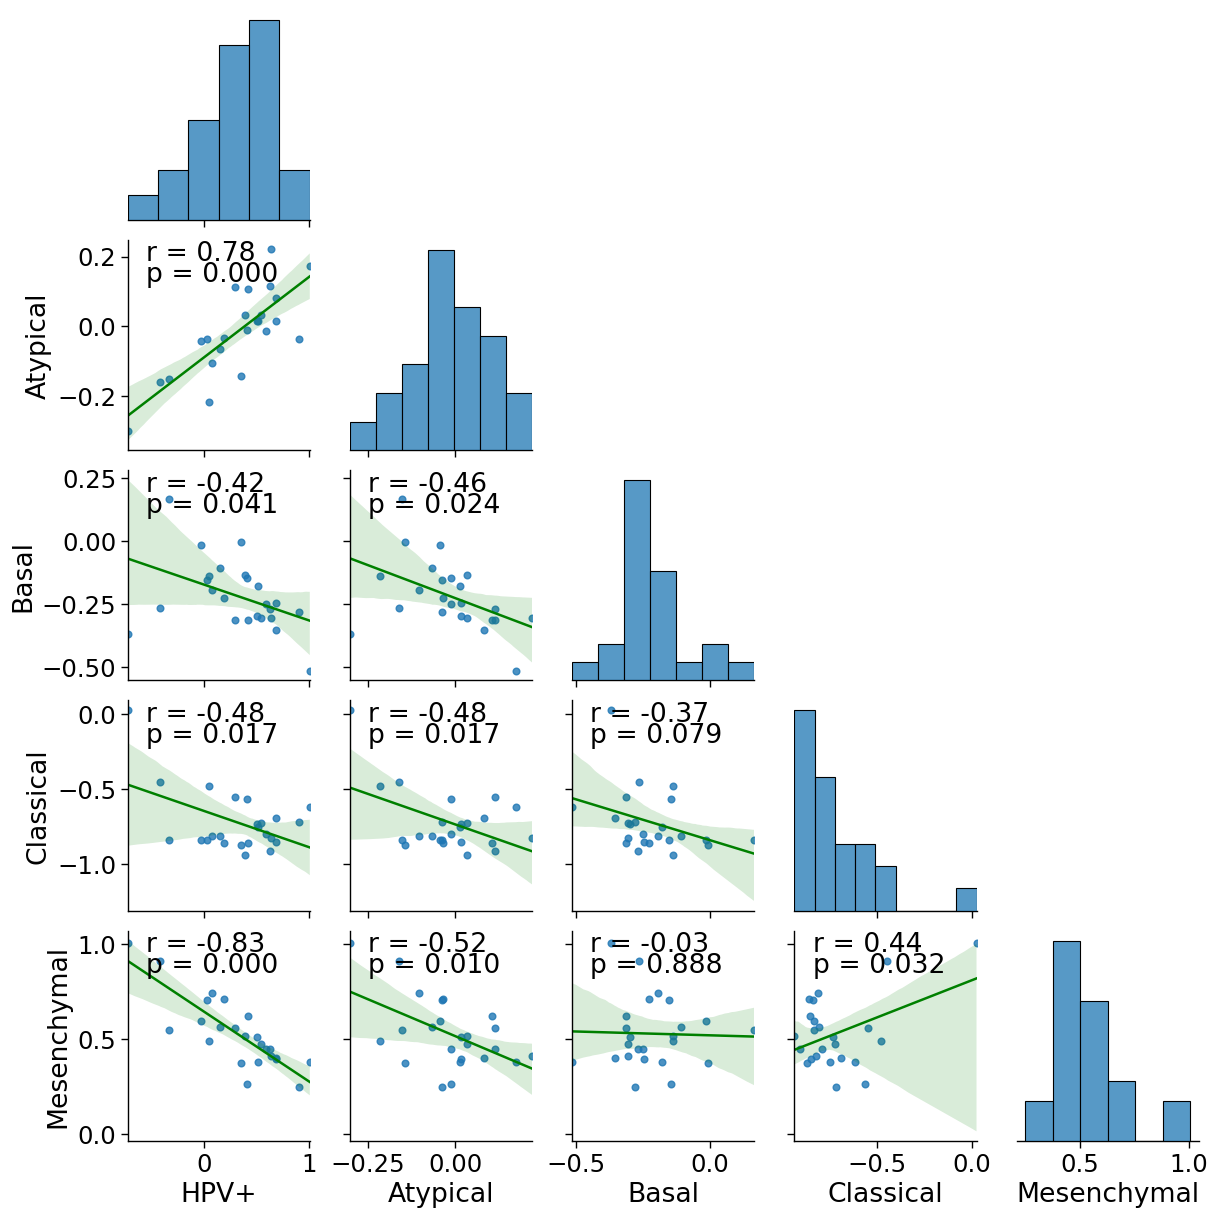

In [512]:
plot_corr(df)

## Hallmark and KEGG

<Figure size 800x500 with 0 Axes>

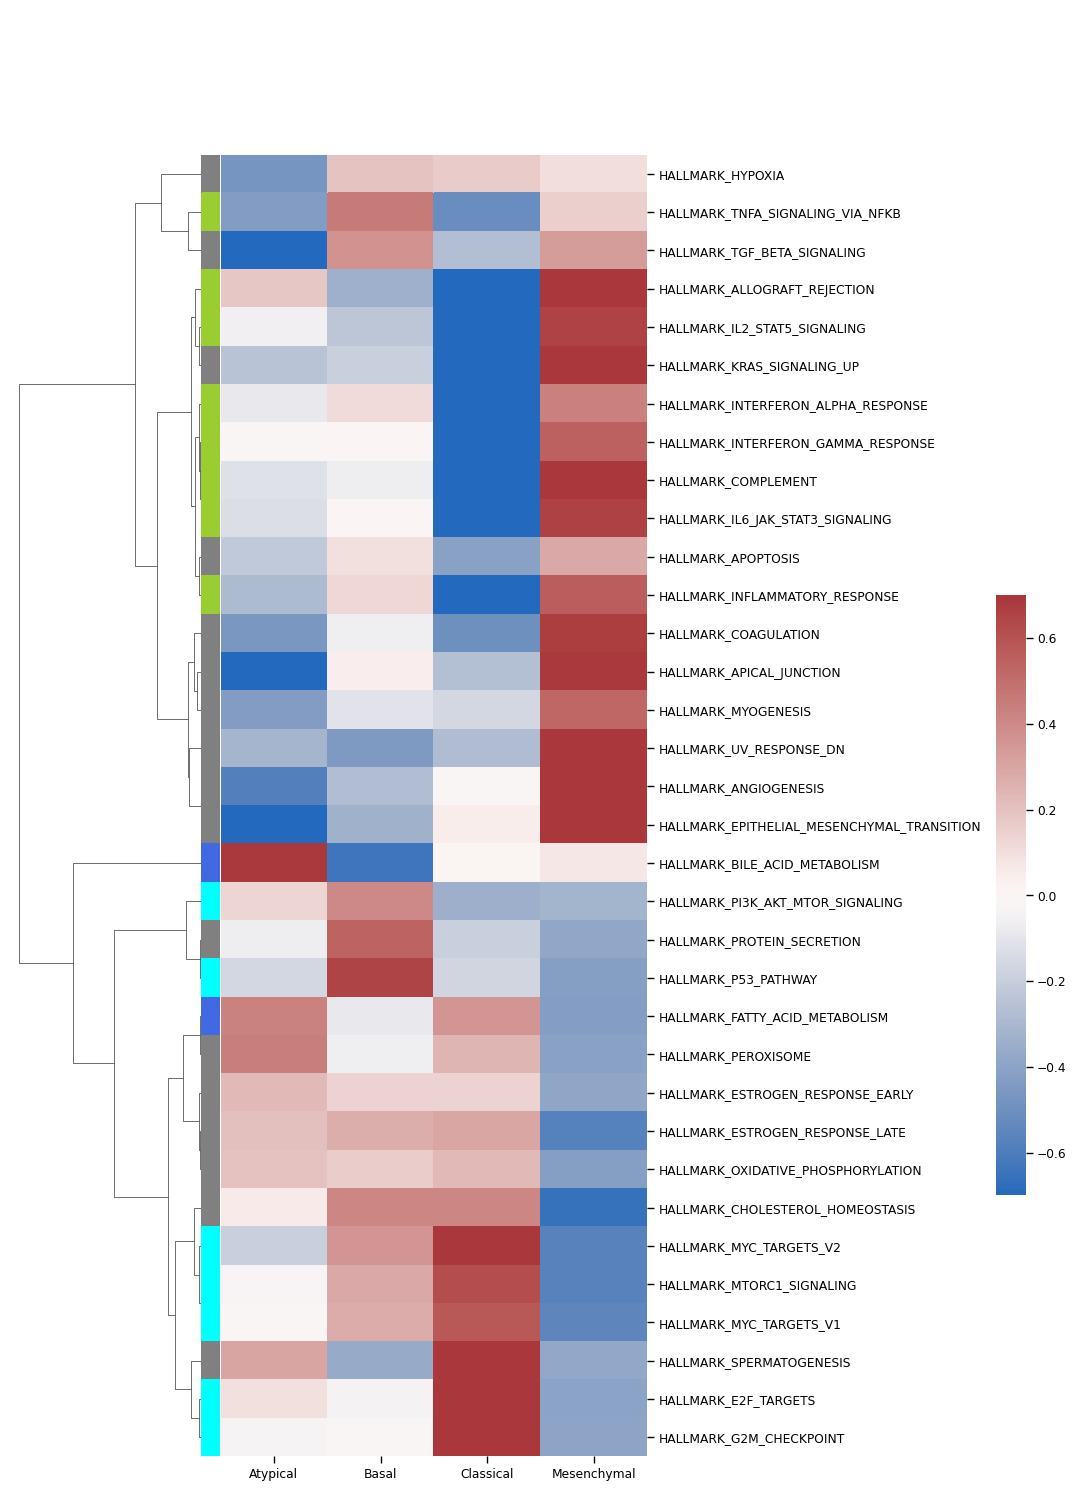

<Figure size 800x500 with 0 Axes>

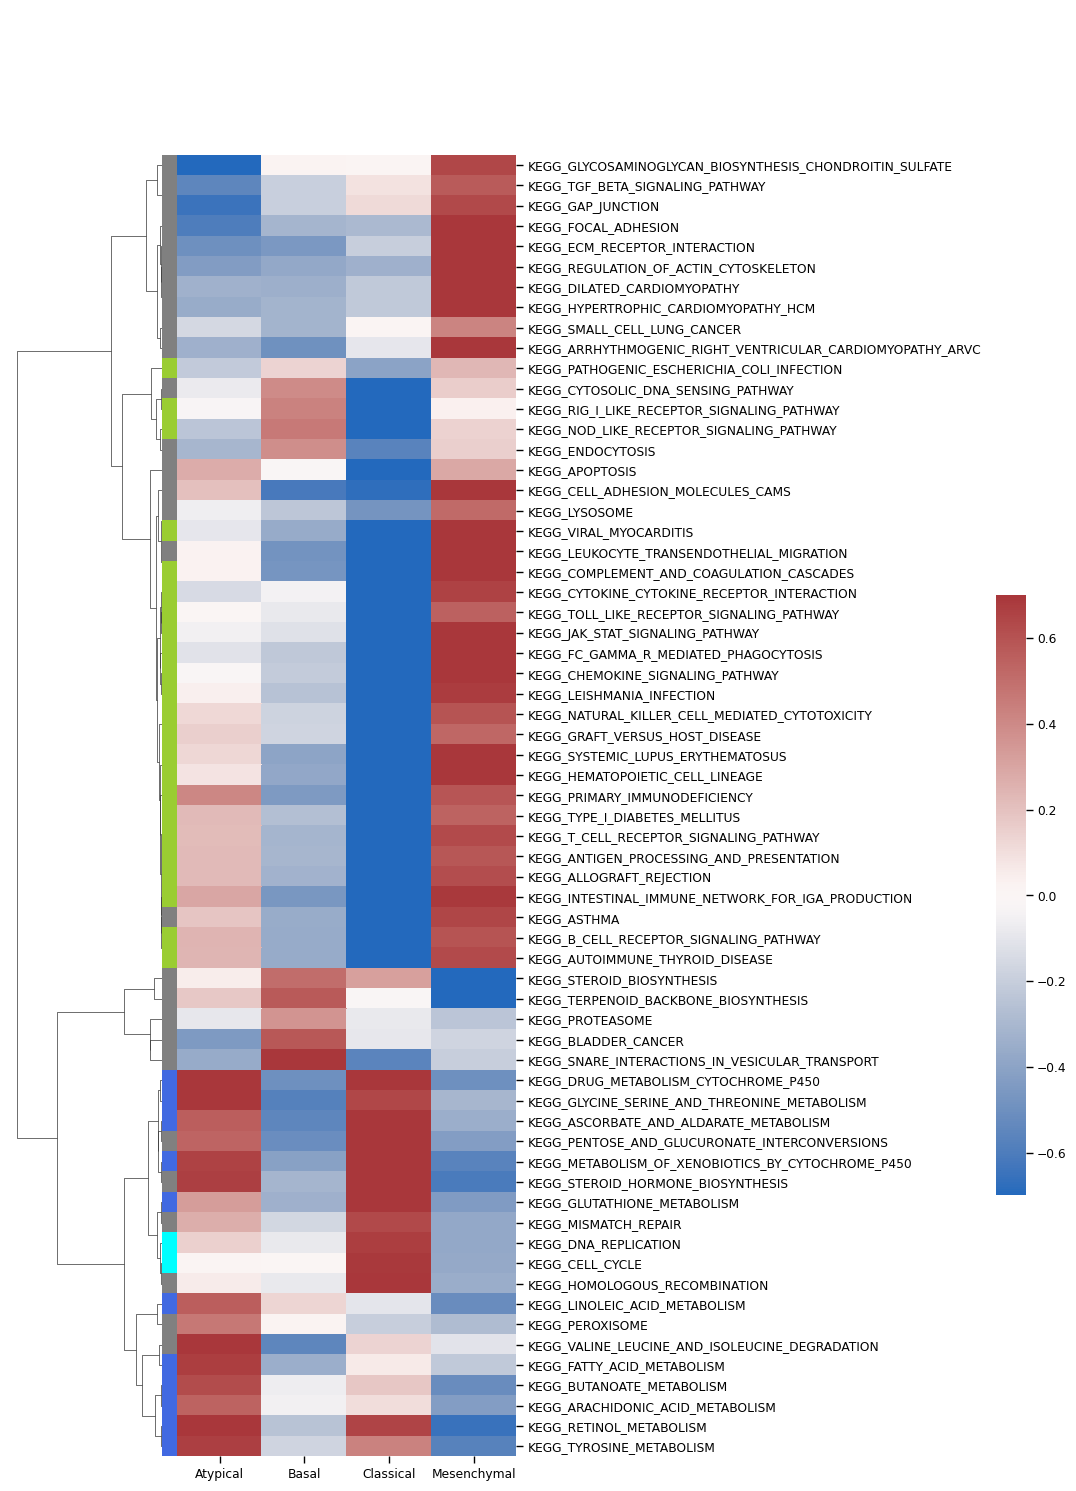

<Figure size 800x500 with 0 Axes>

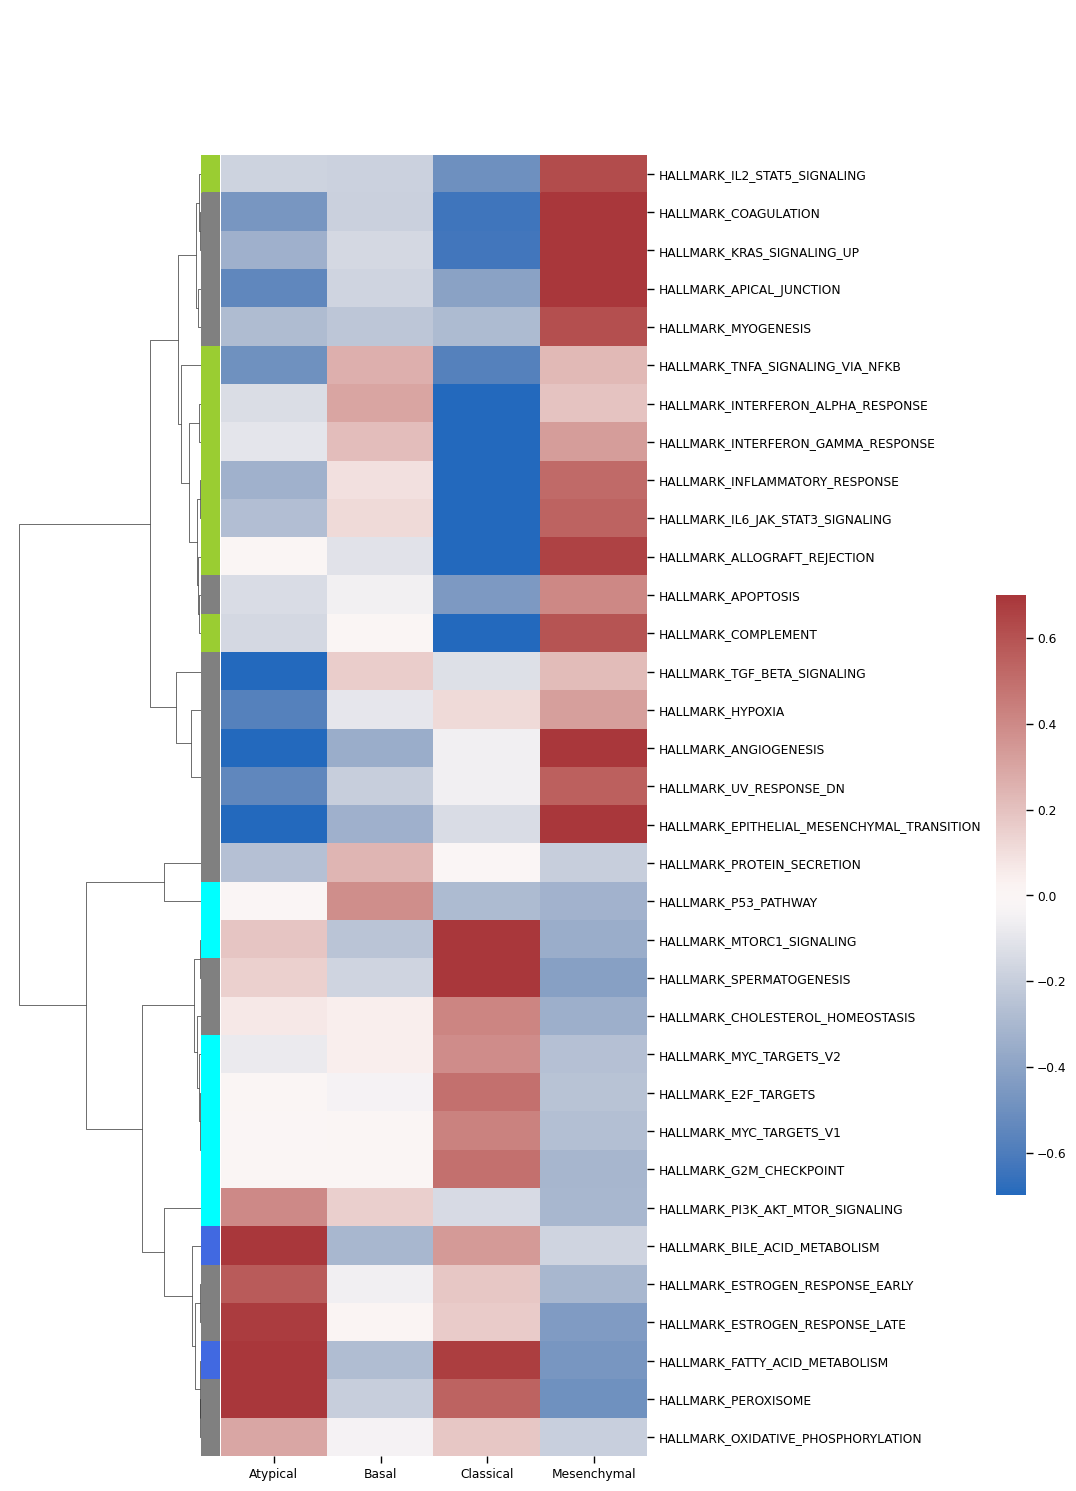

<Figure size 800x500 with 0 Axes>

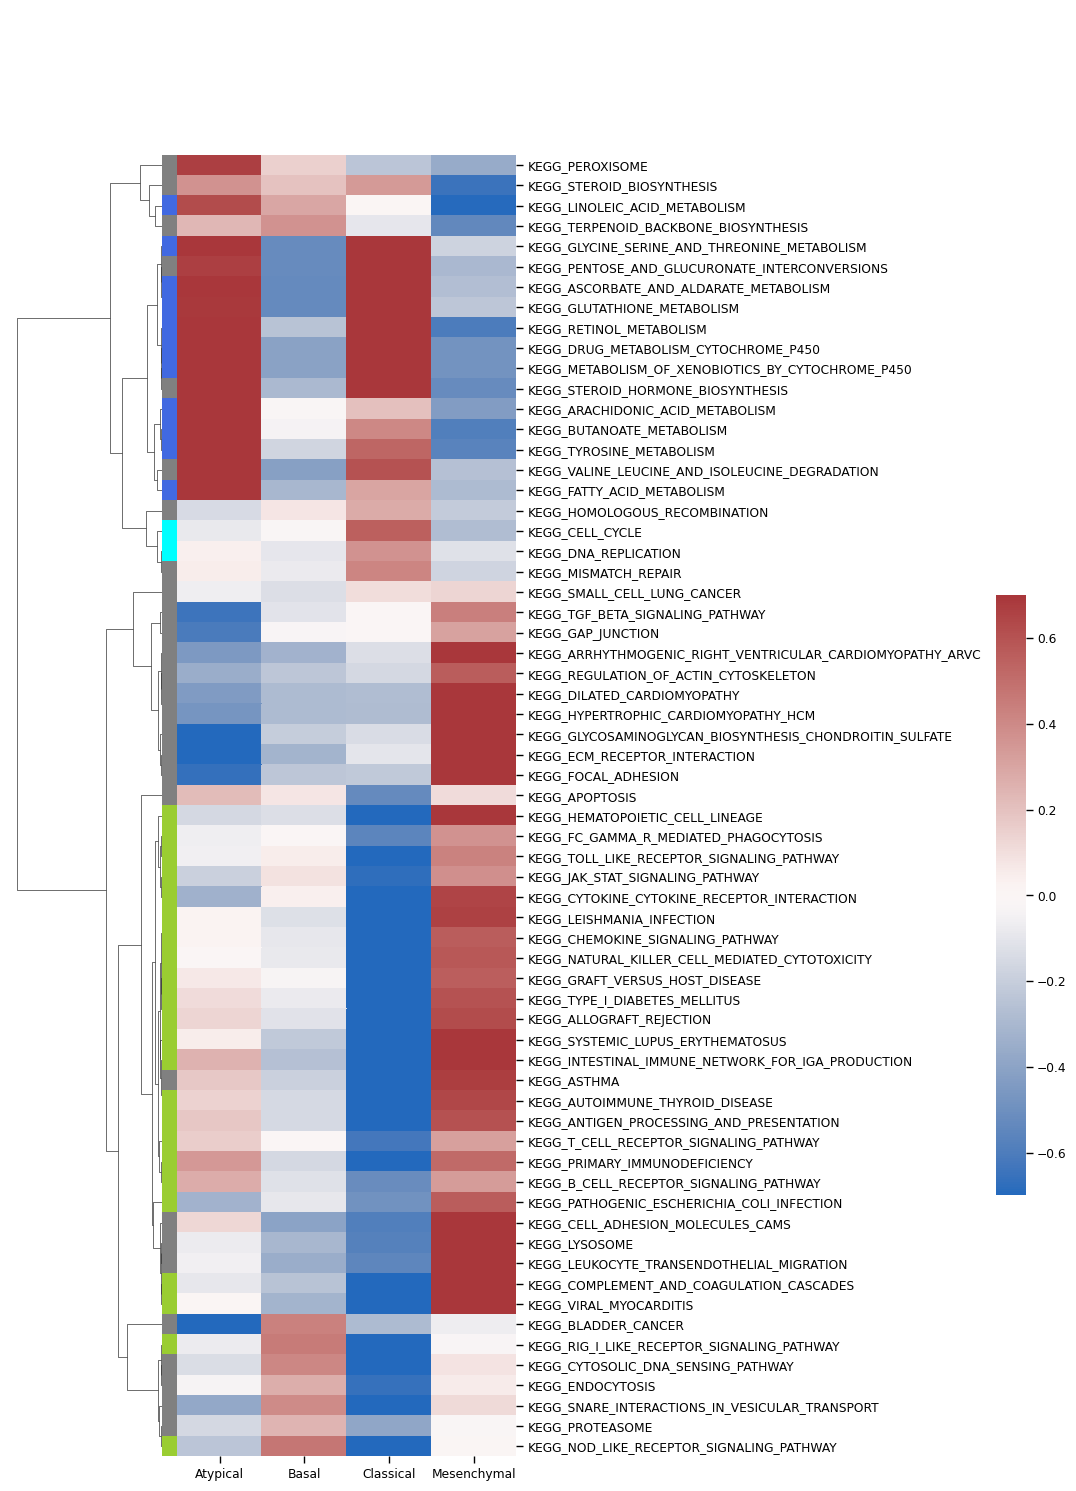

<Figure size 800x500 with 0 Axes>

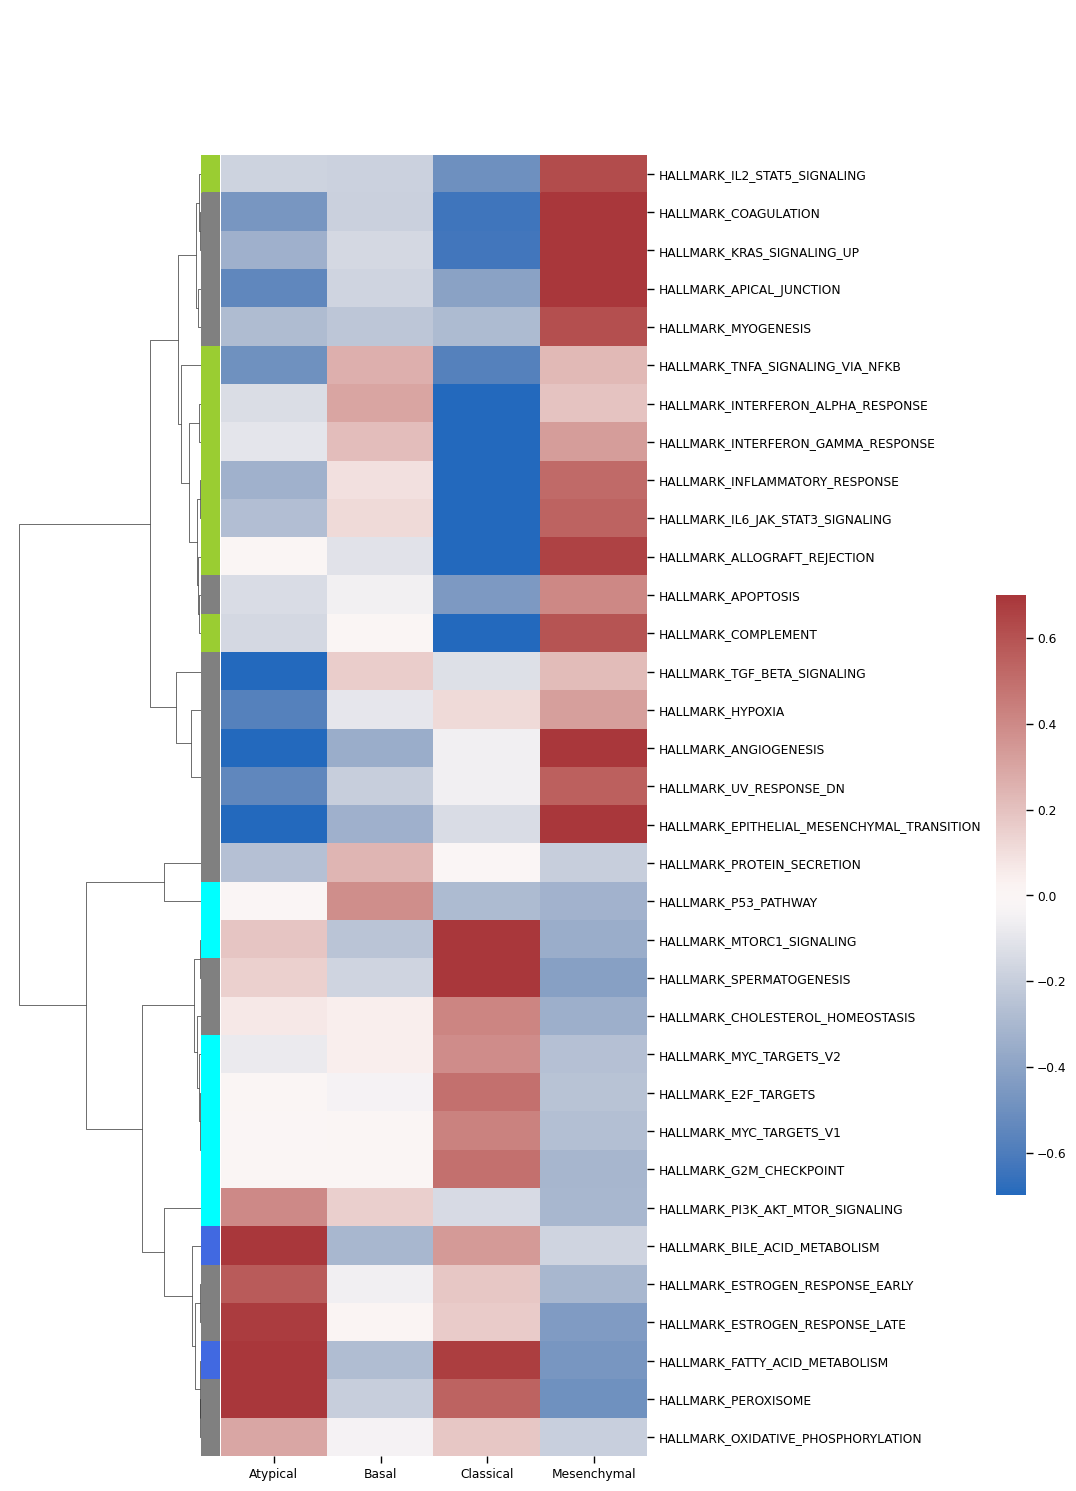

<Figure size 800x500 with 0 Axes>

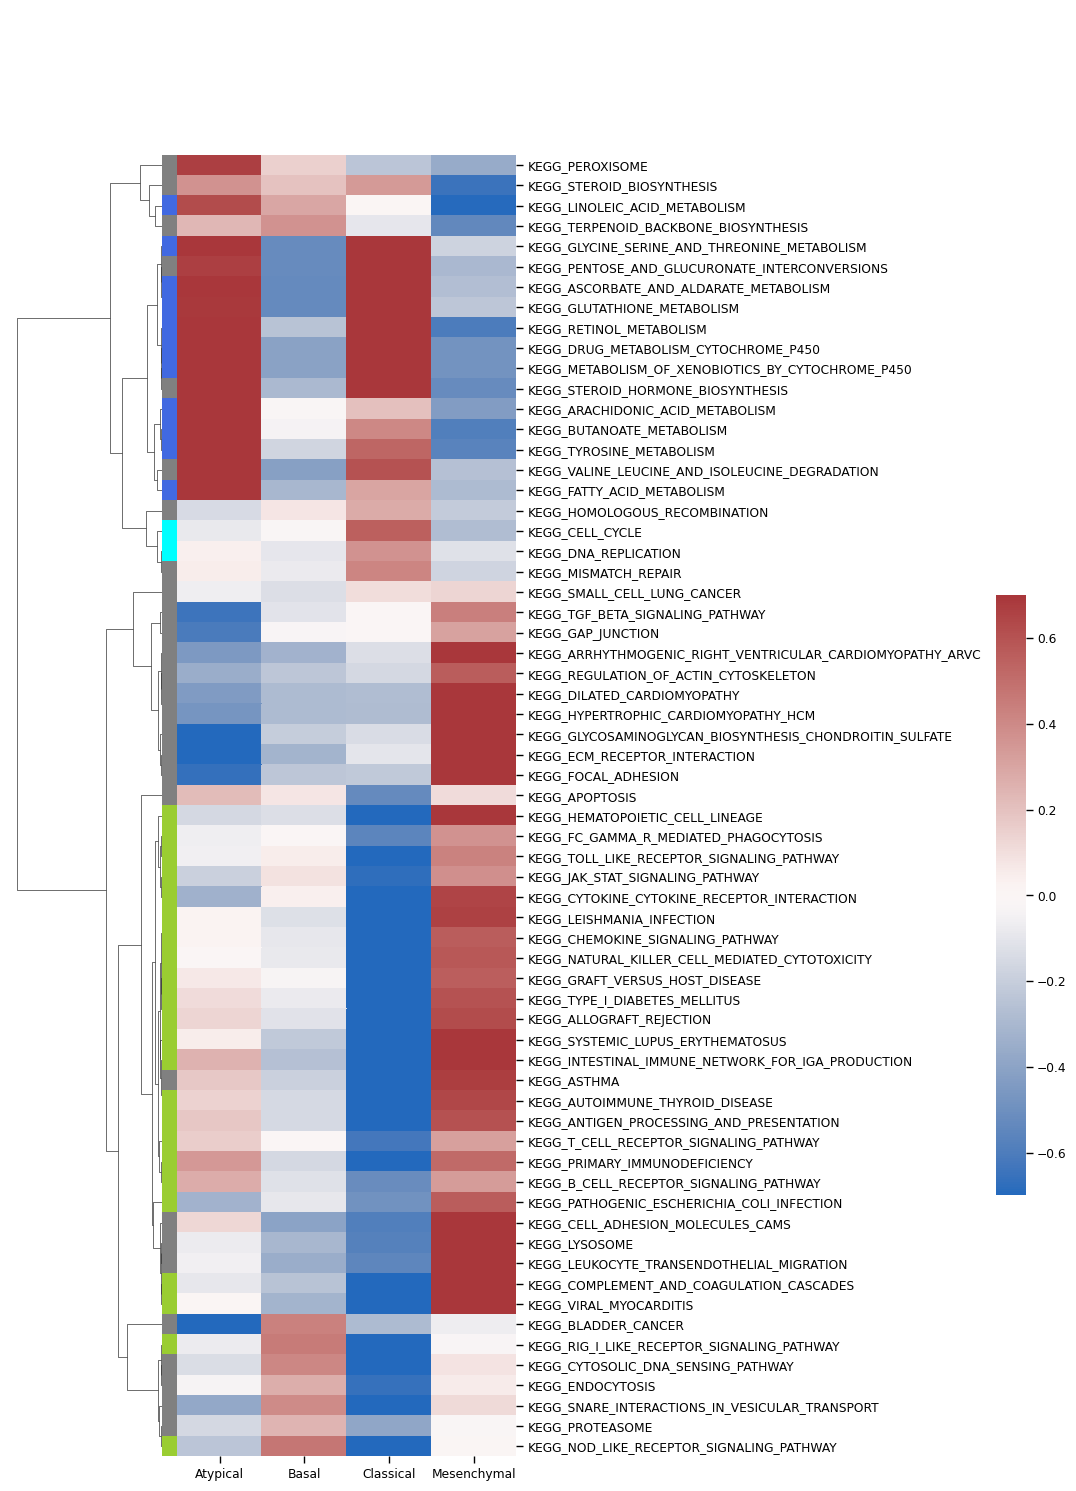

<Figure size 640x480 with 0 Axes>

In [460]:
for i in folders:
    for j in files[0:2]:
        path = os.path.join(file_dir,i,j)
        fig_out_path = 'paper_results/2_heatmaps/{0}_{1}_new.png'.format(i,j)
        
        df = pd.read_csv(path,index_col=0).T
        df = df[method_dict[j].keys()].T
        row_colors=list(method_dict[j].values())
            
        fig = plt.gcf()
        fig.set_size_inches(8, 5)
        sns.set_context("paper", font_scale=1)
        g = sns.clustermap(df,metric="correlation",method='average', cmap="vlag",row_colors=row_colors,
                                figsize=(10, 15),vmin=-0.7, vmax=0.7,
                                col_cluster=False,
                                row_cluster=True,
                                dendrogram_ratio=(.3, .1),
                                cbar_pos=(1, .2, .03, .4)) 
#         g = sns.heatmap(df, annot=True,cmap="vlag")
#         g.set_title(i)
        plt.xticks(rotation=90)
        plt.savefig(fig_out_path, format="png",bbox_inches = 'tight')
        plt.show()
        plt.clf()        

# Figure 2c Moffitt cohort Immune panel(IHC images)

# Figure 3

# Figure 3a Immune suppressive receptors and ligands expression heatmap

1. read in log transformed gene expression matrix
2. z-normalization
3. filter target genes
4. plot heatmaps

resource: 
* [T cell exhaustion markers](https://www.rndsystems.com/product-highlights/adoptive-cell-transfer-monitor-t-cell-exhaustion)


<ipython-input-89-3c192d748d7e>:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


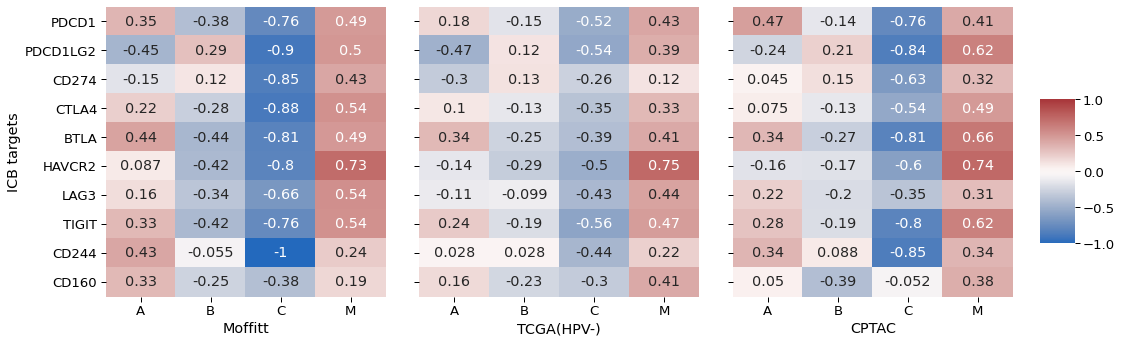

<Figure size 432x288 with 0 Axes>

In [89]:
paths = {'Moffitt':['paper_results/helpers/avatar_class_by_correlation.json',
                    'AVATAR/HN_v0.4.3_RNAseq_counts_library_size_normalized_log2.txt'],
         'TCGA':['paper_results/helpers/tcga_class_by_correlation.json',
                 'TCGA_HNSC/HNSC.txt'],
         'CPTAC':['paper_results/helpers/cptac_class_by_correlation.json',
                 'cptac_hnsc_processed_star/cptac_hnsc_star_log/cptac_hnsc_star_log_collapsed_to_symbols_reg_tumor.txt']}



fig, axn = plt.subplots(1, 3, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
fig.set_size_inches(16, 5)
sns.set_context("paper", font_scale=1.5)
for i, ax in enumerate(axn.flat):
    
    dataset = list(paths.keys())[i]
    
    with open(paths[dataset][0], 'r') as fp:
        res_correlation = json.load(fp)
    path = paths[dataset][1]
    df = pd.read_csv(path,sep='\t',index_col=0)
    df = df.loc[['PDCD1','PDCD1LG2','CD274','CTLA4','BTLA','HAVCR2','LAG3','TIGIT','CD244','CD160'],:]
    
    #filter out HPV+ samples
    if dataset == 'Moffitt':
        hpv_neg = pd.read_csv('AVATAR/HPV_neg_list.txt',sep='\t',header=None)[0].to_list()
        df = df[hpv_neg]
    elif dataset == 'TCGA':
        hpv_neg = pd.read_csv('TCGA_HNSC/HPV_neg_list.txt',sep='\t',header=None)[0].to_list()
        df = df[hpv_neg]
    
    
    z_score_df = df.apply(lambda x: zscore(x,nan_policy='omit'),axis=1).apply(pd.Series)
    z_score_df.columns=df.columns.map(res_correlation)
    df = z_score_df.T.reset_index().groupby('index').mean().T

    sns.heatmap(df, ax=ax,cmap="vlag",annot=True,xticklabels=['A','B','C','M'],
                cbar=i == 0,
                vmin=-1, vmax=1,
                cbar_ax=None if i else cbar_ax)

fig.tight_layout(rect=[0, 0, .9, 1])

axn[0].set(xlabel="Moffitt",ylabel='ICB targets')
axn[1].set(xlabel="TCGA(HPV-)",ylabel='')
axn[2].set(xlabel="CPTAC",ylabel='')

fig_out_path = 'paper_results/3_ICB_targets/ICB_targets_alldatasets.png'
plt.savefig(fig_out_path, format="png",dpi=150,bbox_inches = 'tight')
plt.show()
plt.clf()

### Fig3b

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

C v.s. M: Mann-Whitney-Wilcoxon test two-sided, P_val=4.365e-09 U_stat=3.610e+02
B v.s. M: Mann-Whitney-Wilcoxon test two-sided, P_val=2.157e-01 U_stat=2.057e+03
A v.s. M: Mann-Whitney-Wilcoxon test two-sided, P_val=1.044e-04 U_stat=1.070e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

C v.s. M: Mann-Whitney-Wilcoxon test two-sided, P_val=1.415e-05 U_stat=2.868e+03
B v.s. M: Mann-Whitney-Wilcoxon test two-sided, P_val=9.628e-01 U_stat=9.934e+03
A v.s. M: Mann-Whitney-Wilcoxon test two-sided, P_val=8.027e-04 U_stat=2.415e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

C v.s. M: Mann-Whitney

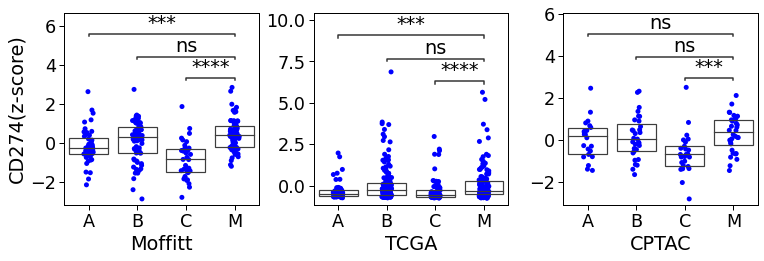

<Figure size 432x288 with 0 Axes>

In [93]:
paths = {'Moffitt':['paper_results/helpers/avatar_class_by_correlation.json',
                    'AVATAR/HN_v0.4.3_RNAseq_counts_library_size_normalized_log2.txt'],
         'TCGA':['paper_results/helpers/tcga_class_by_correlation.json',
                 'TCGA_HNSC/HNSC.txt'],
         'CPTAC':['paper_results/helpers/cptac_class_by_correlation.json',
                 'cptac_hnsc_processed_star/cptac_hnsc_star_log/cptac_hnsc_star_log_collapsed_to_symbols_reg_tumor.txt']}

#subtype_rename = {'Atypical':'A','Basal':'B','Classical':'C','Mesenchymal':'M'}


#immune_markers = ['PD-L1','CD3+PD-1+']
sns.set_context("paper", font_scale=2)
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 4), sharey=False)
            
for i,el in enumerate(axes.flat):
#     a = df.boxplot(el, by='CLASS',grid=False,fontsize=15, ax=axes.flatten()[i])
#     a.set(xlabel="", ylabel="")

    dataset = list(paths.keys())[i]
    
    with open(paths[dataset][0], 'r') as fp:
        res_correlation = json.load(fp)
    path = paths[dataset][1]
    df = pd.read_csv(path,sep='\t',index_col=0)
    df = df.loc[['PDCD1','PDCD1LG2','CD274','CTLA4','BTLA','HAVCR2','LAG3','TIGIT','CD244','CD160'],:]   
    
    #filter out HPV+ samples
    if dataset == 'Moffitt':
        hpv_neg = pd.read_csv('AVATAR/HPV_neg_list.txt',sep='\t',header=None)[0].to_list()
        df = df[hpv_neg]
    elif dataset == 'TCGA':
        hpv_neg = pd.read_csv('TCGA_HNSC/HPV_neg_list.txt',sep='\t',header=None)[0].to_list()
        df = df[hpv_neg]

    
    z_score_df = df.apply(lambda x: zscore(x,nan_policy='omit'),axis=1).apply(pd.Series)
    z_score_df.columns=df.columns.map(res_correlation)
    z_score_df = z_score_df.T
    z_score_df.index = z_score_df.index.map(subtype_rename)    


    a = sns.stripplot(x=z_score_df.index, y='CD274', data=z_score_df, zorder=0.5, color='blue',
                      order = ['A','B','C','M'],ax=axes.flatten()[i])    
    sns.boxplot(x=z_score_df.index, y='CD274', data=z_score_df, order = ['A','B','C','M'],
                 showcaps=False,boxprops={'facecolor':'None'},
                 showfliers=False,whiskerprops={'linewidth':0}, ax=axes.flatten()[i])
    #a.set(yscale="log")
    add_stat_annotation(a, x=z_score_df.index, y='CD274', data=z_score_df, 
                            order = ['A','B','C','M'], box_pairs=[('C','M'),('A','M'),('B','M')],
                            test='Mann-Whitney', comparisons_correction=None, loc='inside', verbose=2)

    
axes[0].set(xlabel="Moffitt",ylabel='CD274(z-score)')
axes[1].set(xlabel="TCGA",ylabel='')
axes[2].set(xlabel="CPTAC",ylabel='')
plt.tight_layout() 

fig_out_path = 'TMA_results/ICB.png'
fig_out_path = './paper_results/2_TMA/ICB_box.png'
plt.savefig(fig_out_path, format="png",dpi=500,bbox_inches = 'tight')
plt.show()
plt.clf()

# Figure 3b TMA IHC (image analysis)

* For plots: [using log10 y axis scale](https://stackoverflow.com/questions/48066588/seaborn-modify-y-axis-log-scale-to-show-more-values)
* For stat tests: only compare C and M

In [102]:
with open('paper_results/helpers/avatar_class_by_correlation.json', 'r') as fp:
    res_correlation = json.load(fp)
hpv_neg = pd.read_csv('AVATAR/HPV_neg_list.txt',sep='\t',header=None)[0].to_list()
    
path = 'background/TMA1_fulltable_4AC_20210126_RC.xlsx'
df = pd.ExcelFile(path ,engine='openpyxl')
df = pd.read_excel(df, 'TMA1_fulltable_20210126',index_col=None, header=0)
df = df.dropna(subset=['SLID.RNA'])
classes = df['SLID.RNA'].map(res_correlation)
#df = np.log10(df[markers])
df['CLASS'] = classes
df['CLASS'] = df['CLASS'].map({'Classical':'C', 'Basal':'B', 'Mesenchymal':'M', 'Atypical':'A'})
df = df[df['SLID.RNA'].isin(hpv_neg)]

In [101]:
df

CORE      SOURCE   ID  SLID.WES  SLID.RNA     MRN  GENDER   RACE  \
0     A1     Primary  292  SL244158  SL250016  656440    Male  White   
2    A11     Primary  272  SL244161  SL250031  642376    Male  White   
3    A12     Primary  291  SL248609  SL243661  655356    Male  White   
4    A13     Primary    8  SL244156  SL250191  231121    Male  White   
5    A14     Primary  308  SL250157  SL250157  693963    Male  White   
..   ...         ...  ...       ...       ...     ...     ...    ...   
116   J5     Primary  213  SL243008  SL249995  599172  Female  White   
117   J6     Primary   19  SL242970  SL243717  307855  Female  White   
118   J7  Recurrence   59  SL257939  SL257939  333861    Male  White   
119   J8     Primary  166  SL248668  SL243712  561292    Male  White   
120   J9  Recurrence   43  SL248666  SL243736  325349  Female  White   

    ETHNICITY  AGE  ... propclose_FOXP3-CD3 propclose_CD3-CD8  \
0    Non-Hisp   66  ...            0.748167          0.548700   
2    Non-Hisp   64  ...            0.824933          0.940600   
3    Non-Hisp   57  ...            0.699033          0.754833   
4    Non-Hisp   46  ...            0.812333          0.863533   
5    Non-Hisp   47  ...            0.816600          0.795500   
..        ...  ...  ...                 ...               ...   
116  Non-Hisp   77  ...            0.760500          0.586800   
117  Non-Hisp   56  ...            0.697600          0.544767   
118  Non-Hisp   64  ...            0.283333          0.275000   
119  Non-Hisp   64  ...            0.782100          0.742667   
120  Hispanic   53  ...            0.611900          0.675633   

     propclose_PCK-CD3 propclose_PCK-CD8 propclose_PCK-CD69  \
0             0.391733          0.287233           0.206567   
2             0.516133          0.471567           0.334733   
3             0.442833          0.424533           0.497633   
4             0.739000          0.611500           0.814567   
5             0.563967          0.507233           0.418533   
..                 ...               ...                ...   
116           0.479033          0.343333           0.387133   
117           0.174367          0.048067           0.146933   
118           0.077533          0.059050           0.106600   
119           0.709733          0.654800           0.691333   
120           0.190400          0.194333           0.241267   

    propclose_PCK-GrzB  propclose_PCK-CD103  propclose_PCKKi67-CD3  \
0             0.145033             0.201133               0.355733   
2             0.122267             0.158800               0.438867   
3             0.119867             0.300600               0.429100   
4             0.268233             0.609633               0.752333   
5             0.135000             0.220500               0.600000   
..                 ...                  ...                    ...   
116           0.031967             0.056367               0.539367   
117           0.039200             0.091633               0.229867   
118           0.040067             0.110200               0.108667   
119           0.033400             0.618967               0.649233   
120           0.151633             0.154367               0.224233   

     propclose_PCKKi67-CD8  CLASS  
0                 0.205967      C  
2                 0.472167      B  
3                 0.479400      M  
4                 0.590267      M  
5                 0.666667      M  
..                     ...    ...  
116               0.356000      M  
117               0.016967      C  
118               0.112950      B  
119               0.628200      C  
120               0.245700      A  

[90 rows x 83 columns]

### PD-1 and PD-L1

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

C v.s. M: Mann-Whitney-Wilcoxon test two-sided, P_val=3.166e-02 U_stat=1.555e+02
B v.s. M: Mann-Whitney-Wilcoxon test two-sided, P_val=5.938e-02 U_stat=2.245e+02
A v.s. M: Mann-Whitney-Wilcoxon test two-sided, P_val=6.722e-01 U_stat=1.955e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

C v.s. M: Mann-Whitney-Wilcoxon test two-sided, P_val=1.405e-01 U_stat=1.850e+02
B v.s. M: Mann-Whitney-Wilcoxon test two-sided, P_val=1.415e-01 U_stat=2.465e+02
A v.s. M: Mann-Whitney-Wilcoxon test two-sided, P_val=5.993e-01 U_stat=1.915e+02


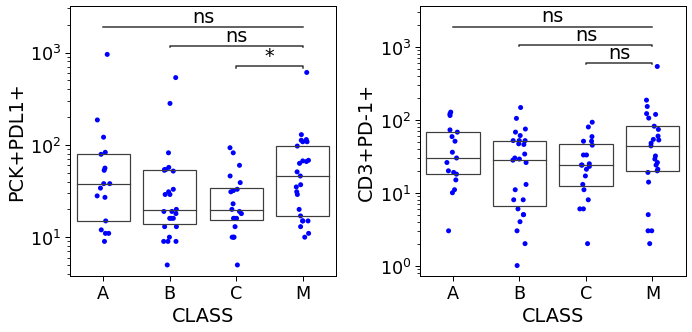

<Figure size 432x288 with 0 Axes>

In [104]:
immune_markers = ['PCK+PDL1+','CD3+PD-1+']
#immune_markers = ['PD-L1','CD3+PD-1+']
sns.set_context("paper", font_scale=2)
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=False)
            
for i,el in enumerate(immune_markers):
#     a = df.boxplot(el, by='CLASS',grid=False,fontsize=15, ax=axes.flatten()[i])
#     a.set(xlabel="", ylabel="")
    a = sns.stripplot(x='CLASS', y=el, data=df, zorder=0.5, color='blue',
                      order = ['A','B','C','M'],ax=axes.flatten()[i])    
    sns.boxplot(x='CLASS', y=el, data=df,order = ['A','B','C','M'],
                 showcaps=False,boxprops={'facecolor':'None'},
                 showfliers=False,whiskerprops={'linewidth':0}, ax=axes.flatten()[i])
    a.set(yscale="log")
    add_stat_annotation(a, data=df, x='CLASS', y=el, 
                            order = ['A','B','C','M'], box_pairs=[('C','M'),('A','M'),('B','M')],
                            test='Mann-Whitney', comparisons_correction=None, loc='inside', verbose=2)
    
# fig.delaxes(axes[5,7]) # remove empty subplot
# fig.delaxes(axes[5,6]) # remove empty subplot
plt.tight_layout() 

#fig_out_path = 'TMA_results/ICB.png'
fig_out_path = './paper_results/2_TMA/ICB.png'
plt.savefig(fig_out_path, format="png",dpi=500,bbox_inches = 'tight')
plt.show()
plt.clf()

### Sup.fig3 PD1 pathway analysis

* ssGSEA analysis

In [117]:
def plotting_pd1_pathway(data,x,y,data_name,order=['A','B','C','M'],sufix=None):
    """
    data: pandas df with subtype name column and selected indicator score
    x: name of subtype name column name
    y: selected indicator score column name
    cluster_method: string, "clustered", "nearest","known"
    order: order of x axis
    """
    fig = plt.gcf()
    fig.set_size_inches(5, 5)
    #sns.set(rc={'figure.figsize':(11.7/1.5,8.27/1.5)})
    #sns.set_context("paper", font_scale=1.5) 
    sns.reset_defaults()
    sns.set_context("paper", font_scale=2)
    order = order
    ax = sns.swarmplot(x=x, y=y, data=data, zorder=0.5, color='blue',
                      order = order)    
    sns.boxplot(x=x, y=y, data=data,order=order,
                 showcaps=False,boxprops={'facecolor':'None'},
                 showfliers=False,whiskerprops={'linewidth':0}, ax=ax)

    ax.set(xlabel=data_name, ylabel='{0} score'.format(y))

    #ax.set_title(cluster_method)
    #plt.xticks(rotation=90)
    
    add_stat_annotation(ax, x=x, y=y, data=data,order = ['A','B','C','M'],
                    box_pairs=[('A','B'),('A','C'),('A','M')],
                    test='Mann-Whitney', comparisons_correction=None, 
                    text_format='star', loc='inside', verbose=2)
    
    if sufix is None:
        save_path = "paper_results/3_ICB_to_Bcell/{0}_{1}.png".format(y,data_name)
        
    plt.savefig(save_path, format="png",bbox_inches = 'tight')
    plt.show()
    plt.clf()

In [107]:
path = 'AVATAR/HN_v0.4.3_RNAseq_counts_library_size_normalized_log2.txt'
data = pd.read_csv(path,sep='\t',index_col=0)

# HPV status annotation
hpv_neg = pd.read_csv('AVATAR/HPV_neg_list.txt',sep='\t',header=None)[0].to_list()
data = data[hpv_neg]
data = data.reset_index()
data = data.dropna(axis=0)

In [109]:
import gseapy as gp

gs_res = gp.ssgsea(data=data,
                       gene_sets='background/PD1_pathway.gmt',
                       outdir=None, # do not write output in disk at this step
                       scale=True,# set scale to False to get real original ES
                       min_size=1, # the minimal gene number allowed in a signature list
                       max_size=3000,
                       permutation_num=150,
                       no_plot=True, # skip plotting, because you don't need these figures
                       processes=4, seed=10,
                       format='png')

2021-12-23 22:48:15,834 run ssGSEA with permutation procedure, don't use these part of results for publication.


In [110]:
nes = gs_res.res2d
nes = nes.T

nes['class'] = nes.index.map(res_correlation)

nes.columns = ['PD1 pathway activity','class']

nes['class'] = nes['class'].map(subtype_rename)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

A v.s. B: Mann-Whitney-Wilcoxon test two-sided, P_val=5.657e-04 U_stat=2.386e+03
A v.s. C: Mann-Whitney-Wilcoxon test two-sided, P_val=2.045e-09 U_stat=1.603e+03
A v.s. M: Mann-Whitney-Wilcoxon test two-sided, P_val=2.351e-02 U_stat=1.382e+03


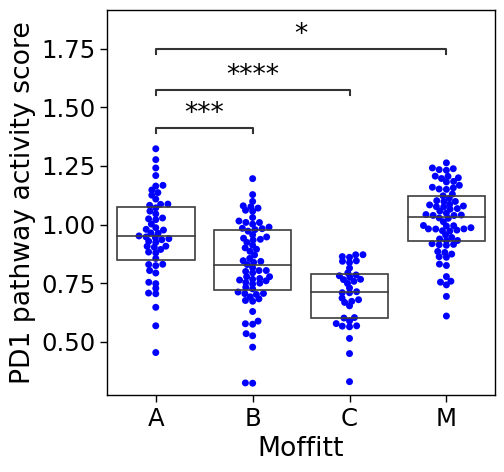

<Figure size 640x480 with 0 Axes>

In [118]:
plotting_pd1_pathway(nes,'class','PD1 pathway activity','Moffitt')

## Figure 3A and supp Plot individual enrichment scores of B cells

* box plots
* TIMEx 
* xCell and Cibersort scores as supplementary

In [119]:
paths = {'Moffitt':['paper_results/helpers/avatar_class_by_correlation.json',
                    'AVATAR/AVATAR_filtered_TIMEX.csv',
                    'AVATAR/AVATAR_CIBERSORTx.csv',
                   'AVATAR/AVATAR_xCell.csv',
                    'AVATAR/AVATAR_consensusTME.csv',
                   'AVATAR/AVATAR_MCPcounter.csv'],
         'TCGA':['paper_results/helpers/tcga_class_by_correlation.json',
             'TCGA_HNSC/HNSC/HNSC_filtered_TIMEX.csv',
                 'TCGA_HNSC/HNSC/HNSC_CIBERSORTx.csv',
                 'TCGA_HNSC/HNSC/HNSC_xCell.csv',
                 'TCGA_HNSC/HNSC/HNSC_consensusTME.csv',
                'TCGA_HNSC/HNSC/HNSC_MCPcounter.csv'],
         'CPTAC':['paper_results/helpers/cptac_class_by_correlation.json',
             'cptac_hnsc_processed_star/deconv/cptac_hnsc_star_log_collapsed_to_symbols_reg_tumor_filtered_TIMEX.csv',
                 'cptac_hnsc_processed_star/deconv/cptac_hnsc_star_log_collapsed_to_symbols_reg_tumor_CIBERSORTx.csv',
                 'cptac_hnsc_processed_star/deconv/cptac_hnsc_star_log_collapsed_to_symbols_reg_tumor_xCell.csv',
                 'cptac_hnsc_processed_star/deconv/cptac_hnsc_star_log_collapsed_to_symbols_reg_tumor_consensusTME.csv',
                 'cptac_hnsc_processed_star/deconv/cptac_hnsc_star_log_collapsed_to_symbols_reg_tumor_MCPcounter.csv']}


In [123]:

def plot_B(col_name, seq, y_label, replace_sample_name=False):
    """
    Plot B cell subpopulations as box plots cross three datasets
    params: col_name(str): selected column name of df, eg.'B cell'
    seq(int): the index of the file from paths variable, select deconvolution result file
    y_label(str): y-axis label
    replace_sample_name: in case the deconv result file was generated from R, we need to rename the sample
    """
    subtype_rename = {'Atypical':'A','Basal':'B','Classical':'C','Mesenchymal':'M'}
    sns.set_context("paper", font_scale=2)
    fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 4), sharey=False)

    for i,el in enumerate(axes.flat):
        dataset = list(paths.keys())[i]

        with open(paths[dataset][0], 'r') as fp:
            res_correlation = json.load(fp)
        path = paths[dataset][seq]
        df = pd.read_csv(path,index_col=0)
        print(df.columns)
        if replace_sample_name == True:
            df.index = df.index.str.replace('.','-')
        df = df[[col_name]]   
        # only select HPV neg samples
        if dataset == 'TCGA':
            hpv_neg = pd.read_csv('TCGA_HNSC/HPV_neg_list.txt',sep='\t',header=None)[0].to_list()
            df = df.loc[hpv_neg,:]
        if dataset == 'Moffitt':
            hpv_neg = pd.read_csv('AVATAR/HPV_neg_list.txt',sep='\t',header=None)[0].to_list()
            df = df.loc[hpv_neg,:]
        
        z_score_df = df.apply(lambda x: zscore(x,nan_policy='omit'),axis=0).apply(pd.Series)
        z_score_df.columns=df.columns.map(res_correlation)
        z_score_df.columns = [col_name]
        z_score_df.index = df.index.map(res_correlation)    
        z_score_df.index = z_score_df.index.map(subtype_rename)  


        a = sns.stripplot(x=z_score_df.index, y=col_name, data=z_score_df, zorder=0.5, color='blue',
                          order = ['A','B','C','M'],ax=axes.flatten()[i])    
        sns.boxplot(x=z_score_df.index, y=col_name, data=z_score_df, order = ['A','B','C','M'],
                     showcaps=False,boxprops={'facecolor':'None'},
                     showfliers=False,whiskerprops={'linewidth':0}, ax=axes.flatten()[i])
        #a.set(yscale="log")
        add_stat_annotation(a, x=z_score_df.index, y=col_name, data=z_score_df, 
                                order = ['A','B','C','M'], box_pairs=[('A','M'),('A','B'),('A','C')],
                                test='Mann-Whitney', comparisons_correction=None, loc='inside', verbose=2)


    axes[0].set(xlabel="Moffitt",ylabel=y_label)
    axes[1].set(xlabel="TCGA(HPV-)",ylabel='')
    axes[2].set(xlabel="CPTAC",ylabel='')
    plt.tight_layout() 

    fig_out_path = './paper_results/3_Bcell_enrichment/{0}.png'.format(y_label)
    plt.savefig(fig_out_path, format="png",dpi=500,bbox_inches = 'tight')
    plt.show()
    plt.clf()

Index(['malignant', 'others', 'stromal', 'immune', 'immune_ILC',
       'immune_Mono/Macro', 'immune_pDC', 'immune_DC', 'immune_Neutrophils',
       'immune_Mast', 'immune_NK', 'immune_CD4Tconv', 'immune_Treg',
       'immune_TMKI67', 'immune_CD8Tex', 'immune_CD8T', 'immune_Plasma',
       'immune_B', 'minor_Monocyte', 'minor_M2', 'minor_M1', 'minor_cDC2',
       'minor_cDC1', 'minor_Th17', 'minor_Th2', 'minor_Th1', 'minor_CD4Teff',
       'minor_CD4Tn', 'minor_MAIT', 'minor_CD8Teff', 'minor_CD8Tem',
       'minor_CD8Tcm', 'minor_CD8Tn', 'stromal_Others',
       'stromal_Myofibroblasts', 'stromal_Fibroblasts', 'stromal_Endothelial'],
      dtype='object')
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

A v.s. B: Mann-Whitney-Wilcoxon test two-sided, P_val=8.695e-04 U_stat=2.364e+03
A v.s. C: Mann-Whitney-Wilcoxon test two-sided, P_val=1.752e-04 U_stat=1.344e+03
A v.s. M: 

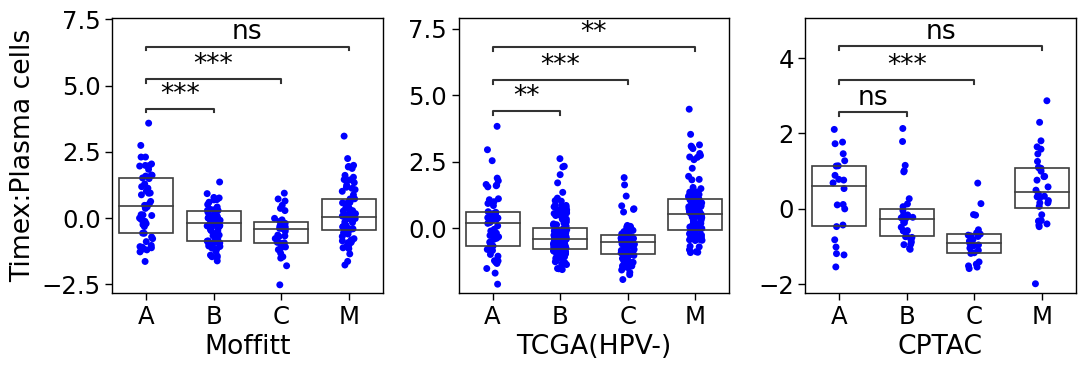

<Figure size 640x480 with 0 Axes>

In [127]:
plot_B('immune_Plasma', 1, 'Timex:Plasma cells', replace_sample_name=True)

## Figure 3E GC and Plasma enrichment in subtypes

In [128]:
paths = {'Moffitt':['paper_results/helpers/avatar_class_by_correlation.json',
                    'AVATAR/AVATAR_b_cell.csv',
                   'AVATAR/AVATAR_purity_score.json'],
         'TCGA':['paper_results/helpers/tcga_class_by_correlation.json',
                 'TCGA_HNSC/HNSC/HNSC_b_cell.csv'],
         'CPTAC':['paper_results/helpers/cptac_class_by_correlation.json',
                 'cptac_hnsc_processed_star/deconv/cptac_hnsc_star_log_collapsed_to_symbols_reg_tumor_b_cell.csv']}

b_cells_selected = [
     'GSE13411_SWITCHED_MEMORY_BCELL_VS_PLASMA_CELL_UP',
#        'GSE13411_PLASMA_CELL_VS_MEMORY_BCELL_UP',
        'GSE12366_NAIVE_VS_MEMORY_BCELL_UP',
#        'GSE12366_GC_VS_MEMORY_BCELL_UP', 
    'GSE12366_GC_VS_NAIVE_BCELL_UP',
       'GSE12366_PLASMA_CELL_VS_NAIVE_BCELL_UP',
#        'GSE12366_PLASMA_CELL_VS_MEMORY_BCELL_UP',
       #'HPV_POSITIVE_ASSOCIATED_B_CELLS', 'Be1', 'Be2', 'Breg', 'BK'
                   ]

In [130]:
# class assignment for moffitt cohort
with open(paths['Moffitt'][0], 'r') as fp:
    res_correlation = json.load(fp)
    
hpv_neg = pd.read_csv('AVATAR/HPV_neg_list.txt',sep='\t',header=None)[0].to_list()

df = pd.read_csv(paths['Moffitt'][1],index_col=0)
df = df[b_cells_selected]
df.columns = ['Switched Memory B','Naive B','GCB','Plasma']
df = df.apply(lambda x: zscore(x,nan_policy='omit'),axis=0).apply(pd.Series)
df['class'] = df.index.map(res_correlation)
df = df[df.index.isin(hpv_neg)]
df_melt = pd.melt(df, id_vars=['class'], value_vars=['Switched Memory B','Naive B','GCB','Plasma'])

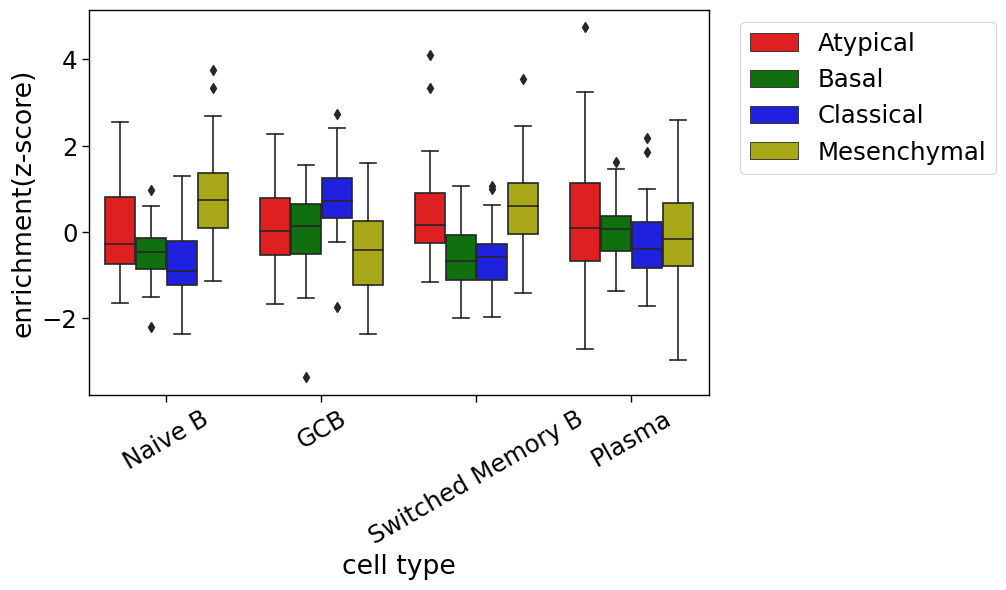

<Figure size 640x480 with 0 Axes>

In [133]:
    df_melt.columns = ['class','cell type','enrichment(z-score)']
    sns.set_context("paper", font_scale=2)

    fig = plt.gcf()
    fig.set_size_inches(8, 5)
        
    x = 'cell type'
    y = 'enrichment(z-score)'
    hue = "class"
    hue_order=['Atypical','Basal','Classical','Mesenchymal']
    box_pairs=[
            (('GCB',"Atypical"),('GCB',"Classical")),
        (('Plasma',"Atypical"),('Plasma',"Classical"))
            ]
    ax = sns.boxplot(data=df_melt, x=x, y=y, hue=hue,hue_order=hue_order,palette=sns.color_palette(('r', 'g','b','y')),
                         order = ['Naive B','GCB','Switched Memory B','Plasma'])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#     add_stat_annotation(ax, data=df_melt, x=x, y=y, hue=hue,hue_order=hue_order,
#                             order = ['Naive B','GCB','Switched Memory B','Plasma'], box_pairs=box_pairs,
#                             test='Mann-Whitney', comparisons_correction=None, loc='inside', verbose=2)
    plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
    plt.savefig('paper_results/3_GC_and_plasma_enrichment/Moffitt.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()

# Figure 4
# Figure 4b B cell differentiation signature

1. Sig1: Using signature from [HPV specific B cell signatures](https://www.nature.com/articles/s41586-020-2931-3),show z-score heatmap. 
2. Sig2: [C7 signatures](https://www.biorxiv.org/content/10.1101/2020.05.29.123265v1.full#disqus_thread). 

* Moffitt cohort(main figure)
* TCGA including HPV+ as comparison

In [135]:
paths = {'Moffitt':['paper_results/helpers/avatar_class_by_correlation.json',
                    'AVATAR/HN_v0.4.3_RNAseq_counts_library_size_normalized_log2.txt'],
         'TCGA':['paper_results/helpers/tcga_class_by_correlation.json',
                 'TCGA_HNSC/HNSC.txt'],
         'CPTAC':['paper_results/helpers/cptac_class_by_correlation.json',
                 'cptac_hnsc_processed_star/cptac_hnsc_star_log/cptac_hnsc_star_log_collapsed_to_symbols_reg_tumor.txt']}

with open('paper_results/helpers/hpv_pos_bcell_signatures.json', 'r') as fp:
    hpv_pos_signatures = json.load(fp)

* 1. Moffitt cohort

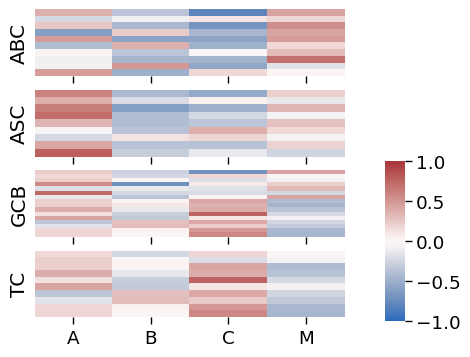

<Figure size 640x480 with 0 Axes>

In [141]:
fig, axn = plt.subplots(4, 1, sharey=False,sharex=True)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax = fig.add_axes([1, .1, .05, .4])
fig.set_size_inches(4, 4)
sns.set_context("paper", font_scale=1.5)
for i, ax in enumerate(axn.flat):
    
    dataset = list(paths.keys())[0]
    
    with open(paths[dataset][0], 'r') as fp:
        res_correlation = json.load(fp)
    path = paths[dataset][1]
    df = pd.read_csv(path,sep='\t',index_col=0)
    
    #filter out HPV+ samples
    if dataset == 'Moffitt':
        hpv_neg = pd.read_csv('AVATAR/HPV_neg_list.txt',sep='\t',header=None)[0].to_list()
        df = df[hpv_neg]
    elif dataset == 'TCGA':
        hpv_neg = pd.read_csv('TCGA_HNSC/HPV_neg_list.txt',sep='\t',header=None)[0].to_list()
        df = df[hpv_neg]    
    
    signature = list(hpv_pos_signatures.values())[i]    
    df = df.loc[signature,:]
    z_score_df = df.apply(lambda x: zscore(x,nan_policy='omit'),axis=1).apply(pd.Series)
    z_score_df.columns=df.columns.map(res_correlation)
    df = z_score_df.T.reset_index().groupby('index').mean().T

    sns.heatmap(df, ax=ax,cmap="vlag",annot=False,xticklabels=['A','B','C','M'],
                yticklabels='',
                cbar=i == 0,
                vmin=-1, vmax=1,
                cbar_ax=None if i else cbar_ax)

# fig.tight_layout(rect=[0, 0, 0.9, 1])

axn[0].set(xlabel="",ylabel='ABC')
axn[1].set(xlabel="",ylabel='ASC')
axn[2].set(xlabel="",ylabel='GCB')
axn[3].set(xlabel="",ylabel='TC')

fig_out_path = 'paper_results/3_B_signature/Moffitt_B_clusters.png'
plt.savefig(fig_out_path, format="png",dpi=150,bbox_inches = 'tight')
plt.show()
plt.clf()

* 2. TCGA: put HPV+ as a seperate group in comparisons

In [252]:
# HPV status annotation
path = 'hnsc_tcga_pan_can_atlas_2018_clinical_data.tsv'
anno = pd.read_csv(path,sep='\t')
hpv_neg = anno[anno['Subtype']=='HNSC_HPV-']['Sample ID'].to_list()
hpv_pos = anno[anno['Subtype']=='HNSC_HPV+']['Sample ID'].to_list()

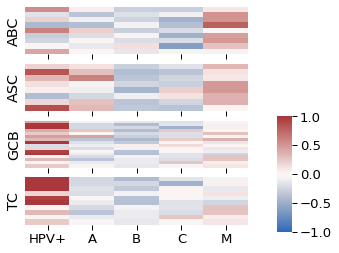

<Figure size 432x288 with 0 Axes>

In [253]:
fig, axn = plt.subplots(4, 1, sharey=False,sharex=True)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax = fig.add_axes([1, .1, .05, .4])
fig.set_size_inches(4, 4)
sns.set_context("paper", font_scale=1.5)
for i, ax in enumerate(axn.flat):
    
    dataset = list(paths.keys())[1]
    
    with open(paths[dataset][0], 'r') as fp:
        res_correlation = json.load(fp)
    path = paths[dataset][1]
    df = pd.read_csv(path,sep='\t',index_col=0)
    
    signature = list(hpv_pos_signatures.values())[i]
    
    df = df.loc[signature,:]
    z_score_df = df.apply(lambda x: zscore(x,nan_policy='omit'),axis=1).apply(pd.Series)
#     z_score_df.columns=df.columns.map(res_correlation)
    z_score_df.columns=df.columns
    z_score_df_hpv_pos = z_score_df[hpv_pos]
    z_score_df_hpv_neg = z_score_df[hpv_neg]
    z_score_df_hpv_pos.columns = ['HPV+']*len(z_score_df_hpv_pos.columns)    
    z_score_df_hpv_neg.columns = z_score_df_hpv_neg.columns.map(res_correlation)
    z_score_df = pd.concat([z_score_df_hpv_neg, z_score_df_hpv_pos], axis=1)    
    df = z_score_df.T.reset_index().groupby('index').mean().T
    df = df[['HPV+','Atypical','Basal','Classical','Mesenchymal']]

    sns.heatmap(df, ax=ax,cmap="vlag",annot=False,xticklabels=['HPV+','A','B','C','M'],
                yticklabels='',
                cbar=i == 0,
                vmin=-1, vmax=1,
                cbar_ax=None if i else cbar_ax)

# fig.tight_layout(rect=[0, 0, 0.9, 1])

axn[0].set(xlabel="",ylabel='ABC')
axn[1].set(xlabel="",ylabel='ASC')
axn[2].set(xlabel="",ylabel='GCB')
axn[3].set(xlabel="",ylabel='TC')

fig_out_path ='paper_results/3_B_signature/TCGA_B_clusters.png'
plt.savefig(fig_out_path, format="png",dpi=150,bbox_inches = 'tight')
plt.show()
plt.clf()

* 3. CPTAC cohort

/opt/anaconda3/envs/deconvolution/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


<Figure size 640x480 with 0 Axes>

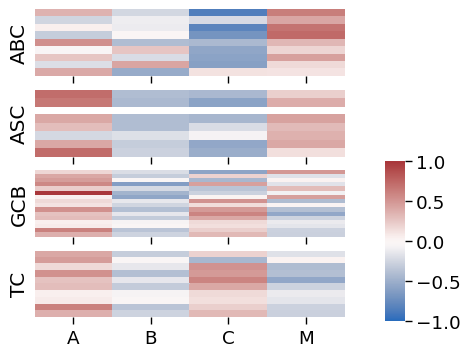

In [147]:
fig, axn = plt.subplots(4, 1, sharey=False,sharex=True)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax = fig.add_axes([1, .1, .05, .4])
fig.set_size_inches(4, 4)
sns.set_context("paper", font_scale=1.5)
for i, ax in enumerate(axn.flat):
    
    dataset = list(paths.keys())[2]
    
    with open(paths[dataset][0], 'r') as fp:
        res_correlation = json.load(fp)
    path = paths[dataset][1]
    df = pd.read_csv(path,sep='\t',index_col=0)
    
    signature = list(hpv_pos_signatures.values())[i]
    
    df = df.loc[signature,:]
    z_score_df = df.apply(lambda x: zscore(x,nan_policy='omit'),axis=1).apply(pd.Series)
    z_score_df.columns=df.columns.map(res_correlation)
    df = z_score_df.T.reset_index().groupby('index').mean().T

    sns.heatmap(df, ax=ax,cmap="vlag",annot=False,xticklabels=['A','B','C','M'],
                yticklabels='',
                cbar=i == 0,
                vmin=-1, vmax=1,
                cbar_ax=None if i else cbar_ax)

# fig.tight_layout(rect=[0, 0, 0.9, 1])

axn[0].set(xlabel="",ylabel='ABC')
axn[1].set(xlabel="",ylabel='ASC')
axn[2].set(xlabel="",ylabel='GCB')
axn[3].set(xlabel="",ylabel='TC')

fig_out_path = 'paper_results/3_B_signature/CPTAC_B_clusters.png'
plt.savefig(fig_out_path, format="png",dpi=150,bbox_inches = 'tight')
plt.show()
plt.clf()

## Fig4c 3D PCA plot

in notbook `EGFR_HNSC`

In [143]:
from sklearn.decomposition import PCA
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 

with open(paths['Moffitt'][0], 'r') as fp:
    res_correlation = json.load(fp)
hpv_neg = pd.read_csv('AVATAR/HPV_neg_list.txt',sep='\t',header=None)[0].to_list()    
    
df = pd.read_csv('AVATAR/HN_v0.4.3_RNAseq_counts_library_size_normalized_log2.txt',sep='\t',index_col=0)

signature = list(hpv_pos_signatures.values())

signature = list(itertools.chain.from_iterable(signature))
df = df.loc[signature,:]
df = df[hpv_neg]
z_score_df = df.apply(lambda x: zscore(x,nan_policy='omit'),axis=1).apply(pd.Series)
z_score_df.columns=df.columns.map(res_correlation)
#df = z_score_df.T.reset_index().groupby('index').mean().T
z_score_df = z_score_df.dropna()
X = np.array(z_score_df.T)
Y = np.array(z_score_df.columns)

In [144]:
X.shape

(224, 45)

In [145]:
pca = PCA(n_components=3)
projected = pca.fit_transform(X)
res = pd.DataFrame(projected,columns=['x','y','z'])
res['class'] = Y

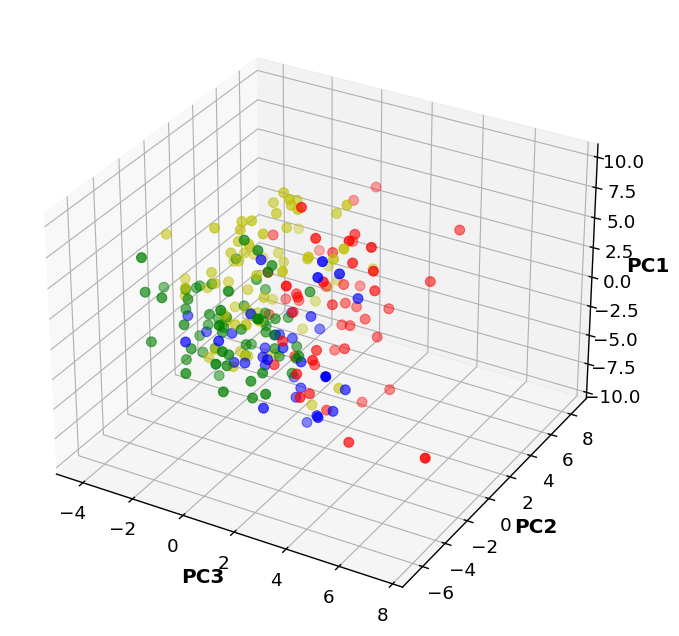

In [147]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(res['z'], res['y'], res['x'], c=res['class'].map({'Basal':'g',
                                                               'Atypical':'r',
                                                               'Mesenchymal':'y',
                                                               'Classical':'b'}),
            s=50);

ax.set_xlabel('PC3',fontweight ='bold')
ax.set_ylabel('PC2',fontweight ='bold')
ax.set_zlabel('PC1',fontweight ='bold')

# rotate the axes and update
# for angle in range(0, 360):
#     ax.view_init(60, angle)
fig_out_path = 'paper_results/3_B_signature/PCA.png'
plt.savefig(fig_out_path, format="png",dpi=150,bbox_inches = 'tight')
plt.show()

# Fig 4

## Fig 4a GCB signatures from JEM paper

1. build .gmt signature file from the collected signatures.
2. Using the signatures to run ssGSEA for samples and analysis the distribution of GCB cell stages in different molecular subtypes.
    * differentiation stages
    * signalings

resource: 

* [Single-cell analysis of germinal-center B cells informs on lymphoma cell of origin and outcome](https://rupress.org/jem/article/217/10/e20200483/151908/Single-cell-analysis-of-germinal-center-B-cells)

In [162]:
paths = {'Moffitt':['paper_results/helpers/avatar_class_by_correlation.json',
                    'AVATAR/AVATAR_gcb.csv'],
         'TCGA':['paper_results/helpers/tcga_class_by_correlation.json',
                 'TCGA_HNSC/HNSC/HNSC_gcb.csv'],
         'CPTAC':['paper_results/helpers/cptac_class_by_correlation.json',
                 'cptac_hnsc_processed_star/deconv/cptac_hnsc_star_log_collapsed_to_symbols_reg_tumor_gcb.csv']}


In [151]:
    #correlation scatter plot
    def corrfunc(x, y, **kws):
        (r, p) = pearsonr(x, y)
        ax = plt.gca()
        ax.annotate("r = {:.2f} ".format(r),
                    xy=(.1, .9), xycoords=ax.transAxes)
        ax.annotate("p = {:.3f}".format(p),
                    xy=(.1, .8), xycoords=ax.transAxes)


    def plot_corr(df,hue=None,plot_kws={'line_kws':{'color':'green'}}, stat=True, subset=None):
        #df = self.cell_type_map[cell_type]
        if subset:
            df = df[subset]
        print("sample count:{0}, method count:{1}".format(df.shape[0],df.shape[1]))
        if df.shape == (0,0):
            print("cell type {0} score not available, skip....".format(cell_type))
            return
        #plot_dir = os.path.join(self.input_dir,'output_plot')
#         if not os.path.exists(plot_dir):
#             os.makedirs(plot_dir)
#         plot_path = os.path.join(plot_dir,cell_type+'_'+self.dataset+'.png')
        sns.set_context("paper", font_scale=2)  
        # if sample number <=5 then plot correlation heatmap
        if df.shape[0] <= 5:
            sns.set_context("paper", font_scale=1)  
            #plt.figure(figsize=(10, 8))
            graph = sns.heatmap(round(df.corr(),2), vmin=-1, vmax=1,square=True,annot=True,cmap='RdBu_r',annot_kws={"fontsize":10})
            graph.set_title(cell_type)
            plt.savefig(plot_path, bbox_inches='tight')
            plt.clf()
        else:
            graph = sns.pairplot(df.round(6),hue=hue,plot_kws=plot_kws,corner=True,kind="reg")
            if stat==True:
                graph.map_lower(corrfunc)
#             graph.fig.suptitle(cell_type, y=1.08)
#             graph.savefig(plot_path)
            plt.show()

### Moffit cohort

In [153]:
# class assignment for moffitt cohort
data_name = 'Moffitt'
with open(paths[data_name][0], 'r') as fp:
    res_correlation = json.load(fp)
hpv_neg = pd.read_csv('AVATAR/HPV_neg_list.txt',sep='\t',header=None)[0].to_list()    
    
    
df = pd.read_csv(paths[data_name][1],index_col=0)
df = df.apply(lambda x: zscore(x,nan_policy='omit'),axis=0).apply(pd.Series)
df = df[df.index.isin(hpv_neg)]
df['class'] = df.index.map(res_correlation)
temp = df.groupby('class').mean()
temp = temp.T[['Atypical', 'Basal', 'Classical', 'Mesenchymal']]

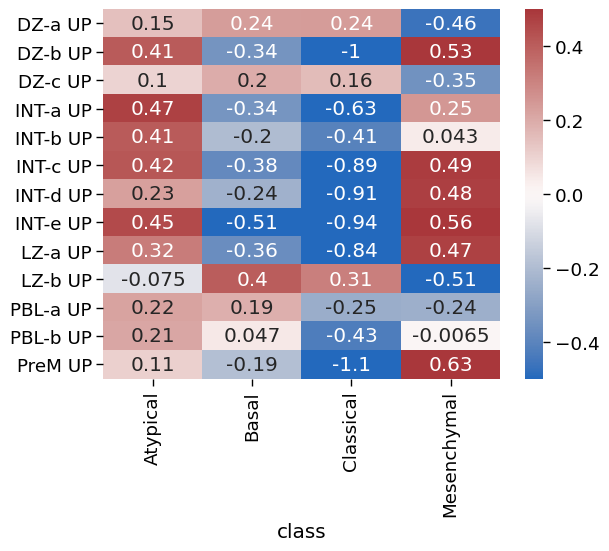

In [150]:
sns.set_context("paper", font_scale=1.5)
fig.set_size_inches(8, 8)
g = sns.heatmap(temp.T, annot=True,vmin=-0.5, vmax=0.5,cmap="vlag")
save_path = "paper_results/4_GCB/{0}.png".format(data_name)
plt.savefig(save_path, format="png",dpi=150,bbox_inches = 'tight')

In [154]:
temp.corr()

class        Atypical     Basal  Classical  Mesenchymal
class                                                  
Atypical     1.000000 -0.845607  -0.622664     0.621941
Basal       -0.845607  1.000000   0.895266    -0.925410
Classical   -0.622664  0.895266   1.000000    -0.987891
Mesenchymal  0.621941 -0.925410  -0.987891     1.000000

sample count:13, method count:4


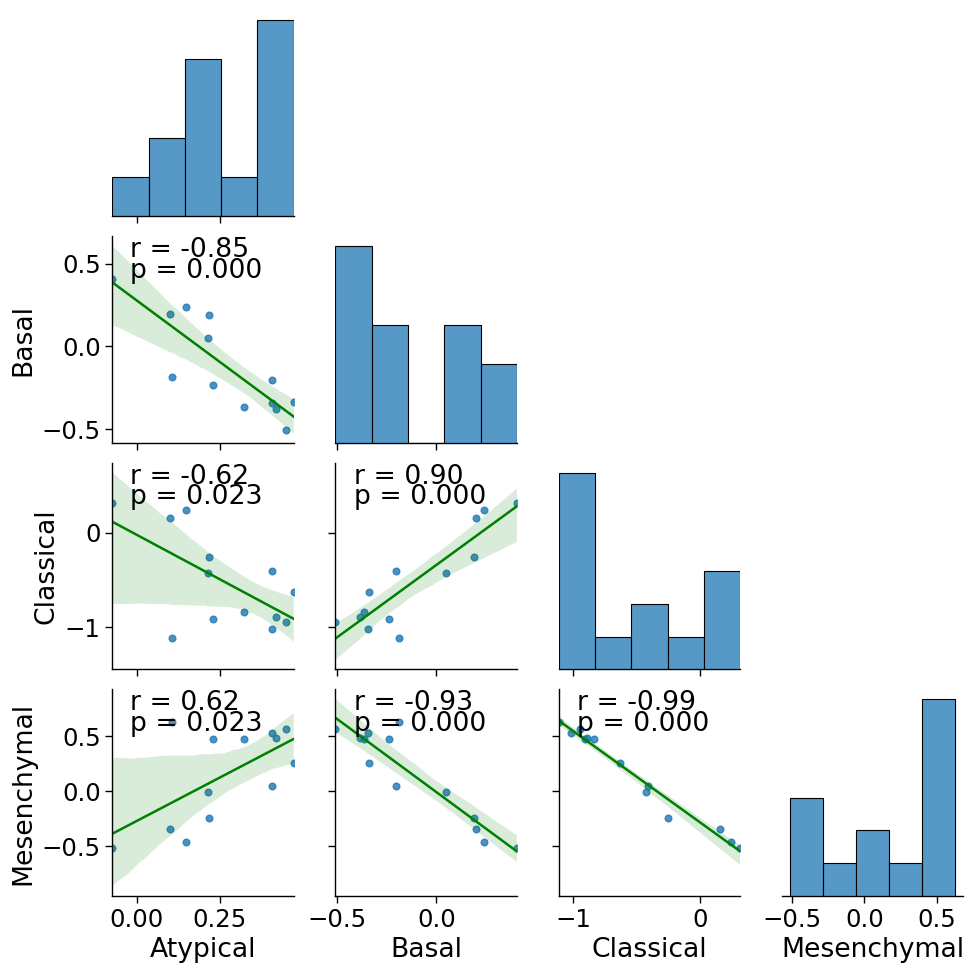

In [155]:
plot_corr(temp)

### CPTAC

In [239]:
data_name = 'CPTAC'
with open(paths[data_name][0], 'r') as fp:
    res_correlation = json.load(fp)

df = pd.read_csv(paths[data_name][1],index_col=0)
df = df.apply(lambda x: zscore(x,nan_policy='omit'),axis=0).apply(pd.Series)
df['class'] = df.index.map(res_correlation)
temp = df.groupby('class').mean()

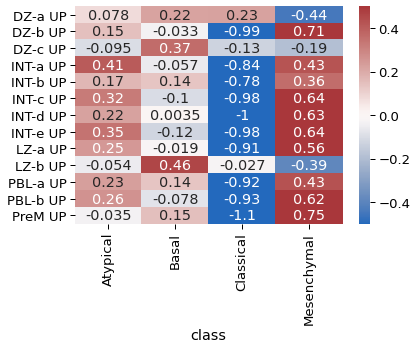

In [240]:
sns.set_context("paper", font_scale=1.5)
fig.set_size_inches(8, 8)
g = sns.heatmap(temp.T, annot=True,vmin=-0.5, vmax=0.5,cmap="vlag")
save_path = "paper_results/4_GCB/{0}.png".format(data_name)
plt.savefig(save_path, format="png",dpi=150,bbox_inches = 'tight')

### TCGA

In [119]:
hpv_pos_mapping = { i : 'HPV+' for i in hpv_pos }

In [496]:
data_name = 'TCGA'
with open(paths[data_name][0], 'r') as fp:
    res_correlation = json.load(fp)
hpv_neg = pd.read_csv('TCGA_HNSC/HPV_neg_list.txt',sep='\t',header=None)[0].to_list()

df = pd.read_csv(paths[data_name][1],index_col=0)
df = df.apply(lambda x: zscore(x,nan_policy='omit'),axis=0).apply(pd.Series)
df_pos = df[df.index.isin(hpv_pos)]
df_neg = df[df.index.isin(hpv_neg)]

df_neg['class'] = df_neg.index.map(res_correlation)
df_pos['class'] = df_pos.index.map(hpv_pos_mapping)
df = pd.concat([df_neg, df_pos], axis=0)    
temp = df.groupby('class').mean()
temp = temp.T[['HPV+', 'Atypical', 'Basal', 'Classical', 'Mesenchymal']]

<ipython-input-496-e2e95e2c340d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['class'] = df_neg.index.map(res_correlation)
<ipython-input-496-e2e95e2c340d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos['class'] = df_pos.index.map(hpv_pos_mapping)


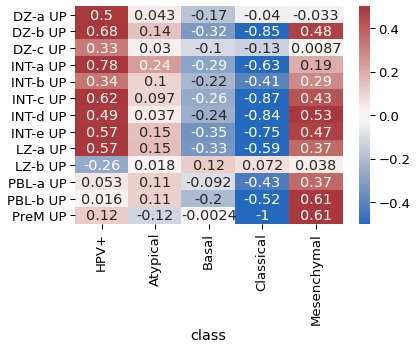

In [256]:
sns.set_context("paper", font_scale=1.5)
fig.set_size_inches(8, 8)
g = sns.heatmap(temp, annot=True,vmin=-0.5, vmax=0.5,cmap="vlag")
save_path = "paper_results/4_GCB/{0}.png".format(data_name)
plt.savefig(save_path, format="png",dpi=150,bbox_inches = 'tight')

In [299]:
temp.corr()

class            HPV+  Atypical     Basal  Classical  Mesenchymal
class                                                            
HPV+         1.000000  0.556405 -0.855090  -0.458663     0.059674
Atypical     0.556405  1.000000 -0.714750  -0.053714    -0.034190
Basal       -0.855090 -0.714750  1.000000   0.494072    -0.332686
Classical   -0.458663 -0.053714  0.494072   1.000000    -0.852942
Mesenchymal  0.059674 -0.034190 -0.332686  -0.852942     1.000000

sample count:13, method count:5


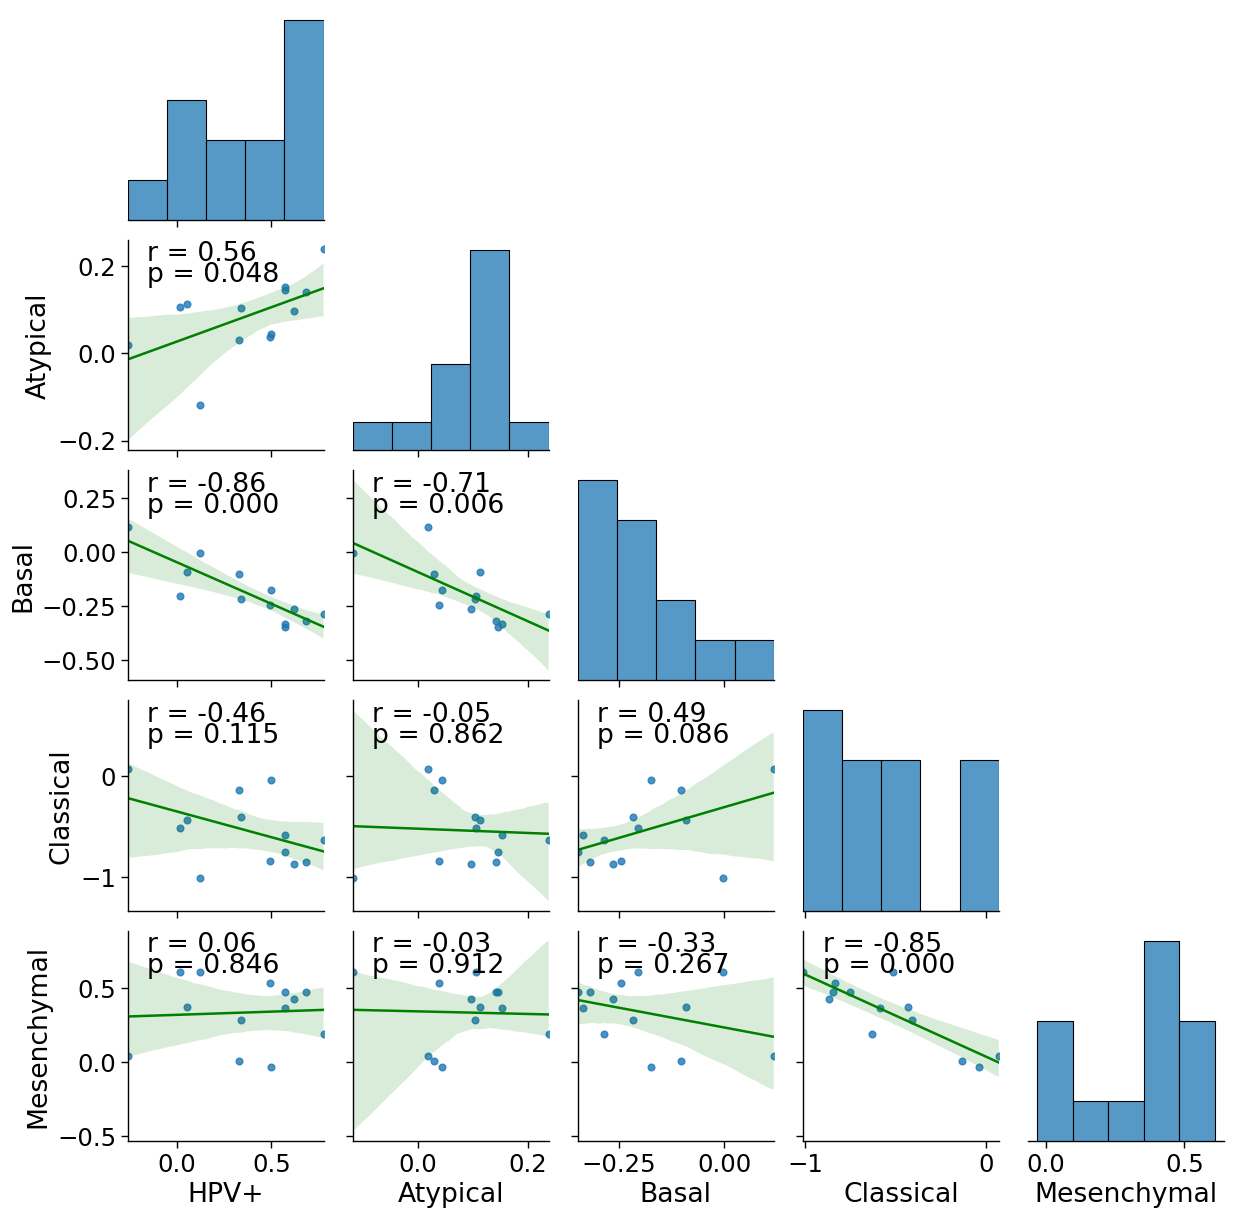

In [508]:
plot_corr(temp)

### LZ pathways

Moffitt

In [176]:
paths = {'Moffitt':['paper_results/helpers/avatar_class_by_correlation.json',
                    'AVATAR/HN_v0.4.3_RNAseq_counts_library_size_normalized_log2.txt'],
         'TCGA':['paper_results/helpers/tcga_class_by_correlation.json',
                 'TCGA_HNSC/HNSC.txt'],
         'CPTAC':['paper_results/helpers/cptac_class_by_correlation.json',
                 'cptac_hnsc_processed_star/cptac_hnsc_star_log/cptac_hnsc_star_log_collapsed_to_symbols_reg_tumor.txt']}

with open('paper_results/helpers/LZB_signatures.json', 'r') as fp:
    LZB_signatures = json.load(fp)
hpv_neg = pd.read_csv('AVATAR/HPV_neg_list.txt',sep='\t',header=None)[0].to_list()    
    
del LZB_signatures['NFkB']
del LZB_signatures['MYC']
del LZB_signatures['DZ']

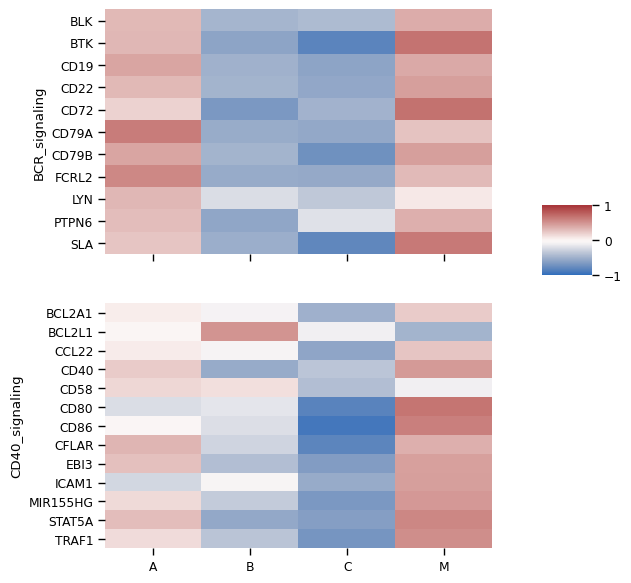

<Figure size 640x480 with 0 Axes>

In [177]:
fig, axn = plt.subplots(2, 1, sharey=False,sharex=True)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax = fig.add_axes([1, .5, .1, .1])
fig.set_size_inches(5, 7)
sns.set_context("paper", font_scale=1)
for i, ax in enumerate(axn.flat):
    
    dataset = list(paths.keys())[0]
    
    with open(paths[dataset][0], 'r') as fp:
        res_correlation = json.load(fp)
    path = paths[dataset][1]
    df = pd.read_csv(path,sep='\t',index_col=0)
    
    signature = list(LZB_signatures.values())[i]
    
    #df = df.loc[signature,:]
    df = df[df.index.isin(signature)]
    df = df[hpv_neg]
    z_score_df = df.apply(lambda x: zscore(x,nan_policy='omit'),axis=1).apply(pd.Series)
    z_score_df.columns=df.columns.map(res_correlation)
    df = z_score_df.T.reset_index().groupby('index').mean().T
    df = df[['Atypical','Basal','Classical','Mesenchymal']]

    sns.heatmap(df, ax=ax,cmap="vlag",annot=False,xticklabels=['A','B','C','M'],
                cbar=i == 0,
                vmin=-1, vmax=1,
                cbar_ax=None if i else cbar_ax)

# fig.tight_layout(rect=[0, 0, 0.9, 1])

axn[0].set(xlabel="",ylabel='BCR_signaling')
axn[1].set(xlabel="",ylabel='CD40_signaling')
# axn[2].set(xlabel="",ylabel='PreM')
# axn[3].set(xlabel="",ylabel='PBL')


fig_out_path = 'paper_results/4_LZ/BCR_CD40.png'
plt.savefig(fig_out_path, format="png",dpi=150,bbox_inches = 'tight')
plt.show()
plt.clf()

In [178]:
del LZB_signatures['BCR_signaling']
del LZB_signatures['CD40_signaling']

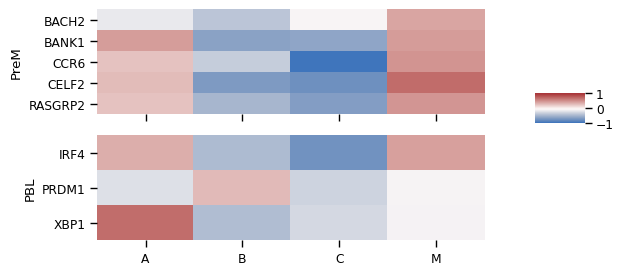

<Figure size 640x480 with 0 Axes>

In [179]:
fig, axn = plt.subplots(2, 1, sharey=False,sharex=True)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax = fig.add_axes([1, .5, .1, .1])
fig.set_size_inches(5, 3)
sns.set_context("paper", font_scale=1)
for i, ax in enumerate(axn.flat):
    
    dataset = list(paths.keys())[0]
    
    with open(paths[dataset][0], 'r') as fp:
        res_correlation = json.load(fp)
    path = paths[dataset][1]
    df = pd.read_csv(path,sep='\t',index_col=0)
    
    signature = list(LZB_signatures.values())[i]
    
    #df = df.loc[signature,:]
    df = df[df.index.isin(signature)]
    df = df[hpv_neg]
    z_score_df = df.apply(lambda x: zscore(x,nan_policy='omit'),axis=1).apply(pd.Series)
    z_score_df.columns=df.columns.map(res_correlation)
    df = z_score_df.T.reset_index().groupby('index').mean().T
    df = df[['Atypical','Basal','Classical','Mesenchymal']]

    sns.heatmap(df, ax=ax,cmap="vlag",annot=False,xticklabels=['A','B','C','M'],
                cbar=i == 0,
                vmin=-1, vmax=1,
                cbar_ax=None if i else cbar_ax)

# fig.tight_layout(rect=[0, 0, 0.9, 1])

axn[0].set(xlabel="",ylabel='PreM')
axn[1].set(xlabel="",ylabel='PBL')



fig_out_path = 'paper_results/4_LZ/PreM_PBL.png'
plt.savefig(fig_out_path, format="png",dpi=150,bbox_inches = 'tight')
plt.show()
plt.clf()

# Fig 5

## Ig isotypes

In [124]:
paths = {'Moffitt':['paper_results/helpers/avatar_class_by_correlation.json',
                    'AVATAR/HN_v0.4.3_RNAseq_counts_library_size_normalized_log2.txt',
                    'AVATAR/AVATAR_filtered_TIMEX.csv',
                    'AVATAR/AVATAR_xCell.csv'],
         'TCGA':['paper_results/helpers/tcga_class_by_correlation.json',
                 'TCGA_HNSC/HNSC.txt',
                 'TCGA_HNSC/HNSC/HNSC_filtered_TIMEX.csv',
                 'TCGA_HNSC/HNSC/HNSC_xCell.csv'],
         'CPTAC':['paper_results/helpers/cptac_class_by_correlation.json',
                 'cptac_hnsc_processed_star/cptac_hnsc_star_log/cptac_hnsc_star_log_collapsed_to_symbols_reg_tumor.txt',
                 'cptac_hnsc_processed_star/deconv/cptac_hnsc_star_log_collapsed_to_symbols_reg_tumor_filtered_TIMEX.csv',
                 'cptac_hnsc_processed_star/deconv/cptac_hnsc_star_log_collapsed_to_symbols_reg_tumor_xCell.csv']}

with open('paper_results/helpers/hpv_pos_bcell_signatures.json', 'r') as fp:
    hpv_pos_signatures = json.load(fp)

In [62]:
path = 'hnsc_tcga_pan_can_atlas_2018_clinical_data.tsv'
anno = pd.read_csv(path,sep='\t')
hpv_neg = anno[anno['Subtype']=='HNSC_HPV-']['Sample ID'].to_list()


In [4]:
df = pd.read_csv(paths['Moffitt'][2],index_col=0)

In [5]:
df.columns

Index(['malignant', 'others', 'stromal', 'immune', 'immune_ILC',
       'immune_Mono/Macro', 'immune_pDC', 'immune_DC', 'immune_Neutrophils',
       'immune_Mast', 'immune_NK', 'immune_CD4Tconv', 'immune_Treg',
       'immune_TMKI67', 'immune_CD8Tex', 'immune_CD8T', 'immune_Plasma',
       'immune_B', 'minor_Monocyte', 'minor_M2', 'minor_M1', 'minor_cDC2',
       'minor_cDC1', 'minor_Th17', 'minor_Th2', 'minor_Th1', 'minor_CD4Teff',
       'minor_CD4Tn', 'minor_MAIT', 'minor_CD8Teff', 'minor_CD8Tem',
       'minor_CD8Tcm', 'minor_CD8Tn', 'stromal_Others',
       'stromal_Myofibroblasts', 'stromal_Fibroblasts', 'stromal_Endothelial'],
      dtype='object')

In [6]:
df = pd.read_csv(paths['Moffitt'][3],index_col=0)

In [7]:
df.columns

Index(['Myeloid dendritic cell activated', 'B cell', 'T cell CD4+ memory',
       'T cell CD4+ naive', 'T cell CD4+ (non-regulatory)',
       'T cell CD4+ central memory', 'T cell CD4+ effector memory',
       'T cell CD8+ naive', 'T cell CD8+', 'T cell CD8+ central memory',
       'T cell CD8+ effector memory', 'Class-switched memory B cell',
       'Common lymphoid progenitor', 'Common myeloid progenitor',
       'Myeloid dendritic cell', 'Endothelial cell', 'Eosinophil',
       'Cancer associated fibroblast', 'Granulocyte-monocyte progenitor',
       'Hematopoietic stem cell', 'Macrophage', 'Macrophage M1',
       'Macrophage M2', 'Mast cell', 'B cell memory', 'Monocyte',
       'B cell naive', 'Neutrophil', 'NK cell', 'T cell NK',
       'Plasmacytoid dendritic cell', 'B cell plasma', 'T cell gamma delta',
       'T cell CD4+ Th1', 'T cell CD4+ Th2', 'T cell regulatory (Tregs)',
       'immune score', 'stroma score', 'microenvironment score'],
      dtype='object')

In [36]:
igg_cell_list = ['minor_Monocyte','immune_Neutrophils','immune_NK','Common myeloid progenitor']
igm_cell_list = ['Macrophage','Common lymphoid progenitor','immune_B']
iga_cell_list = ['immune_DC','immune_Mono/Macro','immune_Neutrophils','Eosinophil']
ige_cell_list = ['immune_DC', 'immune_Mast','Eosinophil']

total_cell = list(set(igg_cell_list + igm_cell_list + iga_cell_list + ige_cell_list))

In [37]:
igg_gene_list = ['FCGR1A','FCGR2A','FCGR3A']
igm_gene_list = ['FCAMR']
iga_gene_list = ['PIGR','FCAMR','FCAR']
ige_gene_list = ['FCER1G','FCER2']

total = list(set(igg_gene_list+igm_gene_list+iga_gene_list+ige_gene_list))

In [38]:
total

['FCGR1A', 'FCAR', 'FCGR2A', 'FCAMR', 'FCGR3A', 'FCER1G', 'PIGR', 'FCER2']

In [140]:
df = pd.read_csv(paths['TCGA'][1],index_col=0,sep='\t')

In [141]:
gene_df = df[df.index.isin(total)].T

In [142]:
timex = pd.read_csv(paths['TCGA'][2],index_col=0)
timex.index = timex.index.str.replace('.','-')
xcell = pd.read_csv(paths['TCGA'][3],index_col=0)
xcell.index = xcell.index.str.replace('.','-')

In [148]:
full = pd.concat([gene_df, timex,xcell], axis=1)

In [149]:
full = full[total_cell+total]

In [102]:
#full = full[full.index.isin(hpv_neg)]

In [150]:
full

immune_Mast  immune_Mono/Macro  Macrophage  \
Input Sample                                                  
TCGA-4P-AA8J-01     0.136466           0.339304    0.034069   
TCGA-BA-4074-01     0.165409           0.321523    0.024978   
TCGA-BA-4076-01     0.118808           0.296644    0.007197   
TCGA-BA-4078-01     0.097141           0.303778    0.009423   
TCGA-BA-5149-01     0.122385           0.322215    0.003573   
...                      ...                ...         ...   
TCGA-UF-A7JT-01     0.158774           0.397701    0.100464   
TCGA-UF-A7JV-01     0.195143           0.400668    0.070050   
TCGA-UP-A6WW-01     0.109191           0.329041    0.029614   
TCGA-WA-A7GZ-01     0.094905           0.271470    0.000000   
TCGA-WA-A7H4-01     0.130743           0.300229    0.009232   

                 Common myeloid progenitor  immune_DC  immune_NK  \
Input Sample                                                       
TCGA-4P-AA8J-01               1.913882e-18   0.362958   0.151895   
TCGA-BA-4074-01               0.000000e+00   0.324620   0.119586   
TCGA-BA-4076-01               3.836114e-18   0.246191   0.072717   
TCGA-BA-4078-01               0.000000e+00   0.325370   0.097925   
TCGA-BA-5149-01               1.459978e-18   0.308824   0.145011   
...                                    ...        ...        ...   
TCGA-UF-A7JT-01               0.000000e+00   0.432441   0.276893   
TCGA-UF-A7JV-01               5.032288e-18   0.409023   0.218472   
TCGA-UP-A6WW-01               0.000000e+00   0.365546   0.149478   
TCGA-WA-A7GZ-01               9.856373e-19   0.225463   0.032609   
TCGA-WA-A7H4-01               0.000000e+00   0.279882   0.064016   

                 immune_Neutrophils  immune_B  minor_Monocyte    Eosinophil  \
Input Sample                                                                  
TCGA-4P-AA8J-01            0.204024  0.311775        0.285618  3.324780e-20   
TCGA-BA-4074-01            0.220427  0.304386        0.322562  0.000000e+00   
TCGA-BA-4076-01            0.137251  0.232136        0.282300  1.434972e-03   
TCGA-BA-4078-01            0.101553  0.288360        0.240807  0.000000e+00   
TCGA-BA-5149-01            0.169738  0.263458        0.308688  0.000000e+00   
...                             ...       ...             ...           ...   
TCGA-UF-A7JT-01            0.290075  0.340939        0.370760  0.000000e+00   
TCGA-UF-A7JV-01            0.282173  0.312444        0.347539  1.650549e-03   
TCGA-UP-A6WW-01            0.188109  0.351548        0.276813  5.721492e-21   
TCGA-WA-A7GZ-01            0.098497  0.241012        0.254245  6.074906e-21   
TCGA-WA-A7H4-01            0.115040  0.272389        0.271095  1.667788e-03   

                 Common lymphoid progenitor    FCGR1A     FCAR    FCGR2A  \
Input Sample                                                               
TCGA-4P-AA8J-01                    0.035209  101.6550   0.6162  1019.870   
TCGA-BA-4074-01                    0.222978   19.5928  19.2691  1897.620   
TCGA-BA-4076-01                    0.073100    9.8701   0.5247   371.507   
TCGA-BA-4078-01                    0.028009   78.9783   4.3973   850.750   
TCGA-BA-5149-01                    0.049874   24.9624   1.0267   414.784   
...                                     ...       ...      ...       ...   
TCGA-UF-A7JT-01                    0.061571  378.3510   3.4632  2412.120   
TCGA-UF-A7JV-01                    0.040754  126.8830  30.7604  3627.030   
TCGA-UP-A6WW-01                    0.068047   83.6284   2.7884   681.422   
TCGA-WA-A7GZ-01                    0.030861    9.3089   0.8639   428.942   
TCGA-WA-A7H4-01                    0.027446   27.2436   1.6026   520.833   

                  FCAMR     FCGR3A     FCER1G        PIGR   FCER2  
Input Sample                                                       
TCGA-4P-AA8J-01  1.8487  1180.7100   677.2450     32.0444  9.2436  
TCGA-BA-4074-01  0.3854   451.6670   430.4710     56.6511  3.8538  
TCGA-BA-4076-01  0.0000

In [151]:
z_score_df = full.apply(lambda x: zscore(x,nan_policy='omit'),axis=0).apply(pd.Series)
z_score_df.columns=full.columns

In [132]:
with open(paths['TCGA'][0], 'r') as fp:
    res_correlation = json.load(fp)

In [152]:
z_score_df_pos = z_score_df[z_score_df.index.isin(hpv_pos)]
z_score_df_neg = z_score_df[z_score_df.index.isin(hpv_neg)]

z_score_df_neg['class'] = z_score_df_neg.index.map(res_correlation)
z_score_df_pos['class'] = z_score_df_pos.index.map(hpv_pos_mapping)

z_score_df = pd.concat([z_score_df_neg, z_score_df_pos], axis=0)  

<ipython-input-152-17e62cb51bde>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_score_df_neg['class'] = z_score_df_neg.index.map(res_correlation)
<ipython-input-152-17e62cb51bde>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_score_df_pos['class'] = z_score_df_pos.index.map(hpv_pos_mapping)


In [133]:
#z_score_df['class'] = z_score_df.index.map(res_correlation)

In [153]:
z_score_df

immune_Mast  immune_Mono/Macro  Macrophage  \
Input Sample                                                  
TCGA-4P-AA8J-01    -0.090243           0.164925    0.257456   
TCGA-BA-4074-01     0.562018          -0.233419   -0.010094   
TCGA-BA-4076-01    -0.488195          -0.790751   -0.533335   
TCGA-BA-4078-01    -0.976482          -0.630939   -0.467836   
TCGA-BA-5149-01    -0.407581          -0.217918   -0.639986   
...                      ...                ...         ...   
TCGA-RS-A6TP-01    -1.597971          -1.292040   -0.745145   
TCGA-T2-A6X0-01    -0.370700          -0.313435   -0.202603   
TCGA-TN-A7HI-01    -0.254228          -0.121878    0.078972   
TCGA-TN-A7HL-01     0.916247           1.741929    1.707792   
TCGA-UP-A6WW-01    -0.704913          -0.065004    0.126348   

                 Common myeloid progenitor  immune_DC  immune_NK  \
Input Sample                                                       
TCGA-4P-AA8J-01                   -0.19087   0.506168   0.049911   
TCGA-BA-4074-01                   -0.19087  -0.020945  -0.439926   
TCGA-BA-4076-01                   -0.19087  -1.099266  -1.150521   
TCGA-BA-4078-01                   -0.19087  -0.010626  -0.768346   
TCGA-BA-5149-01                   -0.19087  -0.238121  -0.054464   
...                                    ...        ...        ...   
TCGA-RS-A6TP-01                   -0.19087  -0.879933  -0.168155   
TCGA-T2-A6X0-01                   -0.19087  -0.018489  -0.076540   
TCGA-TN-A7HI-01                   -0.19087   0.498712   1.285495   
TCGA-TN-A7HL-01                   -0.19087   1.956301   3.430584   
TCGA-UP-A6WW-01                   -0.19087   0.541759   0.013268   

                 immune_Neutrophils  immune_B  minor_Monocyte  Eosinophil  \
Input Sample                                                                
TCGA-4P-AA8J-01            0.107959  0.452084       -0.042301   -0.713434   
TCGA-BA-4074-01            0.355779  0.313105        0.856309   -0.713434   
TCGA-BA-4076-01           -0.900850 -1.045834       -0.122999   -0.427199   
TCGA-BA-4078-01           -1.440186  0.011671       -1.132257   -0.713434   
TCGA-BA-5149-01           -0.410044 -0.456709        0.518848   -0.713434   
...                             ...       ...             ...         ...   
TCGA-RS-A6TP-01           -1.154501 -0.632897       -0.752821   -0.713434   
TCGA-T2-A6X0-01           -0.786380  0.876056       -0.519307   -0.713434   
TCGA-TN-A7HI-01           -0.075788  2.395109       -0.654752   -0.713434   
TCGA-TN-A7HL-01            1.573552  2.276966        1.373085   -0.713434   
TCGA-UP-A6WW-01           -0.132487  1.200174       -0.256472   -0.713434   

                 Common lymphoid progenitor    FCGR1A      FCAR    FCGR2A  \
Input Sample                                                                
TCGA-4P-AA8J-01                   -0.101405  0.326982 -0.353532  0.103432   
TCGA-BA-4074-01                    7.499075 -0.579483  0.605586  1.206825   
TCGA-BA-4076-01                    1.432341 -0.686881 -0.358237 -0.711605   
TCGA-BA-4078-01                   -0.392832  0.076494 -0.159111 -0.109163   
TCGA-BA-5149-01                    0.492212 -0.520170 -0.332425 -0.657203   
...                                     ...       ...       ...       ...   
TCGA-RS-A6TP-01                   -0.679120 -0.568794 -0.294441 -0.891232   
TCGA-T2-A6X0-01                   -0.806838  0.086046 -0.272285 -0.315656   
TCGA-TN-A7HI-01                    0.840034  1.245872 -0.337926 -0.226009   
TCGA-TN-A7HL-01                    1.624202  2.330629 -0.254098  0.405582   
TCGA-UP-A6WW-01                    1.227801  0.127859 -0.241839 -0.322020   

                    FCAMR    FCGR3A    FCER1G      PIGR     FCER2        class  
Input Sample                                                                    
TCGA-4P-AA8J-01 -0.112786  0.067413  0.440982 -0.244650 -0.073287  Mesenchymal  
TCGA-BA-4074-01 -0.148729 -0.547899 -0.121033 -0.238887 -0.114010

In [154]:
mean_score = z_score_df.groupby(['class']).mean()

In [155]:
igg = mean_score[igg_gene_list+igg_cell_list]

In [156]:
igm = mean_score[igm_gene_list+igm_cell_list]
iga = mean_score[iga_gene_list+iga_cell_list]
ige = mean_score[ige_gene_list+ige_cell_list]

In [157]:
datasets = [igg,igm,iga,ige]

In [158]:
mean_score

immune_Mast  immune_Mono/Macro  Macrophage  \
class                                                     
Atypical       -0.066364          -0.097268   -0.122437   
Basal          -0.106879          -0.152950   -0.221507   
Classical      -0.808269          -0.800586   -0.395819   
HPV+            0.152792          -0.005354   -0.145275   
Mesenchymal     0.562372           0.720870    0.645226   

             Common myeloid progenitor  immune_DC  immune_NK  \
class                                                          
Atypical                      0.067144  -0.033244   0.015132   
Basal                        -0.088845  -0.227242  -0.178782   
Classical                     0.100572  -0.861125  -0.751199   
HPV+                          0.162350   0.188636   0.513216   
Mesenchymal                  -0.081128   0.710452   0.378849   

             immune_Neutrophils  immune_B  minor_Monocyte  Eosinophil  \
class                                                                   
Atypical              -0.043241  0.174324       -0.151643    0.509424   
Basal                 -0.014723 -0.515928        0.168132   -0.068825   
Classical             -0.837834 -0.615551       -0.834914    0.007679   
HPV+                  -0.035620  1.008010       -0.340324   -0.168768   
Mesenchymal            0.594827  0.379072        0.551372   -0.005119   

             Common lymphoid progenitor    FCGR1A      FCAR    FCGR2A  \
class                                                                   
Atypical                      -0.068189 -0.169231 -0.067792 -0.314658   
Basal                          0.062641 -0.321931 -0.033048 -0.106150   
Classical                      0.068804 -0.410471 -0.084246 -0.478009   
HPV+                           0.097922  0.176352 -0.177141 -0.339236   
Mesenchymal                   -0.201471  0.609118  0.275284  0.819125   

                FCAMR    FCGR3A    FCER1G      PIGR     FCER2  
class                                                          
Atypical    -0.000910 -0.237678 -0.186574  0.418866 -0.061474  
Basal       -0.138650 -0.272274 -0.282297 -0.136550 -0.123623  
Classical   -0.116007 -0.473618 -0.489011 -0.071864 -0.119344  
HPV+         0.542103 -0.029950  0.100139 -0.106219  0.424531  
Mesenchymal -0.064138  0.772293  0.656519  0.104580  0.028734

In [164]:
mean_score.T.corr()

class        Atypical     Basal  Classical      HPV+  Mesenchymal
class                                                            
Atypical     1.000000 -0.020863   0.384818  0.171250    -0.586810
Basal       -0.020863  1.000000   0.159513 -0.610152    -0.305959
Classical    0.384818  0.159513   1.000000 -0.040805    -0.794692
HPV+         0.171250 -0.610152  -0.040805  1.000000    -0.273236
Mesenchymal -0.586810 -0.305959  -0.794692 -0.273236     1.000000

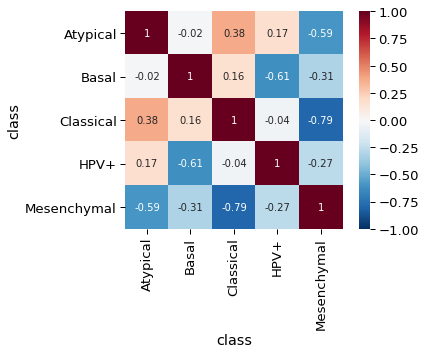

In [165]:
graph = sns.heatmap(round(mean_score.T.corr(),2), vmin=-1, vmax=1,
                    square=True,annot=True,cmap='RdBu_r',annot_kws={"fontsize":10})

0
Index(['HPV+', 'Atypical', 'Basal', 'Classical', 'Mesenchymal'], dtype='object', name='class')
1
Index(['HPV+', 'Atypical', 'Basal', 'Classical', 'Mesenchymal'], dtype='object', name='class')
2
Index(['HPV+', 'Atypical', 'Basal', 'Classical', 'Mesenchymal'], dtype='object', name='class')
3
Index(['HPV+', 'Atypical', 'Basal', 'Classical', 'Mesenchymal'], dtype='object', name='class')


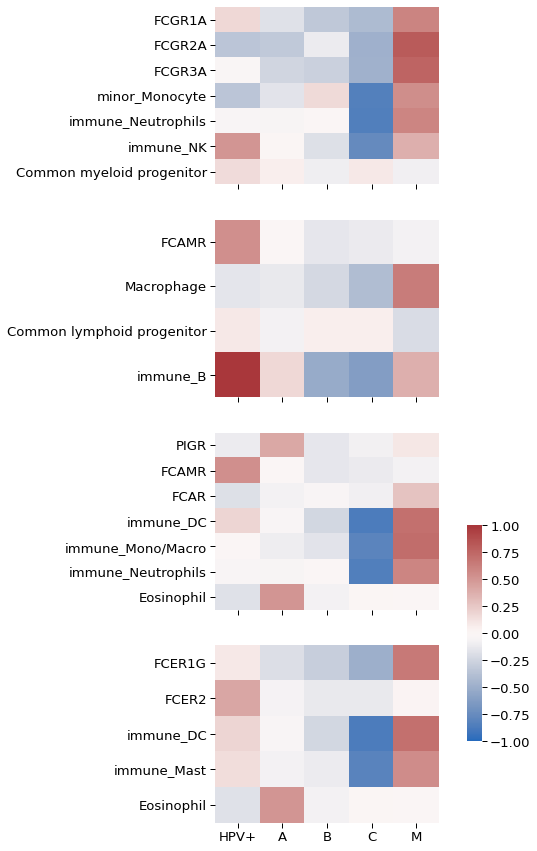

<Figure size 432x288 with 0 Axes>

In [162]:
fig, axn = plt.subplots(4, 1, sharey=False,sharex=True)
# cbar_ax = fig.add_axes([.91, .3, .03, .2])
cbar_ax = fig.add_axes([1, .2, .05, .2])
fig.set_size_inches(4, 15)
sns.set_context("paper", font_scale=1.5)
for i, ax in enumerate(axn.flat):
    print(i)
    df = datasets[i].T
    df = df[['HPV+','Atypical', 'Basal', 'Classical','Mesenchymal']]
    print(df.columns)
    sns.heatmap(df, ax=ax,cmap="vlag",annot=False,xticklabels=['HPV+','A','B','C','M'],
                #yticklabels='',
                cbar=i == 0,
                vmin=-1, vmax=1,
                cbar_ax=None if i else cbar_ax)

# fig.tight_layout(rect=[0, 0, 0.9, 1])

axn[0].set(xlabel="",ylabel='')
axn[1].set(xlabel="",ylabel='')
axn[2].set(xlabel="",ylabel='')
axn[3].set(xlabel="",ylabel='')

fig_out_path = 'paper_results/5_fc_isotypes/TCGA.png'
plt.savefig(fig_out_path, format="png",dpi=150,bbox_inches = 'tight')
plt.show()
plt.clf()